In [52]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from sklearn import preprocessing    
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
import keras
from keras.models import Sequential
from keras.layers import Dense, Dropout,regularizers,BatchNormalization
from keras.models import model_from_json
from sklearn.model_selection import cross_val_score, KFold
from keras.backend import eval
from keras.callbacks import *
from sklearn.model_selection import StratifiedKFold

In [53]:
dataset = pd.read_csv('train.csv')

X = dataset.iloc[:, 0:81].values
y = dataset.iloc[:, 81].values

In [54]:
y=np.reshape(y, (-1,1))
minmax_scale1 = preprocessing.StandardScaler().fit(X)
minmax_scale2 = preprocessing.StandardScaler().fit(y)

X_tr = minmax_scale1.transform(X)
y_tr = minmax_scale2.transform(y)

In [55]:
np.random.seed(9001)
X_train, X_test, y_train, y_test = train_test_split(X_tr, y, test_size = 0.15, random_state = 0)

In [56]:
def Model(learning_rate,iterations):
    model = Sequential()
    model.add(Dense(output_dim =42 , init = 'normal', activation = 'relu', input_dim=81))
    BatchNormalization(axis=-1)
    model.add(Dense(output_dim =42 , init = 'normal', activation = 'relu'))
    BatchNormalization(axis=-1)
    model.add(Dense(output_dim =42 , init = 'normal', activation = 'relu'))
    BatchNormalization(axis=-1)
    model.add(Dense(output_dim =1 , init = 'normal', activation = 'linear'))
    model.compile(optimizer = keras.optimizers.Adam(learning_rate), loss = 'mae', metrics=['mae'])
    history=model.fit(X_train, y_train, epochs=iterations, batch_size=1024)
    plt.plot(history.history['loss'],'k')
    plt.show()

In [57]:
class CyclicLR(Callback):
    """This callback implements a cyclical learning rate policy (CLR).
    The method cycles the learning rate between two boundaries with
    some constant frequency, as detailed in this paper (https://arxiv.org/abs/1506.01186).
    The amplitude of the cycle can be scaled on a per-iteration or 
    per-cycle basis.
    This class has three built-in policies, as put forth in the paper.
    "triangular":
        A basic triangular cycle w/ no amplitude scaling.
    "triangular2":
        A basic triangular cycle that scales initial amplitude by half each cycle.
    "exp_range":
        A cycle that scales initial amplitude by gamma**(cycle iterations) at each 
        cycle iteration.
    For more detail, please see paper.
    
    # Example
        ```python
            clr = CyclicLR(base_lr=0.001, max_lr=0.006,
                                step_size=2000., mode='triangular')
            model.fit(X_train, Y_train, callbacks=[clr])
        ```
    
    Class also supports custom scaling functions:
        ```python
            clr_fn = lambda x: 0.5*(1+np.sin(x*np.pi/2.))
            clr = CyclicLR(base_lr=0.001, max_lr=0.006,
                                step_size=2000., scale_fn=clr_fn,
                                scale_mode='cycle')
            model.fit(X_train, Y_train, callbacks=[clr])
        ```    
    # Arguments
        base_lr: initial learning rate which is the
            lower boundary in the cycle.
        max_lr: upper boundary in the cycle. Functionally,
            it defines the cycle amplitude (max_lr - base_lr).
            The lr at any cycle is the sum of base_lr
            and some scaling of the amplitude; therefore 
            max_lr may not actually be reached depending on
            scaling function.
        step_size: number of training iterations per
            half cycle. Authors suggest setting step_size
            2-8 x training iterations in epoch.
        mode: one of {triangular, triangular2, exp_range}.
            Default 'triangular'.
            Values correspond to policies detailed above.
            If scale_fn is not None, this argument is ignored.
        gamma: constant in 'exp_range' scaling function:
            gamma**(cycle iterations)
        scale_fn: Custom scaling policy defined by a single
            argument lambda function, where 
            0 <= scale_fn(x) <= 1 for all x >= 0.
            mode paramater is ignored 
        scale_mode: {'cycle', 'iterations'}.
            Defines whether scale_fn is evaluated on 
            cycle number or cycle iterations (training
            iterations since start of cycle). Default is 'cycle'.
    """

    def __init__(self, base_lr=0.001, max_lr=0.006, step_size=2000., mode='triangular',
                 gamma=1., scale_fn=None, scale_mode='cycle'):
        super(CyclicLR, self).__init__()

        self.base_lr = base_lr
        self.max_lr = max_lr
        self.step_size = step_size
        self.mode = mode
        self.gamma = gamma
        if scale_fn == None:
            if self.mode == 'triangular':
                self.scale_fn = lambda x: 1.
                self.scale_mode = 'cycle'
            elif self.mode == 'triangular2':
                self.scale_fn = lambda x: 1/(2.**(x-1))
                self.scale_mode = 'cycle'
            elif self.mode == 'exp_range':
                self.scale_fn = lambda x: gamma**(x)
                self.scale_mode = 'iterations'
        else:
            self.scale_fn = scale_fn
            self.scale_mode = scale_mode
        self.clr_iterations = 0.
        self.trn_iterations = 0.
        self.history = {}

        self._reset()

    def _reset(self, new_base_lr=None, new_max_lr=None,
               new_step_size=None):
        """Resets cycle iterations.
        Optional boundary/step size adjustment.
        """
        if new_base_lr != None:
            self.base_lr = new_base_lr
        if new_max_lr != None:
            self.max_lr = new_max_lr
        if new_step_size != None:
            self.step_size = new_step_size
        self.clr_iterations = 0.
        
    def clr(self):
        cycle = np.floor(1+self.clr_iterations/(2*self.step_size))
        x = np.abs(self.clr_iterations/self.step_size - 2*cycle + 1)
        if self.scale_mode == 'cycle':
            return self.base_lr + (self.max_lr-self.base_lr)*np.maximum(0, (1-x))*self.scale_fn(cycle)
        else:
            return self.base_lr + (self.max_lr-self.base_lr)*np.maximum(0, (1-x))*self.scale_fn(self.clr_iterations)
        
    def on_train_begin(self, logs={}):
        logs = logs or {}

        if self.clr_iterations == 0:
            K.set_value(self.model.optimizer.lr, self.base_lr)
        else:
            K.set_value(self.model.optimizer.lr, self.clr())        
            
    def on_batch_end(self, epoch, logs=None):
        
        logs = logs or {}
        self.trn_iterations += 1
        self.clr_iterations += 1

        self.history.setdefault('lr', []).append(K.get_value(self.model.optimizer.lr))
        self.history.setdefault('iterations', []).append(self.trn_iterations)

        for k, v in logs.items():
            self.history.setdefault(k, []).append(v)
        
        K.set_value(self.model.optimizer.lr, self.clr())
    

def f1(y_true, y_pred):
    '''
    metric from here 
    https://stackoverflow.com/questions/43547402/how-to-calculate-f1-macro-in-keras
    '''
    def recall(y_true, y_pred):
        """Recall metric.

        Only computes a batch-wise average of recall.

        Computes the recall, a metric for multi-label classification of
        how many relevant items are selected.
        """
        true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
        possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
        recall = true_positives / (possible_positives + K.epsilon())
        return recall

    def precision(y_true, y_pred):
        """Precision metric.

        Only computes a batch-wise average of precision.

        Computes the precision, a metric for multi-label classification of
        how many selected items are relevant.
        """
        true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
        predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
        precision = true_positives / (predicted_positives + K.epsilon())
        return precision
    precision = precision(y_true, y_pred)
    recall = recall(y_true, y_pred)
    return 2*((precision*recall)/(precision+recall+K.epsilon()))
    

In [58]:
clr=CyclicLR(mode='triangular')
from keras.optimizers import Adam

In [73]:
def Modelcycle(iterations,clr,X,y):
    kfold = KFold(n_splits=10, shuffle=True, random_state=9)
    cvscores = []
    for train, test in kfold.split(X, y):
        model = Sequential()
        model.add(Dense(output_dim =42 , init = 'normal', activation = 'relu', input_dim=81))
        BatchNormalization(axis=-1)
        model.add(Dense(output_dim =42 , init = 'normal', activation = 'relu'))
        BatchNormalization(axis=-1)
        model.add(Dense(output_dim =42 , init = 'normal', activation = 'relu'))
        BatchNormalization(axis=-1)
        model.add(Dense(output_dim =1 , init = 'normal', activation = 'linear'))
        model.compile(optimizer=Adam(0.1), loss = 'mae', metrics=['mae'])
        history1=model.fit(X[train],y[train], batch_size=2000,validation_data=(X[test], y[test]),epochs=iterations, callbacks = [clr,])
        h=clr.history
        plt.plot(history1.history['loss'])
        plt.show()
        scores = model.evaluate(X[test], y[test], verbose=0)
        print("%s: %.2f%%" % (model.metrics_names[1], scores[1]*100))
        cvscores.append(scores[1] * 100)
    print("%.2f%% (+/- %.2f%%)" % (np.mean(cvscores), np.std(cvscores))) 
    return model

C:\Users\shaltaf\AppData\Local\conda\conda\envs\neural\lib\site-packages\ipykernel_launcher.py:6: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(activation="relu", input_dim=81, units=42, kernel_initializer="normal")`
  
C:\Users\shaltaf\AppData\Local\conda\conda\envs\neural\lib\site-packages\ipykernel_launcher.py:8: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(activation="relu", units=42, kernel_initializer="normal")`
  
C:\Users\shaltaf\AppData\Local\conda\conda\envs\neural\lib\site-packages\ipykernel_launcher.py:10: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(activation="relu", units=42, kernel_initializer="normal")`
  # Remove the CWD from sys.path while we load stuff.
C:\Users\shaltaf\AppData\Local\conda\conda\envs\neural\lib\site-packages\ipykernel_launcher.py:20: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(activation="linear", units=1, kernel_initializer="normal")`


Train on 16265 samples, validate on 1808 samples
Epoch 1/2000
12000/16265 [=====================>........] - ETA: 0s - loss: 34.2975 - mean_absolute_error: 34.2975

C:\Users\shaltaf\AppData\Local\conda\conda\envs\neural\lib\site-packages\keras\callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.107381). Check your callbacks.
  % delta_t_median)


16265/16265 [==============================] - 1s 56us/step - loss: 34.0577 - mean_absolute_error: 34.0577 - val_loss: 32.1054 - val_mean_absolute_error: 32.1054
Epoch 2/2000
16265/16265 [==============================] - 0s 8us/step - loss: 27.8509 - mean_absolute_error: 27.8509 - val_loss: 17.3410 - val_mean_absolute_error: 17.3410
Epoch 3/2000
16265/16265 [==============================] - 0s 9us/step - loss: 17.5650 - mean_absolute_error: 17.5650 - val_loss: 15.7537 - val_mean_absolute_error: 15.7537
Epoch 4/2000
16265/16265 [==============================] - 0s 9us/step - loss: 15.3038 - mean_absolute_error: 15.3038 - val_loss: 14.0339 - val_mean_absolute_error: 14.0339
Epoch 5/2000
16265/16265 [==============================] - 0s 10us/step - loss: 13.8749 - mean_absolute_error: 13.8749 - val_loss: 13.2470 - val_mean_absolute_error: 13.2470
Epoch 6/2000
16265/16265 [==============================] - 0s 9us/step - loss: 13.1179 - mean_absolute_error: 13.1179 - val_loss: 12.7988 - 

Epoch 96/2000
16265/16265 [==============================] - 0s 13us/step - loss: 7.7822 - mean_absolute_error: 7.7822 - val_loss: 7.8084 - val_mean_absolute_error: 7.8084
Epoch 97/2000
16265/16265 [==============================] - 0s 12us/step - loss: 7.7537 - mean_absolute_error: 7.7537 - val_loss: 8.1053 - val_mean_absolute_error: 8.1053
Epoch 98/2000
16265/16265 [==============================] - 0s 11us/step - loss: 7.7614 - mean_absolute_error: 7.7614 - val_loss: 8.2418 - val_mean_absolute_error: 8.2418
Epoch 99/2000
16265/16265 [==============================] - 0s 12us/step - loss: 7.8033 - mean_absolute_error: 7.8033 - val_loss: 7.8731 - val_mean_absolute_error: 7.8731
Epoch 100/2000
16265/16265 [==============================] - 0s 12us/step - loss: 7.7801 - mean_absolute_error: 7.7801 - val_loss: 8.0487 - val_mean_absolute_error: 8.0487
Epoch 101/2000
16265/16265 [==============================] - 0s 9us/step - loss: 7.7780 - mean_absolute_error: 7.7780 - val_loss: 7.8384 -

16265/16265 [==============================] - 0s 10us/step - loss: 7.0307 - mean_absolute_error: 7.0307 - val_loss: 7.2926 - val_mean_absolute_error: 7.2926
Epoch 191/2000
16265/16265 [==============================] - 0s 7us/step - loss: 7.0300 - mean_absolute_error: 7.0300 - val_loss: 7.4603 - val_mean_absolute_error: 7.4603
Epoch 192/2000
16265/16265 [==============================] - 0s 7us/step - loss: 7.0543 - mean_absolute_error: 7.0543 - val_loss: 7.2828 - val_mean_absolute_error: 7.2828
Epoch 193/2000
16265/16265 [==============================] - 0s 7us/step - loss: 7.0526 - mean_absolute_error: 7.0526 - val_loss: 7.2825 - val_mean_absolute_error: 7.2825
Epoch 194/2000
16265/16265 [==============================] - 0s 7us/step - loss: 7.0041 - mean_absolute_error: 7.0041 - val_loss: 7.3369 - val_mean_absolute_error: 7.3369
Epoch 195/2000
16265/16265 [==============================] - 0s 7us/step - loss: 6.9793 - mean_absolute_error: 6.9793 - val_loss: 7.2519 - val_mean_absol

Epoch 238/2000
16265/16265 [==============================] - 0s 7us/step - loss: 6.8471 - mean_absolute_error: 6.8471 - val_loss: 7.1909 - val_mean_absolute_error: 7.1909
Epoch 239/2000
16265/16265 [==============================] - 0s 6us/step - loss: 6.8122 - mean_absolute_error: 6.8122 - val_loss: 7.1885 - val_mean_absolute_error: 7.1885
Epoch 240/2000
16265/16265 [==============================] - 0s 7us/step - loss: 6.8193 - mean_absolute_error: 6.8193 - val_loss: 7.2198 - val_mean_absolute_error: 7.2198
Epoch 241/2000
16265/16265 [==============================] - 0s 7us/step - loss: 6.8099 - mean_absolute_error: 6.8099 - val_loss: 7.2486 - val_mean_absolute_error: 7.2486
Epoch 242/2000
16265/16265 [==============================] - 0s 6us/step - loss: 6.8050 - mean_absolute_error: 6.8050 - val_loss: 7.2539 - val_mean_absolute_error: 7.2539
Epoch 243/2000
16265/16265 [==============================] - 0s 7us/step - loss: 6.8055 - mean_absolute_error: 6.8055 - val_loss: 7.2011 - 

Epoch 333/2000
16265/16265 [==============================] - 0s 7us/step - loss: 6.7228 - mean_absolute_error: 6.7228 - val_loss: 7.1022 - val_mean_absolute_error: 7.1022
Epoch 334/2000
16265/16265 [==============================] - 0s 7us/step - loss: 6.7019 - mean_absolute_error: 6.7019 - val_loss: 7.0146 - val_mean_absolute_error: 7.0146
Epoch 335/2000
16265/16265 [==============================] - 0s 7us/step - loss: 6.7010 - mean_absolute_error: 6.7010 - val_loss: 7.0248 - val_mean_absolute_error: 7.0248
Epoch 336/2000
16265/16265 [==============================] - 0s 7us/step - loss: 6.6621 - mean_absolute_error: 6.6621 - val_loss: 7.0802 - val_mean_absolute_error: 7.0802
Epoch 337/2000
16265/16265 [==============================] - 0s 7us/step - loss: 6.6751 - mean_absolute_error: 6.6751 - val_loss: 6.9913 - val_mean_absolute_error: 6.9913
Epoch 338/2000
16265/16265 [==============================] - 0s 7us/step - loss: 6.6473 - mean_absolute_error: 6.6473 - val_loss: 7.7446 - 

Epoch 428/2000
16265/16265 [==============================] - 0s 6us/step - loss: 6.5187 - mean_absolute_error: 6.5187 - val_loss: 6.9374 - val_mean_absolute_error: 6.9374
Epoch 429/2000
16265/16265 [==============================] - 0s 6us/step - loss: 6.4766 - mean_absolute_error: 6.4766 - val_loss: 7.0401 - val_mean_absolute_error: 7.0401
Epoch 430/2000
16265/16265 [==============================] - 0s 7us/step - loss: 6.4725 - mean_absolute_error: 6.4725 - val_loss: 6.8689 - val_mean_absolute_error: 6.8689
Epoch 431/2000
16265/16265 [==============================] - 0s 7us/step - loss: 6.4540 - mean_absolute_error: 6.4540 - val_loss: 6.8654 - val_mean_absolute_error: 6.8654
Epoch 432/2000
16265/16265 [==============================] - 0s 7us/step - loss: 6.3758 - mean_absolute_error: 6.3758 - val_loss: 6.9599 - val_mean_absolute_error: 6.9599
Epoch 433/2000
16265/16265 [==============================] - 0s 7us/step - loss: 6.4018 - mean_absolute_error: 6.4018 - val_loss: 6.7803 - 

Epoch 523/2000
16265/16265 [==============================] - 0s 6us/step - loss: 6.2888 - mean_absolute_error: 6.2888 - val_loss: 6.6142 - val_mean_absolute_error: 6.6142
Epoch 524/2000
16265/16265 [==============================] - 0s 7us/step - loss: 6.2215 - mean_absolute_error: 6.2215 - val_loss: 6.7944 - val_mean_absolute_error: 6.7944
Epoch 525/2000
16265/16265 [==============================] - 0s 7us/step - loss: 6.2099 - mean_absolute_error: 6.2099 - val_loss: 6.7197 - val_mean_absolute_error: 6.7197
Epoch 526/2000
16265/16265 [==============================] - 0s 7us/step - loss: 6.2545 - mean_absolute_error: 6.2545 - val_loss: 6.7908 - val_mean_absolute_error: 6.7908
Epoch 527/2000
16265/16265 [==============================] - 0s 6us/step - loss: 6.2279 - mean_absolute_error: 6.2279 - val_loss: 6.9017 - val_mean_absolute_error: 6.9017
Epoch 528/2000
16265/16265 [==============================] - 0s 7us/step - loss: 6.3621 - mean_absolute_error: 6.3621 - val_loss: 6.6292 - 

Epoch 618/2000
16265/16265 [==============================] - 0s 7us/step - loss: 5.9751 - mean_absolute_error: 5.9751 - val_loss: 6.4276 - val_mean_absolute_error: 6.4276
Epoch 619/2000
16265/16265 [==============================] - 0s 6us/step - loss: 5.9455 - mean_absolute_error: 5.9455 - val_loss: 6.6378 - val_mean_absolute_error: 6.6378
Epoch 620/2000
16265/16265 [==============================] - 0s 6us/step - loss: 5.9360 - mean_absolute_error: 5.9360 - val_loss: 6.6827 - val_mean_absolute_error: 6.6827
Epoch 621/2000
16265/16265 [==============================] - 0s 7us/step - loss: 5.9325 - mean_absolute_error: 5.9325 - val_loss: 6.4771 - val_mean_absolute_error: 6.4771
Epoch 622/2000
16265/16265 [==============================] - 0s 7us/step - loss: 5.9448 - mean_absolute_error: 5.9448 - val_loss: 6.4673 - val_mean_absolute_error: 6.4673
Epoch 623/2000
16265/16265 [==============================] - 0s 6us/step - loss: 5.8716 - mean_absolute_error: 5.8716 - val_loss: 6.4879 - 

Epoch 713/2000
16265/16265 [==============================] - 0s 6us/step - loss: 5.7776 - mean_absolute_error: 5.7776 - val_loss: 6.4654 - val_mean_absolute_error: 6.4654
Epoch 714/2000
16265/16265 [==============================] - 0s 6us/step - loss: 5.8351 - mean_absolute_error: 5.8351 - val_loss: 6.4176 - val_mean_absolute_error: 6.4176
Epoch 715/2000
16265/16265 [==============================] - 0s 7us/step - loss: 5.8041 - mean_absolute_error: 5.8041 - val_loss: 6.5427 - val_mean_absolute_error: 6.5427
Epoch 716/2000
16265/16265 [==============================] - 0s 7us/step - loss: 5.7673 - mean_absolute_error: 5.7673 - val_loss: 6.4002 - val_mean_absolute_error: 6.4002
Epoch 717/2000
16265/16265 [==============================] - 0s 7us/step - loss: 5.7417 - mean_absolute_error: 5.7417 - val_loss: 6.4332 - val_mean_absolute_error: 6.4332
Epoch 718/2000
16265/16265 [==============================] - 0s 6us/step - loss: 5.7212 - mean_absolute_error: 5.7212 - val_loss: 6.4013 - 

Epoch 808/2000
16265/16265 [==============================] - 0s 7us/step - loss: 6.0417 - mean_absolute_error: 6.0417 - val_loss: 6.4527 - val_mean_absolute_error: 6.4527
Epoch 809/2000
16265/16265 [==============================] - 0s 7us/step - loss: 5.9688 - mean_absolute_error: 5.9688 - val_loss: 6.5297 - val_mean_absolute_error: 6.5297
Epoch 810/2000
16265/16265 [==============================] - 0s 7us/step - loss: 5.9930 - mean_absolute_error: 5.9930 - val_loss: 7.0267 - val_mean_absolute_error: 7.0267
Epoch 811/2000
16265/16265 [==============================] - 0s 6us/step - loss: 6.0690 - mean_absolute_error: 6.0690 - val_loss: 6.7418 - val_mean_absolute_error: 6.7418
Epoch 812/2000
16265/16265 [==============================] - 0s 7us/step - loss: 6.0041 - mean_absolute_error: 6.0041 - val_loss: 7.6864 - val_mean_absolute_error: 7.6864
Epoch 813/2000
16265/16265 [==============================] - 0s 7us/step - loss: 6.5563 - mean_absolute_error: 6.5563 - val_loss: 6.6807 - 

Epoch 903/2000
16265/16265 [==============================] - 0s 8us/step - loss: 5.9769 - mean_absolute_error: 5.9769 - val_loss: 6.4265 - val_mean_absolute_error: 6.4265
Epoch 904/2000
16265/16265 [==============================] - 0s 13us/step - loss: 5.8789 - mean_absolute_error: 5.8789 - val_loss: 6.7998 - val_mean_absolute_error: 6.7998
Epoch 905/2000
16265/16265 [==============================] - 0s 7us/step - loss: 6.2283 - mean_absolute_error: 6.2283 - val_loss: 6.5649 - val_mean_absolute_error: 6.5649
Epoch 906/2000
16265/16265 [==============================] - 0s 8us/step - loss: 6.0615 - mean_absolute_error: 6.0615 - val_loss: 6.4886 - val_mean_absolute_error: 6.4886
Epoch 907/2000
16265/16265 [==============================] - 0s 10us/step - loss: 5.9187 - mean_absolute_error: 5.9187 - val_loss: 7.0302 - val_mean_absolute_error: 7.0302
Epoch 908/2000
16265/16265 [==============================] - 0s 8us/step - loss: 5.9300 - mean_absolute_error: 5.9300 - val_loss: 6.4951 

Epoch 998/2000
16265/16265 [==============================] - 0s 7us/step - loss: 5.6964 - mean_absolute_error: 5.6964 - val_loss: 6.3590 - val_mean_absolute_error: 6.3590
Epoch 999/2000
16265/16265 [==============================] - 0s 7us/step - loss: 5.6152 - mean_absolute_error: 5.6152 - val_loss: 6.3920 - val_mean_absolute_error: 6.3920
Epoch 1000/2000
16265/16265 [==============================] - 0s 7us/step - loss: 5.7178 - mean_absolute_error: 5.7178 - val_loss: 6.4809 - val_mean_absolute_error: 6.4809
Epoch 1001/2000
16265/16265 [==============================] - 0s 7us/step - loss: 5.7896 - mean_absolute_error: 5.7896 - val_loss: 6.3380 - val_mean_absolute_error: 6.3380
Epoch 1002/2000
16265/16265 [==============================] - 0s 7us/step - loss: 5.7600 - mean_absolute_error: 5.7600 - val_loss: 6.3775 - val_mean_absolute_error: 6.3775
Epoch 1003/2000
16265/16265 [==============================] - 0s 7us/step - loss: 5.6544 - mean_absolute_error: 5.6544 - val_loss: 6.966

16265/16265 [==============================] - 0s 7us/step - loss: 5.4439 - mean_absolute_error: 5.4439 - val_loss: 6.3244 - val_mean_absolute_error: 6.3244
Epoch 1093/2000
16265/16265 [==============================] - 0s 7us/step - loss: 5.4819 - mean_absolute_error: 5.4819 - val_loss: 6.3944 - val_mean_absolute_error: 6.3944
Epoch 1094/2000
16265/16265 [==============================] - 0s 9us/step - loss: 5.4368 - mean_absolute_error: 5.4368 - val_loss: 6.3239 - val_mean_absolute_error: 6.3239
Epoch 1095/2000
16265/16265 [==============================] - 0s 9us/step - loss: 5.4202 - mean_absolute_error: 5.4202 - val_loss: 6.3106 - val_mean_absolute_error: 6.3106
Epoch 1096/2000
16265/16265 [==============================] - 0s 8us/step - loss: 5.3925 - mean_absolute_error: 5.3925 - val_loss: 6.2498 - val_mean_absolute_error: 6.2498
Epoch 1097/2000
16265/16265 [==============================] - 0s 7us/step - loss: 5.4209 - mean_absolute_error: 5.4209 - val_loss: 6.3372 - val_mean_a

Epoch 1186/2000
16265/16265 [==============================] - 0s 16us/step - loss: 5.4662 - mean_absolute_error: 5.4662 - val_loss: 6.2445 - val_mean_absolute_error: 6.2445
Epoch 1187/2000
16265/16265 [==============================] - 0s 12us/step - loss: 5.4706 - mean_absolute_error: 5.4706 - val_loss: 6.3984 - val_mean_absolute_error: 6.3984
Epoch 1188/2000
16265/16265 [==============================] - 0s 10us/step - loss: 5.4541 - mean_absolute_error: 5.4541 - val_loss: 6.4154 - val_mean_absolute_error: 6.4154
Epoch 1189/2000
16265/16265 [==============================] - 0s 10us/step - loss: 5.4961 - mean_absolute_error: 5.4961 - val_loss: 6.2657 - val_mean_absolute_error: 6.2657
Epoch 1190/2000
16265/16265 [==============================] - 0s 10us/step - loss: 5.6033 - mean_absolute_error: 5.6033 - val_loss: 6.3480 - val_mean_absolute_error: 6.3480
Epoch 1191/2000
16265/16265 [==============================] - 0s 10us/step - loss: 5.5249 - mean_absolute_error: 5.5249 - val_los

16265/16265 [==============================] - 0s 7us/step - loss: 5.7841 - mean_absolute_error: 5.7841 - val_loss: 6.3792 - val_mean_absolute_error: 6.3792
Epoch 1281/2000
16265/16265 [==============================] - 0s 7us/step - loss: 5.7490 - mean_absolute_error: 5.7490 - val_loss: 6.6485 - val_mean_absolute_error: 6.6485
Epoch 1282/2000
16265/16265 [==============================] - 0s 7us/step - loss: 5.5929 - mean_absolute_error: 5.5929 - val_loss: 6.3549 - val_mean_absolute_error: 6.3549
Epoch 1283/2000
16265/16265 [==============================] - 0s 7us/step - loss: 5.5247 - mean_absolute_error: 5.5247 - val_loss: 6.4683 - val_mean_absolute_error: 6.4683
Epoch 1284/2000
16265/16265 [==============================] - 0s 7us/step - loss: 5.5825 - mean_absolute_error: 5.5825 - val_loss: 6.4610 - val_mean_absolute_error: 6.4610
Epoch 1285/2000
16265/16265 [==============================] - 0s 10us/step - loss: 5.5385 - mean_absolute_error: 5.5385 - val_loss: 6.3065 - val_mean_

16265/16265 [==============================] - 0s 8us/step - loss: 5.5689 - mean_absolute_error: 5.5689 - val_loss: 6.4976 - val_mean_absolute_error: 6.4976
Epoch 1375/2000
16265/16265 [==============================] - 0s 10us/step - loss: 5.6259 - mean_absolute_error: 5.6259 - val_loss: 6.3945 - val_mean_absolute_error: 6.3945
Epoch 1376/2000
16265/16265 [==============================] - 0s 8us/step - loss: 5.4879 - mean_absolute_error: 5.4879 - val_loss: 6.5146 - val_mean_absolute_error: 6.5146
Epoch 1377/2000
16265/16265 [==============================] - 0s 7us/step - loss: 5.6352 - mean_absolute_error: 5.6352 - val_loss: 6.5051 - val_mean_absolute_error: 6.5051
Epoch 1378/2000
16265/16265 [==============================] - 0s 8us/step - loss: 5.7203 - mean_absolute_error: 5.7203 - val_loss: 6.3428 - val_mean_absolute_error: 6.3428
Epoch 1379/2000
16265/16265 [==============================] - 0s 7us/step - loss: 5.5355 - mean_absolute_error: 5.5355 - val_loss: 6.2880 - val_mean_

16265/16265 [==============================] - 0s 7us/step - loss: 5.4103 - mean_absolute_error: 5.4103 - val_loss: 6.2827 - val_mean_absolute_error: 6.2827
Epoch 1469/2000
16265/16265 [==============================] - 0s 7us/step - loss: 5.3707 - mean_absolute_error: 5.3707 - val_loss: 6.4049 - val_mean_absolute_error: 6.4049
Epoch 1470/2000
16265/16265 [==============================] - 0s 7us/step - loss: 5.4741 - mean_absolute_error: 5.4741 - val_loss: 6.3831 - val_mean_absolute_error: 6.3831
Epoch 1471/2000
16265/16265 [==============================] - 0s 7us/step - loss: 5.3594 - mean_absolute_error: 5.3594 - val_loss: 6.2535 - val_mean_absolute_error: 6.2535
Epoch 1472/2000
16265/16265 [==============================] - 0s 7us/step - loss: 5.3802 - mean_absolute_error: 5.3802 - val_loss: 6.2173 - val_mean_absolute_error: 6.2173
Epoch 1473/2000
16265/16265 [==============================] - 0s 7us/step - loss: 5.3460 - mean_absolute_error: 5.3460 - val_loss: 6.2530 - val_mean_a

16265/16265 [==============================] - 0s 7us/step - loss: 5.1332 - mean_absolute_error: 5.1332 - val_loss: 6.1983 - val_mean_absolute_error: 6.1983
Epoch 1563/2000
16265/16265 [==============================] - 0s 7us/step - loss: 5.1603 - mean_absolute_error: 5.1603 - val_loss: 6.1950 - val_mean_absolute_error: 6.1950
Epoch 1564/2000
16265/16265 [==============================] - 0s 7us/step - loss: 5.1768 - mean_absolute_error: 5.1768 - val_loss: 6.2509 - val_mean_absolute_error: 6.2509
Epoch 1565/2000
16265/16265 [==============================] - 0s 7us/step - loss: 5.1591 - mean_absolute_error: 5.1591 - val_loss: 6.1479 - val_mean_absolute_error: 6.1479
Epoch 1566/2000
16265/16265 [==============================] - 0s 7us/step - loss: 5.1447 - mean_absolute_error: 5.1447 - val_loss: 6.1424 - val_mean_absolute_error: 6.1424
Epoch 1567/2000
16265/16265 [==============================] - 0s 7us/step - loss: 5.1143 - mean_absolute_error: 5.1143 - val_loss: 6.2685 - val_mean_a

16265/16265 [==============================] - 0s 7us/step - loss: 5.2333 - mean_absolute_error: 5.2333 - val_loss: 6.2352 - val_mean_absolute_error: 6.2352
Epoch 1657/2000
16265/16265 [==============================] - 0s 7us/step - loss: 5.2696 - mean_absolute_error: 5.2696 - val_loss: 6.2045 - val_mean_absolute_error: 6.2045
Epoch 1658/2000
16265/16265 [==============================] - 0s 8us/step - loss: 5.2693 - mean_absolute_error: 5.2693 - val_loss: 6.3688 - val_mean_absolute_error: 6.3688
Epoch 1659/2000
16265/16265 [==============================] - 0s 7us/step - loss: 5.2969 - mean_absolute_error: 5.2969 - val_loss: 6.7120 - val_mean_absolute_error: 6.7120
Epoch 1660/2000
16265/16265 [==============================] - 0s 8us/step - loss: 5.3905 - mean_absolute_error: 5.3905 - val_loss: 6.3461 - val_mean_absolute_error: 6.3461
Epoch 1661/2000
16265/16265 [==============================] - 0s 9us/step - loss: 5.2541 - mean_absolute_error: 5.2541 - val_loss: 6.2760 - val_mean_a

16265/16265 [==============================] - 0s 7us/step - loss: 5.3729 - mean_absolute_error: 5.3729 - val_loss: 6.4769 - val_mean_absolute_error: 6.4769
Epoch 1751/2000
16265/16265 [==============================] - 0s 7us/step - loss: 5.3571 - mean_absolute_error: 5.3571 - val_loss: 6.4692 - val_mean_absolute_error: 6.4692
Epoch 1752/2000
16265/16265 [==============================] - ETA: 0s - loss: 5.4447 - mean_absolute_error: 5.444 - 0s 7us/step - loss: 5.4250 - mean_absolute_error: 5.4250 - val_loss: 6.2236 - val_mean_absolute_error: 6.2236
Epoch 1753/2000
16265/16265 [==============================] - 0s 8us/step - loss: 5.4499 - mean_absolute_error: 5.4499 - val_loss: 6.3117 - val_mean_absolute_error: 6.3117
Epoch 1754/2000
16265/16265 [==============================] - 0s 7us/step - loss: 5.3067 - mean_absolute_error: 5.3067 - val_loss: 6.7669 - val_mean_absolute_error: 6.7669
Epoch 1755/2000
16265/16265 [==============================] - 0s 8us/step - loss: 5.5112 - mean_

16265/16265 [==============================] - 0s 10us/step - loss: 5.9711 - mean_absolute_error: 5.9711 - val_loss: 6.7421 - val_mean_absolute_error: 6.7421
Epoch 1798/2000
16265/16265 [==============================] - ETA: 0s - loss: 5.7688 - mean_absolute_error: 5.768 - 0s 12us/step - loss: 5.7428 - mean_absolute_error: 5.7428 - val_loss: 6.4384 - val_mean_absolute_error: 6.4384
Epoch 1799/2000
16265/16265 [==============================] - 0s 13us/step - loss: 5.5318 - mean_absolute_error: 5.5318 - val_loss: 6.5634 - val_mean_absolute_error: 6.5634
Epoch 1800/2000
16265/16265 [==============================] - 0s 14us/step - loss: 5.7180 - mean_absolute_error: 5.7180 - val_loss: 7.0814 - val_mean_absolute_error: 7.0814
Epoch 1801/2000
16265/16265 [==============================] - 0s 9us/step - loss: 5.6592 - mean_absolute_error: 5.6592 - val_loss: 6.2679 - val_mean_absolute_error: 6.2679
Epoch 1802/2000
16265/16265 [==============================] - 0s 11us/step - loss: 5.5266 - 

16265/16265 [==============================] - 0s 8us/step - loss: 5.2517 - mean_absolute_error: 5.2517 - val_loss: 6.2410 - val_mean_absolute_error: 6.2410
Epoch 1892/2000
16265/16265 [==============================] - 0s 9us/step - loss: 5.2416 - mean_absolute_error: 5.2416 - val_loss: 6.1734 - val_mean_absolute_error: 6.1734
Epoch 1893/2000
16265/16265 [==============================] - 0s 8us/step - loss: 5.1811 - mean_absolute_error: 5.1811 - val_loss: 6.1751 - val_mean_absolute_error: 6.1751
Epoch 1894/2000
16265/16265 [==============================] - 0s 8us/step - loss: 5.2312 - mean_absolute_error: 5.2312 - val_loss: 6.2844 - val_mean_absolute_error: 6.2844
Epoch 1895/2000
16265/16265 [==============================] - 0s 8us/step - loss: 5.2390 - mean_absolute_error: 5.2390 - val_loss: 6.3072 - val_mean_absolute_error: 6.3072
Epoch 1896/2000
16265/16265 [==============================] - 0s 7us/step - loss: 5.1588 - mean_absolute_error: 5.1588 - val_loss: 6.0925 - val_mean_a

16265/16265 [==============================] - 0s 10us/step - loss: 5.0251 - mean_absolute_error: 5.0251 - val_loss: 6.1522 - val_mean_absolute_error: 6.1522
Epoch 1986/2000
16265/16265 [==============================] - 0s 8us/step - loss: 5.0128 - mean_absolute_error: 5.0128 - val_loss: 6.1429 - val_mean_absolute_error: 6.1429
Epoch 1987/2000
16265/16265 [==============================] - 0s 8us/step - loss: 4.9986 - mean_absolute_error: 4.9986 - val_loss: 6.1327 - val_mean_absolute_error: 6.1327
Epoch 1988/2000
16265/16265 [==============================] - 0s 9us/step - loss: 5.0522 - mean_absolute_error: 5.0522 - val_loss: 6.1126 - val_mean_absolute_error: 6.1126
Epoch 1989/2000
16265/16265 [==============================] - 0s 8us/step - loss: 5.0022 - mean_absolute_error: 5.0022 - val_loss: 6.1247 - val_mean_absolute_error: 6.1247
Epoch 1990/2000
16265/16265 [==============================] - 0s 9us/step - loss: 5.0386 - mean_absolute_error: 5.0386 - val_loss: 6.2392 - val_mean_

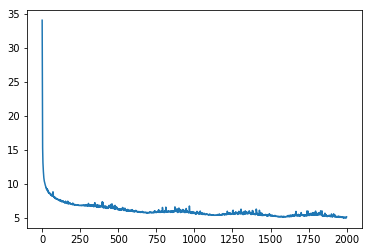

mean_absolute_error: 614.52%
Train on 16265 samples, validate on 1808 samples
Epoch 1/2000
12000/16265 [=====================>........] - ETA: 0s - loss: 34.3058 - mean_absolute_error: 34.3058

C:\Users\shaltaf\AppData\Local\conda\conda\envs\neural\lib\site-packages\keras\callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.105424). Check your callbacks.
  % delta_t_median)


16265/16265 [==============================] - 1s 54us/step - loss: 34.2428 - mean_absolute_error: 34.2428 - val_loss: 35.1152 - val_mean_absolute_error: 35.1152
Epoch 2/2000
16265/16265 [==============================] - 0s 9us/step - loss: 34.0769 - mean_absolute_error: 34.0769 - val_loss: 34.7272 - val_mean_absolute_error: 34.7272
Epoch 3/2000
16265/16265 [==============================] - 0s 9us/step - loss: 33.3788 - mean_absolute_error: 33.3788 - val_loss: 33.3142 - val_mean_absolute_error: 33.3142
Epoch 4/2000
16265/16265 [==============================] - 0s 8us/step - loss: 31.4107 - mean_absolute_error: 31.4107 - val_loss: 30.2225 - val_mean_absolute_error: 30.2225
Epoch 5/2000
16265/16265 [==============================] - 0s 9us/step - loss: 27.2833 - mean_absolute_error: 27.2833 - val_loss: 23.6694 - val_mean_absolute_error: 23.6694
Epoch 6/2000
16265/16265 [==============================] - 0s 9us/step - loss: 20.1179 - mean_absolute_error: 20.1179 - val_loss: 16.6635 - v

Epoch 48/2000
16265/16265 [==============================] - 0s 8us/step - loss: 10.0059 - mean_absolute_error: 10.0059 - val_loss: 10.8447 - val_mean_absolute_error: 10.8447
Epoch 49/2000
16265/16265 [==============================] - 0s 7us/step - loss: 9.9772 - mean_absolute_error: 9.9772 - val_loss: 10.8263 - val_mean_absolute_error: 10.8263
Epoch 50/2000
16265/16265 [==============================] - 0s 8us/step - loss: 9.9535 - mean_absolute_error: 9.9535 - val_loss: 10.7116 - val_mean_absolute_error: 10.7116
Epoch 51/2000
16265/16265 [==============================] - 0s 8us/step - loss: 9.8947 - mean_absolute_error: 9.8947 - val_loss: 10.7085 - val_mean_absolute_error: 10.7085
Epoch 52/2000
16265/16265 [==============================] - 0s 8us/step - loss: 9.8372 - mean_absolute_error: 9.8372 - val_loss: 10.6675 - val_mean_absolute_error: 10.6675
Epoch 53/2000
16265/16265 [==============================] - 0s 8us/step - loss: 9.8082 - mean_absolute_error: 9.8082 - val_loss: 10.

16265/16265 [==============================] - 0s 8us/step - loss: 7.7511 - mean_absolute_error: 7.7511 - val_loss: 8.9459 - val_mean_absolute_error: 8.9459
Epoch 143/2000
16265/16265 [==============================] - 0s 8us/step - loss: 7.7148 - mean_absolute_error: 7.7148 - val_loss: 8.9213 - val_mean_absolute_error: 8.9213
Epoch 144/2000
16265/16265 [==============================] - 0s 8us/step - loss: 7.7012 - mean_absolute_error: 7.7012 - val_loss: 9.0407 - val_mean_absolute_error: 9.0407
Epoch 145/2000
16265/16265 [==============================] - 0s 8us/step - loss: 7.7420 - mean_absolute_error: 7.7420 - val_loss: 8.8423 - val_mean_absolute_error: 8.8423
Epoch 146/2000
16265/16265 [==============================] - 0s 8us/step - loss: 7.6981 - mean_absolute_error: 7.6981 - val_loss: 8.9474 - val_mean_absolute_error: 8.9474
Epoch 147/2000
16265/16265 [==============================] - 0s 8us/step - loss: 7.7412 - mean_absolute_error: 7.7412 - val_loss: 9.1060 - val_mean_absolu

Epoch 237/2000
16265/16265 [==============================] - 0s 8us/step - loss: 7.0443 - mean_absolute_error: 7.0443 - val_loss: 8.2211 - val_mean_absolute_error: 8.2211
Epoch 238/2000
16265/16265 [==============================] - 0s 8us/step - loss: 7.1124 - mean_absolute_error: 7.1124 - val_loss: 8.6133 - val_mean_absolute_error: 8.6133
Epoch 239/2000
16265/16265 [==============================] - 0s 7us/step - loss: 7.2201 - mean_absolute_error: 7.2201 - val_loss: 8.9974 - val_mean_absolute_error: 8.9974
Epoch 240/2000
16265/16265 [==============================] - 0s 8us/step - loss: 7.3539 - mean_absolute_error: 7.3539 - val_loss: 8.4310 - val_mean_absolute_error: 8.4310
Epoch 241/2000
16265/16265 [==============================] - 0s 8us/step - loss: 7.1555 - mean_absolute_error: 7.1555 - val_loss: 8.5863 - val_mean_absolute_error: 8.5863
Epoch 242/2000
16265/16265 [==============================] - 0s 8us/step - loss: 7.2034 - mean_absolute_error: 7.2034 - val_loss: 8.3200 - 

16265/16265 [==============================] - 0s 7us/step - loss: 6.6332 - mean_absolute_error: 6.6332 - val_loss: 7.7706 - val_mean_absolute_error: 7.7706
Epoch 332/2000
16265/16265 [==============================] - 0s 8us/step - loss: 6.5437 - mean_absolute_error: 6.5437 - val_loss: 7.8783 - val_mean_absolute_error: 7.8783
Epoch 333/2000
16265/16265 [==============================] - 0s 7us/step - loss: 6.5284 - mean_absolute_error: 6.5284 - val_loss: 8.1959 - val_mean_absolute_error: 8.1959
Epoch 334/2000
16265/16265 [==============================] - 0s 8us/step - loss: 6.8370 - mean_absolute_error: 6.8370 - val_loss: 8.8507 - val_mean_absolute_error: 8.8507
Epoch 335/2000
16265/16265 [==============================] - 0s 7us/step - loss: 7.1534 - mean_absolute_error: 7.1534 - val_loss: 8.1030 - val_mean_absolute_error: 8.1030
Epoch 336/2000
16265/16265 [==============================] - 0s 7us/step - loss: 6.6627 - mean_absolute_error: 6.6627 - val_loss: 7.7519 - val_mean_absolu

Epoch 379/2000
16265/16265 [==============================] - 0s 7us/step - loss: 6.8270 - mean_absolute_error: 6.8270 - val_loss: 8.0196 - val_mean_absolute_error: 8.0196
Epoch 380/2000
16265/16265 [==============================] - 0s 7us/step - loss: 6.4959 - mean_absolute_error: 6.4959 - val_loss: 7.7134 - val_mean_absolute_error: 7.7134
Epoch 381/2000
16265/16265 [==============================] - 0s 7us/step - loss: 6.4143 - mean_absolute_error: 6.4143 - val_loss: 7.6774 - val_mean_absolute_error: 7.6774
Epoch 382/2000
16265/16265 [==============================] - 0s 8us/step - loss: 6.4280 - mean_absolute_error: 6.4280 - val_loss: 7.5973 - val_mean_absolute_error: 7.5973
Epoch 383/2000
16265/16265 [==============================] - 0s 7us/step - loss: 6.3438 - mean_absolute_error: 6.3438 - val_loss: 7.5878 - val_mean_absolute_error: 7.5878
Epoch 384/2000
16265/16265 [==============================] - 0s 7us/step - loss: 6.3338 - mean_absolute_error: 6.3338 - val_loss: 7.6120 - 

16265/16265 [==============================] - 0s 7us/step - loss: 6.0969 - mean_absolute_error: 6.0969 - val_loss: 7.4579 - val_mean_absolute_error: 7.4579
Epoch 474/2000
16265/16265 [==============================] - 0s 7us/step - loss: 6.0992 - mean_absolute_error: 6.0992 - val_loss: 7.4299 - val_mean_absolute_error: 7.4299
Epoch 475/2000
16265/16265 [==============================] - 0s 7us/step - loss: 6.0709 - mean_absolute_error: 6.0709 - val_loss: 7.4193 - val_mean_absolute_error: 7.4193
Epoch 476/2000
16265/16265 [==============================] - 0s 8us/step - loss: 6.0716 - mean_absolute_error: 6.0716 - val_loss: 7.6359 - val_mean_absolute_error: 7.6359
Epoch 477/2000
16265/16265 [==============================] - 0s 7us/step - loss: 6.1788 - mean_absolute_error: 6.1788 - val_loss: 7.4586 - val_mean_absolute_error: 7.4586
Epoch 478/2000
16265/16265 [==============================] - 0s 7us/step - loss: 6.1404 - mean_absolute_error: 6.1404 - val_loss: 7.4604 - val_mean_absolu

Epoch 521/2000
16265/16265 [==============================] - 0s 8us/step - loss: 6.2988 - mean_absolute_error: 6.2988 - val_loss: 7.4481 - val_mean_absolute_error: 7.4481
Epoch 522/2000
16265/16265 [==============================] - 0s 7us/step - loss: 6.2009 - mean_absolute_error: 6.2009 - val_loss: 7.5460 - val_mean_absolute_error: 7.5460
Epoch 523/2000
16265/16265 [==============================] - 0s 7us/step - loss: 6.2300 - mean_absolute_error: 6.2300 - val_loss: 7.4422 - val_mean_absolute_error: 7.4422
Epoch 524/2000
16265/16265 [==============================] - 0s 8us/step - loss: 6.2212 - mean_absolute_error: 6.2212 - val_loss: 7.5158 - val_mean_absolute_error: 7.5158
Epoch 525/2000
16265/16265 [==============================] - 0s 7us/step - loss: 6.1880 - mean_absolute_error: 6.1880 - val_loss: 8.0569 - val_mean_absolute_error: 8.0569
Epoch 526/2000
16265/16265 [==============================] - 0s 7us/step - loss: 6.4253 - mean_absolute_error: 6.4253 - val_loss: 7.4491 - 

Epoch 616/2000
16265/16265 [==============================] - 0s 7us/step - loss: 6.4105 - mean_absolute_error: 6.4105 - val_loss: 7.5041 - val_mean_absolute_error: 7.5041
Epoch 617/2000
16265/16265 [==============================] - 0s 7us/step - loss: 6.2082 - mean_absolute_error: 6.2082 - val_loss: 7.6629 - val_mean_absolute_error: 7.6629
Epoch 618/2000
16265/16265 [==============================] - 0s 8us/step - loss: 6.2387 - mean_absolute_error: 6.2387 - val_loss: 7.3903 - val_mean_absolute_error: 7.3903
Epoch 619/2000
16265/16265 [==============================] - 0s 8us/step - loss: 6.1989 - mean_absolute_error: 6.1989 - val_loss: 7.3906 - val_mean_absolute_error: 7.3906
Epoch 620/2000
16265/16265 [==============================] - 0s 7us/step - loss: 6.0575 - mean_absolute_error: 6.0575 - val_loss: 7.3778 - val_mean_absolute_error: 7.3778
Epoch 621/2000
16265/16265 [==============================] - 0s 7us/step - loss: 6.1117 - mean_absolute_error: 6.1117 - val_loss: 7.4024 - 

Epoch 711/2000
16265/16265 [==============================] - 0s 7us/step - loss: 6.2380 - mean_absolute_error: 6.2380 - val_loss: 7.3871 - val_mean_absolute_error: 7.3871
Epoch 712/2000
16265/16265 [==============================] - 0s 7us/step - loss: 6.1019 - mean_absolute_error: 6.1019 - val_loss: 8.1484 - val_mean_absolute_error: 8.1484
Epoch 713/2000
16265/16265 [==============================] - 0s 7us/step - loss: 6.4472 - mean_absolute_error: 6.4472 - val_loss: 7.3120 - val_mean_absolute_error: 7.3120
Epoch 714/2000
16265/16265 [==============================] - 0s 7us/step - loss: 6.1390 - mean_absolute_error: 6.1390 - val_loss: 7.6909 - val_mean_absolute_error: 7.6909
Epoch 715/2000
16265/16265 [==============================] - 0s 7us/step - loss: 6.3577 - mean_absolute_error: 6.3577 - val_loss: 7.4283 - val_mean_absolute_error: 7.4283
Epoch 716/2000
16265/16265 [==============================] - 0s 8us/step - loss: 6.1670 - mean_absolute_error: 6.1670 - val_loss: 7.4920 - 

Epoch 806/2000
16265/16265 [==============================] - 0s 7us/step - loss: 5.7858 - mean_absolute_error: 5.7858 - val_loss: 7.0883 - val_mean_absolute_error: 7.0883
Epoch 807/2000
16265/16265 [==============================] - 0s 7us/step - loss: 5.7711 - mean_absolute_error: 5.7711 - val_loss: 7.0884 - val_mean_absolute_error: 7.0884
Epoch 808/2000
16265/16265 [==============================] - 0s 7us/step - loss: 5.7956 - mean_absolute_error: 5.7956 - val_loss: 7.0442 - val_mean_absolute_error: 7.0442
Epoch 809/2000
16265/16265 [==============================] - 0s 7us/step - loss: 5.7648 - mean_absolute_error: 5.7648 - val_loss: 7.1260 - val_mean_absolute_error: 7.1260
Epoch 810/2000
16265/16265 [==============================] - 0s 7us/step - loss: 5.7863 - mean_absolute_error: 5.7863 - val_loss: 7.1123 - val_mean_absolute_error: 7.1123
Epoch 811/2000
16265/16265 [==============================] - 0s 7us/step - loss: 5.7890 - mean_absolute_error: 5.7890 - val_loss: 7.1612 - 

Epoch 901/2000
16265/16265 [==============================] - 0s 7us/step - loss: 5.5415 - mean_absolute_error: 5.5415 - val_loss: 7.0286 - val_mean_absolute_error: 7.0286
Epoch 902/2000
16265/16265 [==============================] - 0s 7us/step - loss: 5.5625 - mean_absolute_error: 5.5625 - val_loss: 6.9758 - val_mean_absolute_error: 6.9758
Epoch 903/2000
16265/16265 [==============================] - 0s 7us/step - loss: 5.5286 - mean_absolute_error: 5.5286 - val_loss: 7.1877 - val_mean_absolute_error: 7.1877
Epoch 904/2000
16265/16265 [==============================] - 0s 7us/step - loss: 5.5877 - mean_absolute_error: 5.5877 - val_loss: 7.0543 - val_mean_absolute_error: 7.0543
Epoch 905/2000
16265/16265 [==============================] - 0s 7us/step - loss: 5.5676 - mean_absolute_error: 5.5676 - val_loss: 7.1162 - val_mean_absolute_error: 7.1162
Epoch 906/2000
16265/16265 [==============================] - 0s 7us/step - loss: 5.6027 - mean_absolute_error: 5.6027 - val_loss: 7.0157 - 

Epoch 996/2000
16265/16265 [==============================] - 0s 7us/step - loss: 5.6686 - mean_absolute_error: 5.6686 - val_loss: 7.0604 - val_mean_absolute_error: 7.0604
Epoch 997/2000
16265/16265 [==============================] - 0s 7us/step - loss: 5.5873 - mean_absolute_error: 5.5873 - val_loss: 7.2472 - val_mean_absolute_error: 7.2472
Epoch 998/2000
16265/16265 [==============================] - 0s 7us/step - loss: 5.7645 - mean_absolute_error: 5.7645 - val_loss: 7.0408 - val_mean_absolute_error: 7.0408
Epoch 999/2000
16265/16265 [==============================] - 0s 7us/step - loss: 5.6310 - mean_absolute_error: 5.6310 - val_loss: 7.0794 - val_mean_absolute_error: 7.0794
Epoch 1000/2000
16265/16265 [==============================] - 0s 7us/step - loss: 5.6112 - mean_absolute_error: 5.6112 - val_loss: 7.0661 - val_mean_absolute_error: 7.0661
Epoch 1001/2000
16265/16265 [==============================] - 0s 7us/step - loss: 5.5860 - mean_absolute_error: 5.5860 - val_loss: 7.0280 

16265/16265 [==============================] - 0s 7us/step - loss: 5.6556 - mean_absolute_error: 5.6556 - val_loss: 7.2023 - val_mean_absolute_error: 7.2023
Epoch 1091/2000
16265/16265 [==============================] - 0s 7us/step - loss: 5.6680 - mean_absolute_error: 5.6680 - val_loss: 7.4922 - val_mean_absolute_error: 7.4922
Epoch 1092/2000
16265/16265 [==============================] - 0s 7us/step - loss: 5.8339 - mean_absolute_error: 5.8339 - val_loss: 7.1966 - val_mean_absolute_error: 7.1966
Epoch 1093/2000
16265/16265 [==============================] - 0s 7us/step - loss: 5.6951 - mean_absolute_error: 5.6951 - val_loss: 7.2030 - val_mean_absolute_error: 7.2030
Epoch 1094/2000
16265/16265 [==============================] - 0s 7us/step - loss: 5.6980 - mean_absolute_error: 5.6980 - val_loss: 7.1155 - val_mean_absolute_error: 7.1155
Epoch 1095/2000
16265/16265 [==============================] - 0s 7us/step - loss: 5.7129 - mean_absolute_error: 5.7129 - val_loss: 7.1658 - val_mean_a

16265/16265 [==============================] - 0s 7us/step - loss: 5.5380 - mean_absolute_error: 5.5380 - val_loss: 6.9584 - val_mean_absolute_error: 6.9584
Epoch 1185/2000
16265/16265 [==============================] - 0s 7us/step - loss: 5.7050 - mean_absolute_error: 5.7050 - val_loss: 7.0388 - val_mean_absolute_error: 7.0388
Epoch 1186/2000
16265/16265 [==============================] - 0s 7us/step - loss: 5.6702 - mean_absolute_error: 5.6702 - val_loss: 7.1849 - val_mean_absolute_error: 7.1849
Epoch 1187/2000
16265/16265 [==============================] - 0s 7us/step - loss: 5.5887 - mean_absolute_error: 5.5887 - val_loss: 7.1736 - val_mean_absolute_error: 7.1736
Epoch 1188/2000
16265/16265 [==============================] - 0s 7us/step - loss: 5.5215 - mean_absolute_error: 5.5215 - val_loss: 7.2326 - val_mean_absolute_error: 7.2326
Epoch 1189/2000
16265/16265 [==============================] - 0s 7us/step - loss: 5.6565 - mean_absolute_error: 5.6565 - val_loss: 6.9810 - val_mean_a

16265/16265 [==============================] - 0s 9us/step - loss: 5.2920 - mean_absolute_error: 5.2920 - val_loss: 6.8812 - val_mean_absolute_error: 6.8812
Epoch 1279/2000
16265/16265 [==============================] - 0s 9us/step - loss: 5.2448 - mean_absolute_error: 5.2448 - val_loss: 6.9472 - val_mean_absolute_error: 6.9472
Epoch 1280/2000
16265/16265 [==============================] - 0s 7us/step - loss: 5.2488 - mean_absolute_error: 5.2488 - val_loss: 6.8435 - val_mean_absolute_error: 6.8435
Epoch 1281/2000
16265/16265 [==============================] - 0s 7us/step - loss: 5.2433 - mean_absolute_error: 5.2433 - val_loss: 6.7404 - val_mean_absolute_error: 6.7404
Epoch 1282/2000
16265/16265 [==============================] - 0s 7us/step - loss: 5.2659 - mean_absolute_error: 5.2659 - val_loss: 6.7755 - val_mean_absolute_error: 6.7755
Epoch 1283/2000
16265/16265 [==============================] - 0s 7us/step - loss: 5.2595 - mean_absolute_error: 5.2595 - val_loss: 6.8204 - val_mean_a

16265/16265 [==============================] - 0s 7us/step - loss: 5.1226 - mean_absolute_error: 5.1226 - val_loss: 6.8204 - val_mean_absolute_error: 6.8204
Epoch 1373/2000
16265/16265 [==============================] - 0s 7us/step - loss: 5.0663 - mean_absolute_error: 5.0663 - val_loss: 6.8562 - val_mean_absolute_error: 6.8562
Epoch 1374/2000
16265/16265 [==============================] - 0s 7us/step - loss: 5.2073 - mean_absolute_error: 5.2073 - val_loss: 6.7348 - val_mean_absolute_error: 6.7348
Epoch 1375/2000
16265/16265 [==============================] - 0s 7us/step - loss: 5.1366 - mean_absolute_error: 5.1366 - val_loss: 6.7707 - val_mean_absolute_error: 6.7707
Epoch 1376/2000
16265/16265 [==============================] - 0s 7us/step - loss: 5.1329 - mean_absolute_error: 5.1329 - val_loss: 6.7175 - val_mean_absolute_error: 6.7175
Epoch 1377/2000
16265/16265 [==============================] - 0s 7us/step - loss: 5.0712 - mean_absolute_error: 5.0712 - val_loss: 6.8109 - val_mean_a

16265/16265 [==============================] - 0s 8us/step - loss: 5.2409 - mean_absolute_error: 5.2409 - val_loss: 6.9368 - val_mean_absolute_error: 6.9368
Epoch 1467/2000
16265/16265 [==============================] - 0s 7us/step - loss: 5.3086 - mean_absolute_error: 5.3086 - val_loss: 6.9609 - val_mean_absolute_error: 6.9609
Epoch 1468/2000
16265/16265 [==============================] - 0s 7us/step - loss: 5.3328 - mean_absolute_error: 5.3328 - val_loss: 6.9011 - val_mean_absolute_error: 6.9011
Epoch 1469/2000
16265/16265 [==============================] - 0s 7us/step - loss: 5.2954 - mean_absolute_error: 5.2954 - val_loss: 7.0111 - val_mean_absolute_error: 7.0111
Epoch 1470/2000
16265/16265 [==============================] - 0s 7us/step - loss: 5.3236 - mean_absolute_error: 5.3236 - val_loss: 7.3034 - val_mean_absolute_error: 7.3034
Epoch 1471/2000
16265/16265 [==============================] - 0s 7us/step - loss: 5.4656 - mean_absolute_error: 5.4656 - val_loss: 7.0225 - val_mean_a

16265/16265 [==============================] - 0s 7us/step - loss: 5.3737 - mean_absolute_error: 5.3737 - val_loss: 7.4158 - val_mean_absolute_error: 7.4158
Epoch 1561/2000
16265/16265 [==============================] - 0s 7us/step - loss: 5.7499 - mean_absolute_error: 5.7499 - val_loss: 7.1515 - val_mean_absolute_error: 7.1515
Epoch 1562/2000
16265/16265 [==============================] - 0s 7us/step - loss: 5.7844 - mean_absolute_error: 5.7844 - val_loss: 7.2753 - val_mean_absolute_error: 7.2753
Epoch 1563/2000
16265/16265 [==============================] - 0s 7us/step - loss: 5.6898 - mean_absolute_error: 5.6898 - val_loss: 7.2151 - val_mean_absolute_error: 7.2151
Epoch 1564/2000
16265/16265 [==============================] - 0s 7us/step - loss: 5.5269 - mean_absolute_error: 5.5269 - val_loss: 6.7526 - val_mean_absolute_error: 6.7526
Epoch 1565/2000
16265/16265 [==============================] - 0s 7us/step - loss: 5.3360 - mean_absolute_error: 5.3360 - val_loss: 6.7796 - val_mean_a

16265/16265 [==============================] - 0s 7us/step - loss: 5.6463 - mean_absolute_error: 5.6463 - val_loss: 6.9352 - val_mean_absolute_error: 6.9352
Epoch 1655/2000
16265/16265 [==============================] - 0s 7us/step - loss: 5.3735 - mean_absolute_error: 5.3735 - val_loss: 6.7166 - val_mean_absolute_error: 6.7166
Epoch 1656/2000
16265/16265 [==============================] - 0s 7us/step - loss: 5.3198 - mean_absolute_error: 5.3198 - val_loss: 6.7486 - val_mean_absolute_error: 6.7486
Epoch 1657/2000
16265/16265 [==============================] - 0s 7us/step - loss: 5.1712 - mean_absolute_error: 5.1712 - val_loss: 6.6247 - val_mean_absolute_error: 6.6247
Epoch 1658/2000
16265/16265 [==============================] - 0s 7us/step - loss: 5.1118 - mean_absolute_error: 5.1118 - val_loss: 6.6015 - val_mean_absolute_error: 6.6015
Epoch 1659/2000
16265/16265 [==============================] - 0s 7us/step - loss: 5.1251 - mean_absolute_error: 5.1251 - val_loss: 6.7334 - val_mean_a

16265/16265 [==============================] - 0s 8us/step - loss: 4.8689 - mean_absolute_error: 4.8689 - val_loss: 6.5050 - val_mean_absolute_error: 6.5050
Epoch 1749/2000
16265/16265 [==============================] - 0s 7us/step - loss: 4.8295 - mean_absolute_error: 4.8295 - val_loss: 6.5573 - val_mean_absolute_error: 6.5573
Epoch 1750/2000
16265/16265 [==============================] - 0s 7us/step - loss: 4.9391 - mean_absolute_error: 4.9391 - val_loss: 6.5478 - val_mean_absolute_error: 6.5478
Epoch 1751/2000
16265/16265 [==============================] - 0s 7us/step - loss: 4.9657 - mean_absolute_error: 4.9657 - val_loss: 6.8420 - val_mean_absolute_error: 6.8420
Epoch 1752/2000
16265/16265 [==============================] - 0s 7us/step - loss: 5.0251 - mean_absolute_error: 5.0251 - val_loss: 6.5308 - val_mean_absolute_error: 6.5308
Epoch 1753/2000
16265/16265 [==============================] - 0s 7us/step - loss: 4.8696 - mean_absolute_error: 4.8696 - val_loss: 6.5192 - val_mean_a

16265/16265 [==============================] - 0s 7us/step - loss: 4.9127 - mean_absolute_error: 4.9127 - val_loss: 6.6715 - val_mean_absolute_error: 6.6715
Epoch 1843/2000
16265/16265 [==============================] - 0s 7us/step - loss: 4.8839 - mean_absolute_error: 4.8839 - val_loss: 6.6853 - val_mean_absolute_error: 6.6853
Epoch 1844/2000
16265/16265 [==============================] - 0s 7us/step - loss: 4.8729 - mean_absolute_error: 4.8729 - val_loss: 6.5417 - val_mean_absolute_error: 6.5417
Epoch 1845/2000
16265/16265 [==============================] - 0s 7us/step - loss: 4.8686 - mean_absolute_error: 4.8686 - val_loss: 6.9249 - val_mean_absolute_error: 6.9249
Epoch 1846/2000
16265/16265 [==============================] - 0s 7us/step - loss: 5.0118 - mean_absolute_error: 5.0118 - val_loss: 6.5671 - val_mean_absolute_error: 6.5671
Epoch 1847/2000
16265/16265 [==============================] - 0s 7us/step - loss: 4.9475 - mean_absolute_error: 4.9475 - val_loss: 6.5941 - val_mean_a

16265/16265 [==============================] - 0s 7us/step - loss: 5.0214 - mean_absolute_error: 5.0214 - val_loss: 6.7638 - val_mean_absolute_error: 6.7638
Epoch 1937/2000
16265/16265 [==============================] - 0s 7us/step - loss: 5.1021 - mean_absolute_error: 5.1021 - val_loss: 7.0759 - val_mean_absolute_error: 7.0759
Epoch 1938/2000
16265/16265 [==============================] - 0s 7us/step - loss: 5.2576 - mean_absolute_error: 5.2576 - val_loss: 6.8563 - val_mean_absolute_error: 6.8563
Epoch 1939/2000
16265/16265 [==============================] - 0s 7us/step - loss: 5.2875 - mean_absolute_error: 5.2875 - val_loss: 6.7733 - val_mean_absolute_error: 6.7733
Epoch 1940/2000
16265/16265 [==============================] - 0s 7us/step - loss: 5.2438 - mean_absolute_error: 5.2438 - val_loss: 6.6234 - val_mean_absolute_error: 6.6234
Epoch 1941/2000
16265/16265 [==============================] - 0s 7us/step - loss: 5.2677 - mean_absolute_error: 5.2677 - val_loss: 7.1353 - val_mean_a

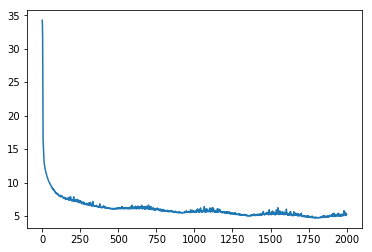

mean_absolute_error: 699.93%
Train on 16265 samples, validate on 1808 samples
Epoch 1/2000
12000/16265 [=====================>........] - ETA: 0s - loss: 34.0384 - mean_absolute_error: 34.0384

C:\Users\shaltaf\AppData\Local\conda\conda\envs\neural\lib\site-packages\keras\callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.108842). Check your callbacks.
  % delta_t_median)


16265/16265 [==============================] - 1s 54us/step - loss: 33.9372 - mean_absolute_error: 33.9372 - val_loss: 31.7126 - val_mean_absolute_error: 31.7126
Epoch 2/2000
16265/16265 [==============================] - 0s 7us/step - loss: 26.3381 - mean_absolute_error: 26.3381 - val_loss: 16.6694 - val_mean_absolute_error: 16.6694
Epoch 3/2000
16265/16265 [==============================] - 0s 7us/step - loss: 17.1448 - mean_absolute_error: 17.1448 - val_loss: 15.9058 - val_mean_absolute_error: 15.9058
Epoch 4/2000
16265/16265 [==============================] - 0s 7us/step - loss: 15.0600 - mean_absolute_error: 15.0600 - val_loss: 13.2817 - val_mean_absolute_error: 13.2817
Epoch 5/2000
16265/16265 [==============================] - 0s 7us/step - loss: 13.6881 - mean_absolute_error: 13.6881 - val_loss: 12.5591 - val_mean_absolute_error: 12.5591
Epoch 6/2000
16265/16265 [==============================] - 0s 7us/step - loss: 12.9545 - mean_absolute_error: 12.9545 - val_loss: 12.0257 - v

Epoch 49/2000
16265/16265 [==============================] - 0s 7us/step - loss: 8.6390 - mean_absolute_error: 8.6390 - val_loss: 8.7447 - val_mean_absolute_error: 8.7447
Epoch 50/2000
16265/16265 [==============================] - 0s 7us/step - loss: 8.6606 - mean_absolute_error: 8.6606 - val_loss: 8.1429 - val_mean_absolute_error: 8.1429
Epoch 51/2000
16265/16265 [==============================] - 0s 7us/step - loss: 8.5685 - mean_absolute_error: 8.5685 - val_loss: 8.0287 - val_mean_absolute_error: 8.0287
Epoch 52/2000
16265/16265 [==============================] - 0s 7us/step - loss: 8.5532 - mean_absolute_error: 8.5532 - val_loss: 8.5079 - val_mean_absolute_error: 8.5079
Epoch 53/2000
16265/16265 [==============================] - 0s 7us/step - loss: 8.7815 - mean_absolute_error: 8.7815 - val_loss: 8.0589 - val_mean_absolute_error: 8.0589
Epoch 54/2000
16265/16265 [==============================] - 0s 7us/step - loss: 8.5637 - mean_absolute_error: 8.5637 - val_loss: 8.1550 - val_me

Epoch 97/2000
16265/16265 [==============================] - 0s 7us/step - loss: 7.9700 - mean_absolute_error: 7.9700 - val_loss: 7.5663 - val_mean_absolute_error: 7.5663
Epoch 98/2000
16265/16265 [==============================] - 0s 7us/step - loss: 7.8549 - mean_absolute_error: 7.8549 - val_loss: 7.6279 - val_mean_absolute_error: 7.6279
Epoch 99/2000
16265/16265 [==============================] - 0s 7us/step - loss: 7.8645 - mean_absolute_error: 7.8645 - val_loss: 7.5321 - val_mean_absolute_error: 7.5321
Epoch 100/2000
16265/16265 [==============================] - 0s 7us/step - loss: 7.8312 - mean_absolute_error: 7.8312 - val_loss: 7.8836 - val_mean_absolute_error: 7.8836
Epoch 101/2000
16265/16265 [==============================] - 0s 7us/step - loss: 7.9309 - mean_absolute_error: 7.9309 - val_loss: 7.6184 - val_mean_absolute_error: 7.6184
Epoch 102/2000
16265/16265 [==============================] - 0s 8us/step - loss: 7.8006 - mean_absolute_error: 7.8006 - val_loss: 7.5992 - val

Epoch 192/2000
16265/16265 [==============================] - 0s 7us/step - loss: 7.2251 - mean_absolute_error: 7.2251 - val_loss: 7.1107 - val_mean_absolute_error: 7.1107
Epoch 193/2000
16265/16265 [==============================] - 0s 7us/step - loss: 7.2417 - mean_absolute_error: 7.2417 - val_loss: 7.2472 - val_mean_absolute_error: 7.2472
Epoch 194/2000
16265/16265 [==============================] - 0s 7us/step - loss: 7.2665 - mean_absolute_error: 7.2665 - val_loss: 7.1476 - val_mean_absolute_error: 7.1476
Epoch 195/2000
16265/16265 [==============================] - 0s 7us/step - loss: 7.2473 - mean_absolute_error: 7.2473 - val_loss: 7.1200 - val_mean_absolute_error: 7.1200
Epoch 196/2000
16265/16265 [==============================] - 0s 7us/step - loss: 7.2092 - mean_absolute_error: 7.2092 - val_loss: 7.1195 - val_mean_absolute_error: 7.1195
Epoch 197/2000
16265/16265 [==============================] - 0s 7us/step - loss: 7.1905 - mean_absolute_error: 7.1905 - val_loss: 7.1007 - 

Epoch 287/2000
16265/16265 [==============================] - 0s 7us/step - loss: 7.1110 - mean_absolute_error: 7.1110 - val_loss: 7.0213 - val_mean_absolute_error: 7.0213
Epoch 288/2000
16265/16265 [==============================] - 0s 7us/step - loss: 7.0623 - mean_absolute_error: 7.0623 - val_loss: 6.9890 - val_mean_absolute_error: 6.9890
Epoch 289/2000
16265/16265 [==============================] - 0s 7us/step - loss: 7.0322 - mean_absolute_error: 7.0322 - val_loss: 6.9756 - val_mean_absolute_error: 6.9756
Epoch 290/2000
16265/16265 [==============================] - 0s 7us/step - loss: 7.0390 - mean_absolute_error: 7.0390 - val_loss: 7.0551 - val_mean_absolute_error: 7.0551
Epoch 291/2000
16265/16265 [==============================] - 0s 7us/step - loss: 7.0733 - mean_absolute_error: 7.0733 - val_loss: 6.9609 - val_mean_absolute_error: 6.9609
Epoch 292/2000
16265/16265 [==============================] - 0s 7us/step - loss: 7.0487 - mean_absolute_error: 7.0487 - val_loss: 7.0127 - 

Epoch 382/2000
16265/16265 [==============================] - 0s 7us/step - loss: 6.8714 - mean_absolute_error: 6.8714 - val_loss: 6.9148 - val_mean_absolute_error: 6.9148
Epoch 383/2000
16265/16265 [==============================] - 0s 7us/step - loss: 6.9407 - mean_absolute_error: 6.9407 - val_loss: 6.8760 - val_mean_absolute_error: 6.8760
Epoch 384/2000
16265/16265 [==============================] - 0s 7us/step - loss: 6.9486 - mean_absolute_error: 6.9486 - val_loss: 6.8290 - val_mean_absolute_error: 6.8290
Epoch 385/2000
16265/16265 [==============================] - 0s 7us/step - loss: 6.9029 - mean_absolute_error: 6.9029 - val_loss: 6.7813 - val_mean_absolute_error: 6.7813
Epoch 386/2000
16265/16265 [==============================] - 0s 7us/step - loss: 6.8935 - mean_absolute_error: 6.8935 - val_loss: 7.1792 - val_mean_absolute_error: 7.1792
Epoch 387/2000
16265/16265 [==============================] - 0s 7us/step - loss: 7.0823 - mean_absolute_error: 7.0823 - val_loss: 6.9948 - 

Epoch 477/2000
16265/16265 [==============================] - 0s 8us/step - loss: 6.9234 - mean_absolute_error: 6.9234 - val_loss: 6.7222 - val_mean_absolute_error: 6.7222
Epoch 478/2000
16265/16265 [==============================] - 0s 8us/step - loss: 6.8506 - mean_absolute_error: 6.8506 - val_loss: 7.1978 - val_mean_absolute_error: 7.1978
Epoch 479/2000
16265/16265 [==============================] - 0s 8us/step - loss: 6.9227 - mean_absolute_error: 6.9227 - val_loss: 6.6859 - val_mean_absolute_error: 6.6859
Epoch 480/2000
16265/16265 [==============================] - 0s 8us/step - loss: 6.7503 - mean_absolute_error: 6.7503 - val_loss: 6.9489 - val_mean_absolute_error: 6.9489
Epoch 481/2000
16265/16265 [==============================] - 0s 8us/step - loss: 6.7782 - mean_absolute_error: 6.7782 - val_loss: 6.6257 - val_mean_absolute_error: 6.6257
Epoch 482/2000
16265/16265 [==============================] - 0s 8us/step - loss: 6.6610 - mean_absolute_error: 6.6610 - val_loss: 6.6654 - 

Epoch 572/2000
16265/16265 [==============================] - 0s 7us/step - loss: 6.4047 - mean_absolute_error: 6.4047 - val_loss: 6.5022 - val_mean_absolute_error: 6.5022
Epoch 573/2000
16265/16265 [==============================] - 0s 7us/step - loss: 6.3974 - mean_absolute_error: 6.3974 - val_loss: 6.4698 - val_mean_absolute_error: 6.4698
Epoch 574/2000
16265/16265 [==============================] - 0s 7us/step - loss: 6.3801 - mean_absolute_error: 6.3801 - val_loss: 6.5148 - val_mean_absolute_error: 6.5148
Epoch 575/2000
16265/16265 [==============================] - 0s 7us/step - loss: 6.4061 - mean_absolute_error: 6.4061 - val_loss: 6.5877 - val_mean_absolute_error: 6.5877
Epoch 576/2000
16265/16265 [==============================] - 0s 7us/step - loss: 6.4441 - mean_absolute_error: 6.4441 - val_loss: 6.7810 - val_mean_absolute_error: 6.7810
Epoch 577/2000
16265/16265 [==============================] - 0s 7us/step - loss: 6.4452 - mean_absolute_error: 6.4452 - val_loss: 6.4486 - 

Epoch 667/2000
16265/16265 [==============================] - 0s 7us/step - loss: 6.1634 - mean_absolute_error: 6.1634 - val_loss: 6.4319 - val_mean_absolute_error: 6.4319
Epoch 668/2000
16265/16265 [==============================] - 0s 7us/step - loss: 6.1693 - mean_absolute_error: 6.1693 - val_loss: 6.3262 - val_mean_absolute_error: 6.3262
Epoch 669/2000
16265/16265 [==============================] - 0s 7us/step - loss: 6.1728 - mean_absolute_error: 6.1728 - val_loss: 6.5752 - val_mean_absolute_error: 6.5752
Epoch 670/2000
16265/16265 [==============================] - 0s 7us/step - loss: 6.2663 - mean_absolute_error: 6.2663 - val_loss: 6.3849 - val_mean_absolute_error: 6.3849
Epoch 671/2000
16265/16265 [==============================] - 0s 7us/step - loss: 6.1900 - mean_absolute_error: 6.1900 - val_loss: 6.3712 - val_mean_absolute_error: 6.3712
Epoch 672/2000
16265/16265 [==============================] - 0s 7us/step - loss: 6.1709 - mean_absolute_error: 6.1709 - val_loss: 6.5047 - 

Epoch 762/2000
16265/16265 [==============================] - 0s 8us/step - loss: 6.2279 - mean_absolute_error: 6.2279 - val_loss: 6.3875 - val_mean_absolute_error: 6.3875
Epoch 763/2000
16265/16265 [==============================] - 0s 7us/step - loss: 6.1732 - mean_absolute_error: 6.1732 - val_loss: 6.5755 - val_mean_absolute_error: 6.5755
Epoch 764/2000
16265/16265 [==============================] - 0s 7us/step - loss: 6.2322 - mean_absolute_error: 6.2322 - val_loss: 6.3704 - val_mean_absolute_error: 6.3704
Epoch 765/2000
16265/16265 [==============================] - 0s 7us/step - loss: 6.1640 - mean_absolute_error: 6.1640 - val_loss: 6.3282 - val_mean_absolute_error: 6.3282
Epoch 766/2000
16265/16265 [==============================] - 0s 7us/step - loss: 6.1449 - mean_absolute_error: 6.1449 - val_loss: 6.3392 - val_mean_absolute_error: 6.3392
Epoch 767/2000
16265/16265 [==============================] - 0s 8us/step - loss: 6.1592 - mean_absolute_error: 6.1592 - val_loss: 6.3777 - 

Epoch 857/2000
16265/16265 [==============================] - 0s 7us/step - loss: 6.1741 - mean_absolute_error: 6.1741 - val_loss: 6.2928 - val_mean_absolute_error: 6.2928
Epoch 858/2000
16265/16265 [==============================] - 0s 7us/step - loss: 6.1993 - mean_absolute_error: 6.1993 - val_loss: 6.3642 - val_mean_absolute_error: 6.3642
Epoch 859/2000
16265/16265 [==============================] - 0s 8us/step - loss: 6.2088 - mean_absolute_error: 6.2088 - val_loss: 6.5956 - val_mean_absolute_error: 6.5956
Epoch 860/2000
16265/16265 [==============================] - 0s 7us/step - loss: 6.2250 - mean_absolute_error: 6.2250 - val_loss: 6.4154 - val_mean_absolute_error: 6.4154
Epoch 861/2000
16265/16265 [==============================] - 0s 7us/step - loss: 6.2621 - mean_absolute_error: 6.2621 - val_loss: 6.8752 - val_mean_absolute_error: 6.8752
Epoch 862/2000
16265/16265 [==============================] - 0s 7us/step - loss: 6.7545 - mean_absolute_error: 6.7545 - val_loss: 6.4860 - 

Epoch 952/2000
16265/16265 [==============================] - 0s 7us/step - loss: 6.2689 - mean_absolute_error: 6.2689 - val_loss: 6.5463 - val_mean_absolute_error: 6.5463
Epoch 953/2000
16265/16265 [==============================] - 0s 7us/step - loss: 6.2922 - mean_absolute_error: 6.2922 - val_loss: 6.4366 - val_mean_absolute_error: 6.4366
Epoch 954/2000
16265/16265 [==============================] - 0s 7us/step - loss: 6.2130 - mean_absolute_error: 6.2130 - val_loss: 6.2441 - val_mean_absolute_error: 6.2441
Epoch 955/2000
16265/16265 [==============================] - 0s 7us/step - loss: 6.0714 - mean_absolute_error: 6.0714 - val_loss: 6.2658 - val_mean_absolute_error: 6.2658
Epoch 956/2000
16265/16265 [==============================] - 0s 7us/step - loss: 6.1990 - mean_absolute_error: 6.1990 - val_loss: 6.5512 - val_mean_absolute_error: 6.5512
Epoch 957/2000
16265/16265 [==============================] - 0s 8us/step - loss: 6.2428 - mean_absolute_error: 6.2428 - val_loss: 6.5982 - 

16265/16265 [==============================] - 0s 8us/step - loss: 5.9512 - mean_absolute_error: 5.9512 - val_loss: 6.1207 - val_mean_absolute_error: 6.1207
Epoch 1047/2000
16265/16265 [==============================] - 0s 8us/step - loss: 5.9867 - mean_absolute_error: 5.9867 - val_loss: 6.2970 - val_mean_absolute_error: 6.2970
Epoch 1048/2000
16265/16265 [==============================] - 0s 7us/step - loss: 5.9621 - mean_absolute_error: 5.9621 - val_loss: 6.1421 - val_mean_absolute_error: 6.1421
Epoch 1049/2000
16265/16265 [==============================] - 0s 7us/step - loss: 5.9505 - mean_absolute_error: 5.9505 - val_loss: 6.2804 - val_mean_absolute_error: 6.2804
Epoch 1050/2000
16265/16265 [==============================] - 0s 7us/step - loss: 6.0103 - mean_absolute_error: 6.0103 - val_loss: 6.1470 - val_mean_absolute_error: 6.1470
Epoch 1051/2000
16265/16265 [==============================] - 0s 7us/step - loss: 6.0207 - mean_absolute_error: 6.0207 - val_loss: 6.1438 - val_mean_a

16265/16265 [==============================] - 0s 7us/step - loss: 5.7969 - mean_absolute_error: 5.7969 - val_loss: 6.0605 - val_mean_absolute_error: 6.0605
Epoch 1141/2000
16265/16265 [==============================] - 0s 7us/step - loss: 5.7642 - mean_absolute_error: 5.7642 - val_loss: 6.0687 - val_mean_absolute_error: 6.0687
Epoch 1142/2000
16265/16265 [==============================] - 0s 7us/step - loss: 5.7704 - mean_absolute_error: 5.7704 - val_loss: 6.1222 - val_mean_absolute_error: 6.1222
Epoch 1143/2000
16265/16265 [==============================] - 0s 7us/step - loss: 5.7811 - mean_absolute_error: 5.7811 - val_loss: 6.1039 - val_mean_absolute_error: 6.1039
Epoch 1144/2000
16265/16265 [==============================] - 0s 7us/step - loss: 5.7878 - mean_absolute_error: 5.7878 - val_loss: 6.0757 - val_mean_absolute_error: 6.0757
Epoch 1145/2000
16265/16265 [==============================] - 0s 7us/step - loss: 5.7993 - mean_absolute_error: 5.7993 - val_loss: 6.1965 - val_mean_a

16265/16265 [==============================] - 0s 7us/step - loss: 5.9347 - mean_absolute_error: 5.9347 - val_loss: 6.2118 - val_mean_absolute_error: 6.2118
Epoch 1235/2000
16265/16265 [==============================] - 0s 7us/step - loss: 5.9475 - mean_absolute_error: 5.9475 - val_loss: 6.2662 - val_mean_absolute_error: 6.2662
Epoch 1236/2000
16265/16265 [==============================] - 0s 7us/step - loss: 5.9022 - mean_absolute_error: 5.9022 - val_loss: 6.1570 - val_mean_absolute_error: 6.1570
Epoch 1237/2000
16265/16265 [==============================] - 0s 7us/step - loss: 5.9643 - mean_absolute_error: 5.9643 - val_loss: 6.1816 - val_mean_absolute_error: 6.1816
Epoch 1238/2000
16265/16265 [==============================] - 0s 7us/step - loss: 5.9937 - mean_absolute_error: 5.9937 - val_loss: 6.3006 - val_mean_absolute_error: 6.3006
Epoch 1239/2000
16265/16265 [==============================] - 0s 7us/step - loss: 6.0555 - mean_absolute_error: 6.0555 - val_loss: 6.2601 - val_mean_a

16265/16265 [==============================] - 0s 8us/step - loss: 6.0114 - mean_absolute_error: 6.0114 - val_loss: 6.2708 - val_mean_absolute_error: 6.2708
Epoch 1329/2000
16265/16265 [==============================] - 0s 8us/step - loss: 5.9515 - mean_absolute_error: 5.9515 - val_loss: 6.2563 - val_mean_absolute_error: 6.2563
Epoch 1330/2000
16265/16265 [==============================] - 0s 8us/step - loss: 5.9572 - mean_absolute_error: 5.9572 - val_loss: 6.2245 - val_mean_absolute_error: 6.2245
Epoch 1331/2000
16265/16265 [==============================] - 0s 7us/step - loss: 6.0550 - mean_absolute_error: 6.0550 - val_loss: 6.3746 - val_mean_absolute_error: 6.3746
Epoch 1332/2000
16265/16265 [==============================] - 0s 7us/step - loss: 6.1015 - mean_absolute_error: 6.1015 - val_loss: 6.2756 - val_mean_absolute_error: 6.2756
Epoch 1333/2000
16265/16265 [==============================] - 0s 7us/step - loss: 6.0725 - mean_absolute_error: 6.0725 - val_loss: 6.3298 - val_mean_a

16265/16265 [==============================] - 0s 7us/step - loss: 5.8690 - mean_absolute_error: 5.8690 - val_loss: 6.1183 - val_mean_absolute_error: 6.1183
Epoch 1423/2000
16265/16265 [==============================] - 0s 7us/step - loss: 5.8434 - mean_absolute_error: 5.8434 - val_loss: 6.1374 - val_mean_absolute_error: 6.1374
Epoch 1424/2000
16265/16265 [==============================] - 0s 7us/step - loss: 5.8510 - mean_absolute_error: 5.8510 - val_loss: 6.0745 - val_mean_absolute_error: 6.0745
Epoch 1425/2000
16265/16265 [==============================] - 0s 7us/step - loss: 5.8697 - mean_absolute_error: 5.8697 - val_loss: 6.1583 - val_mean_absolute_error: 6.1583
Epoch 1426/2000
16265/16265 [==============================] - 0s 7us/step - loss: 5.8407 - mean_absolute_error: 5.8407 - val_loss: 6.1118 - val_mean_absolute_error: 6.1118
Epoch 1427/2000
16265/16265 [==============================] - 0s 7us/step - loss: 5.8114 - mean_absolute_error: 5.8114 - val_loss: 6.4913 - val_mean_a

16265/16265 [==============================] - 0s 7us/step - loss: 5.6728 - mean_absolute_error: 5.6728 - val_loss: 6.0783 - val_mean_absolute_error: 6.0783
Epoch 1517/2000
16265/16265 [==============================] - 0s 7us/step - loss: 5.6609 - mean_absolute_error: 5.6609 - val_loss: 6.0651 - val_mean_absolute_error: 6.0651
Epoch 1518/2000
16265/16265 [==============================] - 0s 7us/step - loss: 5.7568 - mean_absolute_error: 5.7568 - val_loss: 6.0676 - val_mean_absolute_error: 6.0676
Epoch 1519/2000
16265/16265 [==============================] - 0s 7us/step - loss: 5.7611 - mean_absolute_error: 5.7611 - val_loss: 6.1718 - val_mean_absolute_error: 6.1718
Epoch 1520/2000
16265/16265 [==============================] - 0s 7us/step - loss: 5.7314 - mean_absolute_error: 5.7314 - val_loss: 6.0705 - val_mean_absolute_error: 6.0705
Epoch 1521/2000
16265/16265 [==============================] - 0s 7us/step - loss: 5.6627 - mean_absolute_error: 5.6627 - val_loss: 6.0886 - val_mean_a

16265/16265 [==============================] - 0s 7us/step - loss: 5.6036 - mean_absolute_error: 5.6036 - val_loss: 6.0628 - val_mean_absolute_error: 6.0628
Epoch 1611/2000
16265/16265 [==============================] - 0s 7us/step - loss: 5.6352 - mean_absolute_error: 5.6352 - val_loss: 6.0547 - val_mean_absolute_error: 6.0547
Epoch 1612/2000
16265/16265 [==============================] - 0s 7us/step - loss: 5.5988 - mean_absolute_error: 5.5988 - val_loss: 6.0377 - val_mean_absolute_error: 6.0377
Epoch 1613/2000
16265/16265 [==============================] - 0s 8us/step - loss: 5.6340 - mean_absolute_error: 5.6340 - val_loss: 6.0367 - val_mean_absolute_error: 6.0367
Epoch 1614/2000
16265/16265 [==============================] - 0s 7us/step - loss: 5.6212 - mean_absolute_error: 5.6212 - val_loss: 6.0776 - val_mean_absolute_error: 6.0776
Epoch 1615/2000
16265/16265 [==============================] - 0s 7us/step - loss: 5.6127 - mean_absolute_error: 5.6127 - val_loss: 6.0502 - val_mean_a

16265/16265 [==============================] - 0s 7us/step - loss: 5.7600 - mean_absolute_error: 5.7600 - val_loss: 6.2555 - val_mean_absolute_error: 6.2555
Epoch 1705/2000
16265/16265 [==============================] - 0s 7us/step - loss: 5.7802 - mean_absolute_error: 5.7802 - val_loss: 6.0844 - val_mean_absolute_error: 6.0844
Epoch 1706/2000
16265/16265 [==============================] - 0s 7us/step - loss: 5.8778 - mean_absolute_error: 5.8778 - val_loss: 6.1254 - val_mean_absolute_error: 6.1254
Epoch 1707/2000
16265/16265 [==============================] - 0s 8us/step - loss: 5.8501 - mean_absolute_error: 5.8501 - val_loss: 6.3399 - val_mean_absolute_error: 6.3399
Epoch 1708/2000
16265/16265 [==============================] - 0s 8us/step - loss: 5.8819 - mean_absolute_error: 5.8819 - val_loss: 6.3985 - val_mean_absolute_error: 6.3985
Epoch 1709/2000
16265/16265 [==============================] - 0s 7us/step - loss: 5.8728 - mean_absolute_error: 5.8728 - val_loss: 6.0792 - val_mean_a

16265/16265 [==============================] - 0s 11us/step - loss: 5.9131 - mean_absolute_error: 5.9131 - val_loss: 6.2344 - val_mean_absolute_error: 6.2344
Epoch 1799/2000
16265/16265 [==============================] - 0s 9us/step - loss: 5.8426 - mean_absolute_error: 5.8426 - val_loss: 6.2389 - val_mean_absolute_error: 6.2389
Epoch 1800/2000
16265/16265 [==============================] - 0s 8us/step - loss: 5.9606 - mean_absolute_error: 5.9606 - val_loss: 6.1588 - val_mean_absolute_error: 6.1588
Epoch 1801/2000
16265/16265 [==============================] - 0s 9us/step - loss: 5.9299 - mean_absolute_error: 5.9299 - val_loss: 6.4785 - val_mean_absolute_error: 6.4785
Epoch 1802/2000
16265/16265 [==============================] - 0s 9us/step - loss: 5.8526 - mean_absolute_error: 5.8526 - val_loss: 6.2475 - val_mean_absolute_error: 6.2475
Epoch 1803/2000
16265/16265 [==============================] - 0s 10us/step - loss: 5.7952 - mean_absolute_error: 5.7952 - val_loss: 6.1890 - val_mean

16265/16265 [==============================] - 0s 8us/step - loss: 5.6863 - mean_absolute_error: 5.6863 - val_loss: 6.1504 - val_mean_absolute_error: 6.1504
Epoch 1893/2000
16265/16265 [==============================] - 0s 8us/step - loss: 5.6921 - mean_absolute_error: 5.6921 - val_loss: 6.2173 - val_mean_absolute_error: 6.2173
Epoch 1894/2000
16265/16265 [==============================] - 0s 7us/step - loss: 5.6871 - mean_absolute_error: 5.6871 - val_loss: 6.2386 - val_mean_absolute_error: 6.2386
Epoch 1895/2000
16265/16265 [==============================] - 0s 8us/step - loss: 5.6484 - mean_absolute_error: 5.6484 - val_loss: 6.3323 - val_mean_absolute_error: 6.3323
Epoch 1896/2000
16265/16265 [==============================] - 0s 8us/step - loss: 5.6955 - mean_absolute_error: 5.6955 - val_loss: 6.7421 - val_mean_absolute_error: 6.7421
Epoch 1897/2000
16265/16265 [==============================] - 0s 9us/step - loss: 5.9101 - mean_absolute_error: 5.9101 - val_loss: 6.6246 - val_mean_a

16265/16265 [==============================] - 0s 10us/step - loss: 5.4831 - mean_absolute_error: 5.4831 - val_loss: 5.9760 - val_mean_absolute_error: 5.9760
Epoch 1987/2000
16265/16265 [==============================] - 0s 10us/step - loss: 5.4821 - mean_absolute_error: 5.4821 - val_loss: 6.0788 - val_mean_absolute_error: 6.0788
Epoch 1988/2000
16265/16265 [==============================] - 0s 9us/step - loss: 5.4601 - mean_absolute_error: 5.4601 - val_loss: 6.1159 - val_mean_absolute_error: 6.1159
Epoch 1989/2000
16265/16265 [==============================] - 0s 9us/step - loss: 5.4851 - mean_absolute_error: 5.4851 - val_loss: 6.0305 - val_mean_absolute_error: 6.0305
Epoch 1990/2000
16265/16265 [==============================] - 0s 9us/step - loss: 5.4797 - mean_absolute_error: 5.4797 - val_loss: 6.0357 - val_mean_absolute_error: 6.0357
Epoch 1991/2000
16265/16265 [==============================] - 0s 9us/step - loss: 5.4952 - mean_absolute_error: 5.4952 - val_loss: 6.0872 - val_mean

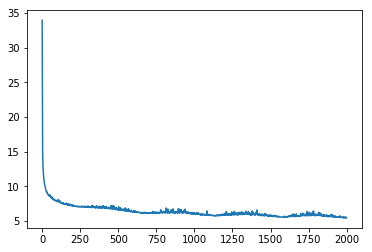

mean_absolute_error: 601.50%
Train on 16266 samples, validate on 1807 samples
Epoch 1/2000
12000/16266 [=====================>........] - ETA: 0s - loss: 34.3907 - mean_absolute_error: 34.3907

C:\Users\shaltaf\AppData\Local\conda\conda\envs\neural\lib\site-packages\keras\callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.105912). Check your callbacks.
  % delta_t_median)


16266/16266 [==============================] - 1s 55us/step - loss: 34.3959 - mean_absolute_error: 34.3959 - val_loss: 33.4988 - val_mean_absolute_error: 33.4988
Epoch 2/2000
16266/16266 [==============================] - 0s 8us/step - loss: 34.1364 - mean_absolute_error: 34.1364 - val_loss: 32.9501 - val_mean_absolute_error: 32.9501
Epoch 3/2000
16266/16266 [==============================] - 0s 9us/step - loss: 33.2175 - mean_absolute_error: 33.2175 - val_loss: 31.4663 - val_mean_absolute_error: 31.4663
Epoch 4/2000
16266/16266 [==============================] - 0s 10us/step - loss: 31.1285 - mean_absolute_error: 31.1285 - val_loss: 28.1889 - val_mean_absolute_error: 28.1889
Epoch 5/2000
16266/16266 [==============================] - 0s 9us/step - loss: 26.3105 - mean_absolute_error: 26.3105 - val_loss: 21.0400 - val_mean_absolute_error: 21.0400
Epoch 6/2000
16266/16266 [==============================] - 0s 9us/step - loss: 18.9293 - mean_absolute_error: 18.9293 - val_loss: 16.1076 - 

Epoch 48/2000
16266/16266 [==============================] - 0s 8us/step - loss: 10.0127 - mean_absolute_error: 10.0127 - val_loss: 10.1314 - val_mean_absolute_error: 10.1314
Epoch 49/2000
16266/16266 [==============================] - 0s 8us/step - loss: 9.9874 - mean_absolute_error: 9.9874 - val_loss: 10.1370 - val_mean_absolute_error: 10.1370
Epoch 50/2000
16266/16266 [==============================] - 0s 8us/step - loss: 9.8806 - mean_absolute_error: 9.8806 - val_loss: 10.0272 - val_mean_absolute_error: 10.0272
Epoch 51/2000
16266/16266 [==============================] - 0s 8us/step - loss: 9.8348 - mean_absolute_error: 9.8348 - val_loss: 10.0336 - val_mean_absolute_error: 10.0336
Epoch 52/2000
16266/16266 [==============================] - 0s 8us/step - loss: 9.7883 - mean_absolute_error: 9.7883 - val_loss: 9.9760 - val_mean_absolute_error: 9.9760
Epoch 53/2000
16266/16266 [==============================] - 0s 8us/step - loss: 9.7450 - mean_absolute_error: 9.7450 - val_loss: 9.966

Epoch 96/2000
16266/16266 [==============================] - 0s 9us/step - loss: 8.5036 - mean_absolute_error: 8.5036 - val_loss: 9.3386 - val_mean_absolute_error: 9.3386
Epoch 97/2000
16266/16266 [==============================] - 0s 9us/step - loss: 8.5954 - mean_absolute_error: 8.5954 - val_loss: 8.9514 - val_mean_absolute_error: 8.9514
Epoch 98/2000
16266/16266 [==============================] - 0s 9us/step - loss: 8.5791 - mean_absolute_error: 8.5791 - val_loss: 8.8454 - val_mean_absolute_error: 8.8454
Epoch 99/2000
16266/16266 [==============================] - 0s 9us/step - loss: 8.5809 - mean_absolute_error: 8.5809 - val_loss: 9.2076 - val_mean_absolute_error: 9.2076
Epoch 100/2000
16266/16266 [==============================] - 0s 9us/step - loss: 8.6294 - mean_absolute_error: 8.6294 - val_loss: 8.7791 - val_mean_absolute_error: 8.7791
Epoch 101/2000
16266/16266 [==============================] - 0s 9us/step - loss: 8.4439 - mean_absolute_error: 8.4439 - val_loss: 8.7600 - val_

16266/16266 [==============================] - 0s 9us/step - loss: 7.5490 - mean_absolute_error: 7.5490 - val_loss: 8.1346 - val_mean_absolute_error: 8.1346
Epoch 191/2000
16266/16266 [==============================] - 0s 19us/step - loss: 7.4704 - mean_absolute_error: 7.4704 - val_loss: 7.9875 - val_mean_absolute_error: 7.9875
Epoch 192/2000
16266/16266 [==============================] - 0s 14us/step - loss: 7.5273 - mean_absolute_error: 7.5273 - val_loss: 8.0342 - val_mean_absolute_error: 8.0342
Epoch 193/2000
16266/16266 [==============================] - 0s 14us/step - loss: 7.4780 - mean_absolute_error: 7.4780 - val_loss: 7.9085 - val_mean_absolute_error: 7.9085
Epoch 194/2000
16266/16266 [==============================] - 0s 12us/step - loss: 7.4113 - mean_absolute_error: 7.4113 - val_loss: 8.0556 - val_mean_absolute_error: 8.0556
Epoch 195/2000
16266/16266 [==============================] - 0s 10us/step - loss: 7.4733 - mean_absolute_error: 7.4733 - val_loss: 7.9542 - val_mean_a

16266/16266 [==============================] - 0s 11us/step - loss: 6.9079 - mean_absolute_error: 6.9079 - val_loss: 7.6236 - val_mean_absolute_error: 7.6236
Epoch 285/2000
16266/16266 [==============================] - 0s 8us/step - loss: 6.9768 - mean_absolute_error: 6.9768 - val_loss: 7.4872 - val_mean_absolute_error: 7.4872
Epoch 286/2000
16266/16266 [==============================] - 0s 8us/step - loss: 6.9042 - mean_absolute_error: 6.9042 - val_loss: 7.5448 - val_mean_absolute_error: 7.5448
Epoch 287/2000
16266/16266 [==============================] - 0s 8us/step - loss: 6.8635 - mean_absolute_error: 6.8635 - val_loss: 7.4386 - val_mean_absolute_error: 7.4386
Epoch 288/2000
16266/16266 [==============================] - 0s 8us/step - loss: 6.8848 - mean_absolute_error: 6.8848 - val_loss: 7.4238 - val_mean_absolute_error: 7.4238
Epoch 289/2000
16266/16266 [==============================] - 0s 8us/step - loss: 6.8954 - mean_absolute_error: 6.8954 - val_loss: 7.6391 - val_mean_absol

Epoch 332/2000
16266/16266 [==============================] - 0s 8us/step - loss: 6.6940 - mean_absolute_error: 6.6940 - val_loss: 7.2140 - val_mean_absolute_error: 7.2140
Epoch 333/2000
16266/16266 [==============================] - 0s 8us/step - loss: 6.7088 - mean_absolute_error: 6.7088 - val_loss: 7.4082 - val_mean_absolute_error: 7.4082
Epoch 334/2000
16266/16266 [==============================] - 0s 8us/step - loss: 6.6891 - mean_absolute_error: 6.6891 - val_loss: 7.3680 - val_mean_absolute_error: 7.3680
Epoch 335/2000
16266/16266 [==============================] - 0s 9us/step - loss: 6.7306 - mean_absolute_error: 6.7306 - val_loss: 7.6599 - val_mean_absolute_error: 7.6599
Epoch 336/2000
16266/16266 [==============================] - 0s 10us/step - loss: 6.8317 - mean_absolute_error: 6.8317 - val_loss: 7.4046 - val_mean_absolute_error: 7.4046
Epoch 337/2000
16266/16266 [==============================] - 0s 9us/step - loss: 6.7407 - mean_absolute_error: 6.7407 - val_loss: 7.4101 -

Epoch 427/2000
16266/16266 [==============================] - 0s 7us/step - loss: 6.3577 - mean_absolute_error: 6.3577 - val_loss: 7.1454 - val_mean_absolute_error: 7.1454
Epoch 428/2000
16266/16266 [==============================] - 0s 7us/step - loss: 6.3826 - mean_absolute_error: 6.3826 - val_loss: 7.0128 - val_mean_absolute_error: 7.0128
Epoch 429/2000
16266/16266 [==============================] - 0s 8us/step - loss: 6.3325 - mean_absolute_error: 6.3325 - val_loss: 7.1077 - val_mean_absolute_error: 7.1077
Epoch 430/2000
16266/16266 [==============================] - 0s 8us/step - loss: 6.3311 - mean_absolute_error: 6.3311 - val_loss: 7.0701 - val_mean_absolute_error: 7.0701
Epoch 431/2000
16266/16266 [==============================] - 0s 9us/step - loss: 6.3375 - mean_absolute_error: 6.3375 - val_loss: 7.0751 - val_mean_absolute_error: 7.0751
Epoch 432/2000
16266/16266 [==============================] - 0s 8us/step - loss: 6.3616 - mean_absolute_error: 6.3616 - val_loss: 6.9903 - 

Epoch 522/2000
16266/16266 [==============================] - 0s 8us/step - loss: 6.3954 - mean_absolute_error: 6.3954 - val_loss: 7.2039 - val_mean_absolute_error: 7.2039
Epoch 523/2000
16266/16266 [==============================] - 0s 8us/step - loss: 6.3407 - mean_absolute_error: 6.3407 - val_loss: 7.1002 - val_mean_absolute_error: 7.1002
Epoch 524/2000
16266/16266 [==============================] - 0s 8us/step - loss: 6.4406 - mean_absolute_error: 6.4406 - val_loss: 7.0253 - val_mean_absolute_error: 7.0253
Epoch 525/2000
16266/16266 [==============================] - 0s 8us/step - loss: 6.3560 - mean_absolute_error: 6.3560 - val_loss: 7.0626 - val_mean_absolute_error: 7.0626
Epoch 526/2000
16266/16266 [==============================] - 0s 8us/step - loss: 6.2560 - mean_absolute_error: 6.2560 - val_loss: 7.0756 - val_mean_absolute_error: 7.0756
Epoch 527/2000
16266/16266 [==============================] - 0s 8us/step - loss: 6.3161 - mean_absolute_error: 6.3161 - val_loss: 7.1452 - 

16266/16266 [==============================] - 0s 8us/step - loss: 6.2950 - mean_absolute_error: 6.2950 - val_loss: 6.9584 - val_mean_absolute_error: 6.9584
Epoch 617/2000
16266/16266 [==============================] - 0s 7us/step - loss: 6.2772 - mean_absolute_error: 6.2772 - val_loss: 7.0658 - val_mean_absolute_error: 7.0658
Epoch 618/2000
16266/16266 [==============================] - 0s 7us/step - loss: 6.2714 - mean_absolute_error: 6.2714 - val_loss: 6.9593 - val_mean_absolute_error: 6.9593
Epoch 619/2000
16266/16266 [==============================] - 0s 7us/step - loss: 6.2486 - mean_absolute_error: 6.2486 - val_loss: 7.2612 - val_mean_absolute_error: 7.2612
Epoch 620/2000
16266/16266 [==============================] - 0s 8us/step - loss: 6.3944 - mean_absolute_error: 6.3944 - val_loss: 6.9955 - val_mean_absolute_error: 6.9955
Epoch 621/2000
16266/16266 [==============================] - 0s 7us/step - loss: 6.3318 - mean_absolute_error: 6.3318 - val_loss: 7.2267 - val_mean_absolu

Epoch 664/2000
16266/16266 [==============================] - 0s 7us/step - loss: 6.4016 - mean_absolute_error: 6.4016 - val_loss: 7.3921 - val_mean_absolute_error: 7.3921
Epoch 665/2000
16266/16266 [==============================] - 0s 7us/step - loss: 6.3246 - mean_absolute_error: 6.3246 - val_loss: 6.9556 - val_mean_absolute_error: 6.9556
Epoch 666/2000
16266/16266 [==============================] - 0s 7us/step - loss: 6.1822 - mean_absolute_error: 6.1822 - val_loss: 7.1276 - val_mean_absolute_error: 7.1276
Epoch 667/2000
16266/16266 [==============================] - 0s 7us/step - loss: 6.2999 - mean_absolute_error: 6.2999 - val_loss: 6.9501 - val_mean_absolute_error: 6.9501
Epoch 668/2000
16266/16266 [==============================] - 0s 7us/step - loss: 6.2539 - mean_absolute_error: 6.2539 - val_loss: 7.0250 - val_mean_absolute_error: 7.0250
Epoch 669/2000
16266/16266 [==============================] - 0s 7us/step - loss: 6.2228 - mean_absolute_error: 6.2228 - val_loss: 7.1412 - 

Epoch 759/2000
16266/16266 [==============================] - 0s 7us/step - loss: 6.3148 - mean_absolute_error: 6.3148 - val_loss: 7.4014 - val_mean_absolute_error: 7.4014
Epoch 760/2000
16266/16266 [==============================] - 0s 8us/step - loss: 6.2212 - mean_absolute_error: 6.2212 - val_loss: 7.1196 - val_mean_absolute_error: 7.1196
Epoch 761/2000
16266/16266 [==============================] - 0s 7us/step - loss: 6.2046 - mean_absolute_error: 6.2046 - val_loss: 7.0083 - val_mean_absolute_error: 7.0083
Epoch 762/2000
16266/16266 [==============================] - 0s 7us/step - loss: 6.1560 - mean_absolute_error: 6.1560 - val_loss: 6.8376 - val_mean_absolute_error: 6.8376
Epoch 763/2000
16266/16266 [==============================] - 0s 7us/step - loss: 6.0631 - mean_absolute_error: 6.0631 - val_loss: 6.9539 - val_mean_absolute_error: 6.9539
Epoch 764/2000
16266/16266 [==============================] - 0s 7us/step - loss: 6.0682 - mean_absolute_error: 6.0682 - val_loss: 6.8330 - 

Epoch 854/2000
16266/16266 [==============================] - 0s 7us/step - loss: 5.8875 - mean_absolute_error: 5.8875 - val_loss: 6.8121 - val_mean_absolute_error: 6.8121
Epoch 855/2000
16266/16266 [==============================] - 0s 7us/step - loss: 5.8782 - mean_absolute_error: 5.8782 - val_loss: 6.6709 - val_mean_absolute_error: 6.6709
Epoch 856/2000
16266/16266 [==============================] - 0s 7us/step - loss: 5.8426 - mean_absolute_error: 5.8426 - val_loss: 6.7369 - val_mean_absolute_error: 6.7369
Epoch 857/2000
16266/16266 [==============================] - 0s 7us/step - loss: 5.8378 - mean_absolute_error: 5.8378 - val_loss: 6.6933 - val_mean_absolute_error: 6.6933
Epoch 858/2000
16266/16266 [==============================] - 0s 7us/step - loss: 5.8507 - mean_absolute_error: 5.8507 - val_loss: 6.8565 - val_mean_absolute_error: 6.8565
Epoch 859/2000
16266/16266 [==============================] - 0s 7us/step - loss: 5.9068 - mean_absolute_error: 5.9068 - val_loss: 6.7287 - 

Epoch 949/2000
16266/16266 [==============================] - 0s 8us/step - loss: 5.8215 - mean_absolute_error: 5.8215 - val_loss: 6.6816 - val_mean_absolute_error: 6.6816
Epoch 950/2000
16266/16266 [==============================] - ETA: 0s - loss: 5.8346 - mean_absolute_error: 5.834 - 0s 8us/step - loss: 5.7841 - mean_absolute_error: 5.7841 - val_loss: 6.6787 - val_mean_absolute_error: 6.6787
Epoch 951/2000
16266/16266 [==============================] - 0s 9us/step - loss: 5.8356 - mean_absolute_error: 5.8356 - val_loss: 6.7985 - val_mean_absolute_error: 6.7985
Epoch 952/2000
16266/16266 [==============================] - 0s 9us/step - loss: 5.8385 - mean_absolute_error: 5.8385 - val_loss: 6.8891 - val_mean_absolute_error: 6.8891
Epoch 953/2000
16266/16266 [==============================] - 0s 8us/step - loss: 5.8647 - mean_absolute_error: 5.8647 - val_loss: 6.6771 - val_mean_absolute_error: 6.6771
Epoch 954/2000
16266/16266 [==============================] - 0s 7us/step - loss: 5.77

16266/16266 [==============================] - 0s 8us/step - loss: 6.0167 - mean_absolute_error: 6.0167 - val_loss: 6.6708 - val_mean_absolute_error: 6.6708
Epoch 1044/2000
16266/16266 [==============================] - 0s 8us/step - loss: 5.8696 - mean_absolute_error: 5.8696 - val_loss: 6.7841 - val_mean_absolute_error: 6.7841
Epoch 1045/2000
16266/16266 [==============================] - 0s 8us/step - loss: 5.8743 - mean_absolute_error: 5.8743 - val_loss: 6.7523 - val_mean_absolute_error: 6.7523
Epoch 1046/2000
16266/16266 [==============================] - 0s 7us/step - loss: 5.8968 - mean_absolute_error: 5.8968 - val_loss: 6.7855 - val_mean_absolute_error: 6.7855
Epoch 1047/2000
16266/16266 [==============================] - 0s 11us/step - loss: 5.8475 - mean_absolute_error: 5.8475 - val_loss: 6.7502 - val_mean_absolute_error: 6.7502
Epoch 1048/2000
16266/16266 [==============================] - 0s 10us/step - loss: 5.8510 - mean_absolute_error: 5.8510 - val_loss: 7.2315 - val_mean

16266/16266 [==============================] - 0s 7us/step - loss: 6.2369 - mean_absolute_error: 6.2369 - val_loss: 6.8607 - val_mean_absolute_error: 6.8607
Epoch 1091/2000
16266/16266 [==============================] - 0s 7us/step - loss: 5.9370 - mean_absolute_error: 5.9370 - val_loss: 6.9089 - val_mean_absolute_error: 6.9089
Epoch 1092/2000
16266/16266 [==============================] - 0s 7us/step - loss: 6.1284 - mean_absolute_error: 6.1284 - val_loss: 6.9852 - val_mean_absolute_error: 6.9852
Epoch 1093/2000
16266/16266 [==============================] - 0s 7us/step - loss: 6.0579 - mean_absolute_error: 6.0579 - val_loss: 6.9241 - val_mean_absolute_error: 6.9241
Epoch 1094/2000
16266/16266 [==============================] - 0s 7us/step - loss: 5.9410 - mean_absolute_error: 5.9410 - val_loss: 6.8190 - val_mean_absolute_error: 6.8190
Epoch 1095/2000
16266/16266 [==============================] - 0s 8us/step - loss: 5.9843 - mean_absolute_error: 5.9843 - val_loss: 6.7587 - val_mean_a

16266/16266 [==============================] - 0s 14us/step - loss: 5.8526 - mean_absolute_error: 5.8526 - val_loss: 6.6392 - val_mean_absolute_error: 6.6392
Epoch 1185/2000
16266/16266 [==============================] - 0s 8us/step - loss: 5.8074 - mean_absolute_error: 5.8074 - val_loss: 7.4159 - val_mean_absolute_error: 7.4159
Epoch 1186/2000
16266/16266 [==============================] - 0s 9us/step - loss: 6.1241 - mean_absolute_error: 6.1241 - val_loss: 8.0252 - val_mean_absolute_error: 8.0252
Epoch 1187/2000
16266/16266 [==============================] - 0s 10us/step - loss: 6.2681 - mean_absolute_error: 6.2681 - val_loss: 6.8039 - val_mean_absolute_error: 6.8039
Epoch 1188/2000
16266/16266 [==============================] - 0s 7us/step - loss: 5.8077 - mean_absolute_error: 5.8077 - val_loss: 6.7358 - val_mean_absolute_error: 6.7358
Epoch 1189/2000
16266/16266 [==============================] - 0s 8us/step - loss: 5.7949 - mean_absolute_error: 5.7949 - val_loss: 6.7159 - val_mean

16266/16266 [==============================] - 0s 8us/step - loss: 5.6259 - mean_absolute_error: 5.6259 - val_loss: 6.6796 - val_mean_absolute_error: 6.6796
Epoch 1279/2000
16266/16266 [==============================] - 0s 8us/step - loss: 5.6688 - mean_absolute_error: 5.6688 - val_loss: 6.6124 - val_mean_absolute_error: 6.6124
Epoch 1280/2000
16266/16266 [==============================] - 0s 10us/step - loss: 5.6104 - mean_absolute_error: 5.6104 - val_loss: 6.5603 - val_mean_absolute_error: 6.5603
Epoch 1281/2000
16266/16266 [==============================] - 0s 9us/step - loss: 5.6188 - mean_absolute_error: 5.6188 - val_loss: 6.6475 - val_mean_absolute_error: 6.6475
Epoch 1282/2000
16266/16266 [==============================] - 0s 9us/step - loss: 5.6767 - mean_absolute_error: 5.6767 - val_loss: 6.6196 - val_mean_absolute_error: 6.6196
Epoch 1283/2000
16266/16266 [==============================] - 0s 9us/step - loss: 5.5938 - mean_absolute_error: 5.5938 - val_loss: 6.7981 - val_mean_

16266/16266 [==============================] - 0s 8us/step - loss: 5.4516 - mean_absolute_error: 5.4516 - val_loss: 6.5093 - val_mean_absolute_error: 6.5093
Epoch 1373/2000
16266/16266 [==============================] - 0s 8us/step - loss: 5.4532 - mean_absolute_error: 5.4532 - val_loss: 6.5132 - val_mean_absolute_error: 6.5132
Epoch 1374/2000
16266/16266 [==============================] - 0s 8us/step - loss: 5.4717 - mean_absolute_error: 5.4717 - val_loss: 6.5247 - val_mean_absolute_error: 6.5247
Epoch 1375/2000
16266/16266 [==============================] - 0s 8us/step - loss: 5.4579 - mean_absolute_error: 5.4579 - val_loss: 6.5118 - val_mean_absolute_error: 6.5118
Epoch 1376/2000
16266/16266 [==============================] - 0s 8us/step - loss: 5.4430 - mean_absolute_error: 5.4430 - val_loss: 6.6050 - val_mean_absolute_error: 6.6050
Epoch 1377/2000
16266/16266 [==============================] - 0s 7us/step - loss: 5.4579 - mean_absolute_error: 5.4579 - val_loss: 6.5292 - val_mean_a

16266/16266 [==============================] - 0s 7us/step - loss: 5.5320 - mean_absolute_error: 5.5320 - val_loss: 6.5918 - val_mean_absolute_error: 6.5918
Epoch 1467/2000
16266/16266 [==============================] - 0s 8us/step - loss: 5.5567 - mean_absolute_error: 5.5567 - val_loss: 6.5841 - val_mean_absolute_error: 6.5841
Epoch 1468/2000
16266/16266 [==============================] - 0s 8us/step - loss: 5.6475 - mean_absolute_error: 5.6475 - val_loss: 6.9292 - val_mean_absolute_error: 6.9292
Epoch 1469/2000
16266/16266 [==============================] - 0s 8us/step - loss: 5.7532 - mean_absolute_error: 5.7532 - val_loss: 6.8570 - val_mean_absolute_error: 6.8570
Epoch 1470/2000
16266/16266 [==============================] - 0s 7us/step - loss: 5.8497 - mean_absolute_error: 5.8497 - val_loss: 6.6864 - val_mean_absolute_error: 6.6864
Epoch 1471/2000
16266/16266 [==============================] - 0s 8us/step - loss: 5.7502 - mean_absolute_error: 5.7502 - val_loss: 6.6888 - val_mean_a

16266/16266 [==============================] - 0s 8us/step - loss: 5.7831 - mean_absolute_error: 5.7831 - val_loss: 6.7267 - val_mean_absolute_error: 6.7267
Epoch 1561/2000
16266/16266 [==============================] - 0s 8us/step - loss: 5.7550 - mean_absolute_error: 5.7550 - val_loss: 6.6479 - val_mean_absolute_error: 6.6479
Epoch 1562/2000
16266/16266 [==============================] - 0s 7us/step - loss: 5.6081 - mean_absolute_error: 5.6081 - val_loss: 6.6602 - val_mean_absolute_error: 6.6602
Epoch 1563/2000
16266/16266 [==============================] - 0s 8us/step - loss: 5.7550 - mean_absolute_error: 5.7550 - val_loss: 6.6402 - val_mean_absolute_error: 6.6402
Epoch 1564/2000
16266/16266 [==============================] - 0s 7us/step - loss: 5.7288 - mean_absolute_error: 5.7288 - val_loss: 7.0184 - val_mean_absolute_error: 7.0184
Epoch 1565/2000
16266/16266 [==============================] - 0s 8us/step - loss: 5.8550 - mean_absolute_error: 5.8550 - val_loss: 6.8124 - val_mean_a

16266/16266 [==============================] - 0s 8us/step - loss: 5.7558 - mean_absolute_error: 5.7558 - val_loss: 6.6906 - val_mean_absolute_error: 6.6906
Epoch 1655/2000
16266/16266 [==============================] - 0s 8us/step - loss: 5.5752 - mean_absolute_error: 5.5752 - val_loss: 6.6852 - val_mean_absolute_error: 6.6852
Epoch 1656/2000
16266/16266 [==============================] - 0s 7us/step - loss: 5.5051 - mean_absolute_error: 5.5051 - val_loss: 6.5334 - val_mean_absolute_error: 6.5334
Epoch 1657/2000
16266/16266 [==============================] - 0s 8us/step - loss: 5.4827 - mean_absolute_error: 5.4827 - val_loss: 6.6111 - val_mean_absolute_error: 6.6111
Epoch 1658/2000
16266/16266 [==============================] - 0s 7us/step - loss: 5.5467 - mean_absolute_error: 5.5467 - val_loss: 6.5220 - val_mean_absolute_error: 6.5220
Epoch 1659/2000
16266/16266 [==============================] - 0s 8us/step - loss: 5.4607 - mean_absolute_error: 5.4607 - val_loss: 6.6472 - val_mean_a

16266/16266 [==============================] - 0s 8us/step - loss: 5.4265 - mean_absolute_error: 5.4265 - val_loss: 6.6684 - val_mean_absolute_error: 6.6684
Epoch 1749/2000
16266/16266 [==============================] - 0s 8us/step - loss: 5.5304 - mean_absolute_error: 5.5304 - val_loss: 6.7014 - val_mean_absolute_error: 6.7014
Epoch 1750/2000
16266/16266 [==============================] - 0s 8us/step - loss: 5.4067 - mean_absolute_error: 5.4067 - val_loss: 6.4822 - val_mean_absolute_error: 6.4822
Epoch 1751/2000
16266/16266 [==============================] - 0s 7us/step - loss: 5.3537 - mean_absolute_error: 5.3537 - val_loss: 6.5963 - val_mean_absolute_error: 6.5963
Epoch 1752/2000
16266/16266 [==============================] - 0s 7us/step - loss: 5.4746 - mean_absolute_error: 5.4746 - val_loss: 6.5828 - val_mean_absolute_error: 6.5828
Epoch 1753/2000
16266/16266 [==============================] - 0s 8us/step - loss: 5.3590 - mean_absolute_error: 5.3590 - val_loss: 6.4406 - val_mean_a

16266/16266 [==============================] - 0s 8us/step - loss: 5.2337 - mean_absolute_error: 5.2337 - val_loss: 6.4828 - val_mean_absolute_error: 6.4828
Epoch 1843/2000
16266/16266 [==============================] - 0s 8us/step - loss: 5.2284 - mean_absolute_error: 5.2284 - val_loss: 6.5712 - val_mean_absolute_error: 6.5712
Epoch 1844/2000
16266/16266 [==============================] - 0s 8us/step - loss: 5.3009 - mean_absolute_error: 5.3009 - val_loss: 6.6505 - val_mean_absolute_error: 6.6505
Epoch 1845/2000
16266/16266 [==============================] - 0s 8us/step - loss: 5.3990 - mean_absolute_error: 5.3990 - val_loss: 6.4993 - val_mean_absolute_error: 6.4993
Epoch 1846/2000
16266/16266 [==============================] - 0s 7us/step - loss: 5.2607 - mean_absolute_error: 5.2607 - val_loss: 6.5131 - val_mean_absolute_error: 6.5131
Epoch 1847/2000
16266/16266 [==============================] - 0s 8us/step - loss: 5.2262 - mean_absolute_error: 5.2262 - val_loss: 6.4952 - val_mean_a

16266/16266 [==============================] - 0s 8us/step - loss: 5.3731 - mean_absolute_error: 5.3731 - val_loss: 6.4922 - val_mean_absolute_error: 6.4922
Epoch 1937/2000
16266/16266 [==============================] - 0s 7us/step - loss: 5.4173 - mean_absolute_error: 5.4173 - val_loss: 6.7725 - val_mean_absolute_error: 6.7725
Epoch 1938/2000
16266/16266 [==============================] - 0s 8us/step - loss: 5.4761 - mean_absolute_error: 5.4761 - val_loss: 7.0391 - val_mean_absolute_error: 7.0391
Epoch 1939/2000
16266/16266 [==============================] - 0s 7us/step - loss: 5.4811 - mean_absolute_error: 5.4811 - val_loss: 6.8719 - val_mean_absolute_error: 6.8719
Epoch 1940/2000
16266/16266 [==============================] - 0s 8us/step - loss: 5.4916 - mean_absolute_error: 5.4916 - val_loss: 7.0398 - val_mean_absolute_error: 7.0398
Epoch 1941/2000
16266/16266 [==============================] - 0s 8us/step - loss: 5.7745 - mean_absolute_error: 5.7745 - val_loss: 7.3735 - val_mean_a

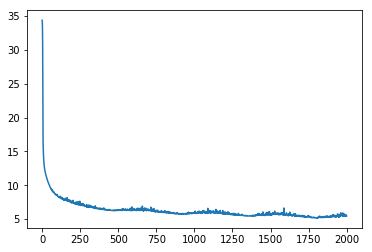

mean_absolute_error: 677.23%
Train on 16266 samples, validate on 1807 samples
Epoch 1/2000
12000/16266 [=====================>........] - ETA: 0s - loss: 34.2224 - mean_absolute_error: 34.2224

C:\Users\shaltaf\AppData\Local\conda\conda\envs\neural\lib\site-packages\keras\callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.113249). Check your callbacks.
  % delta_t_median)


16266/16266 [==============================] - 1s 57us/step - loss: 34.0196 - mean_absolute_error: 34.0196 - val_loss: 32.4857 - val_mean_absolute_error: 32.4857
Epoch 2/2000
16266/16266 [==============================] - 0s 8us/step - loss: 27.4747 - mean_absolute_error: 27.4747 - val_loss: 17.4512 - val_mean_absolute_error: 17.4512
Epoch 3/2000
16266/16266 [==============================] - 0s 8us/step - loss: 17.3324 - mean_absolute_error: 17.3324 - val_loss: 15.8757 - val_mean_absolute_error: 15.8757
Epoch 4/2000
16266/16266 [==============================] - 0s 8us/step - loss: 15.0167 - mean_absolute_error: 15.0167 - val_loss: 13.8164 - val_mean_absolute_error: 13.8164
Epoch 5/2000
16266/16266 [==============================] - 0s 8us/step - loss: 13.7624 - mean_absolute_error: 13.7624 - val_loss: 13.5520 - val_mean_absolute_error: 13.5520
Epoch 6/2000
16266/16266 [==============================] - 0s 8us/step - loss: 13.0170 - mean_absolute_error: 13.0170 - val_loss: 12.6866 - v

Epoch 96/2000
16266/16266 [==============================] - 0s 8us/step - loss: 8.1386 - mean_absolute_error: 8.1386 - val_loss: 8.6617 - val_mean_absolute_error: 8.6617
Epoch 97/2000
16266/16266 [==============================] - 0s 11us/step - loss: 8.1638 - mean_absolute_error: 8.1638 - val_loss: 8.3084 - val_mean_absolute_error: 8.3084
Epoch 98/2000
16266/16266 [==============================] - 0s 9us/step - loss: 8.0199 - mean_absolute_error: 8.0199 - val_loss: 8.2883 - val_mean_absolute_error: 8.2883
Epoch 99/2000
16266/16266 [==============================] - 0s 11us/step - loss: 7.9664 - mean_absolute_error: 7.9664 - val_loss: 8.3252 - val_mean_absolute_error: 8.3252
Epoch 100/2000
16266/16266 [==============================] - 0s 10us/step - loss: 8.0315 - mean_absolute_error: 8.0315 - val_loss: 8.3001 - val_mean_absolute_error: 8.3001
Epoch 101/2000
16266/16266 [==============================] - 0s 10us/step - loss: 7.9642 - mean_absolute_error: 7.9642 - val_loss: 8.2501 - 

Epoch 191/2000
16266/16266 [==============================] - 0s 8us/step - loss: 7.3825 - mean_absolute_error: 7.3825 - val_loss: 7.6218 - val_mean_absolute_error: 7.6218
Epoch 192/2000
16266/16266 [==============================] - 0s 8us/step - loss: 7.3738 - mean_absolute_error: 7.3738 - val_loss: 7.6813 - val_mean_absolute_error: 7.6813
Epoch 193/2000
16266/16266 [==============================] - 0s 8us/step - loss: 7.3610 - mean_absolute_error: 7.3610 - val_loss: 7.6299 - val_mean_absolute_error: 7.6299
Epoch 194/2000
16266/16266 [==============================] - 0s 8us/step - loss: 7.3591 - mean_absolute_error: 7.3591 - val_loss: 7.6377 - val_mean_absolute_error: 7.6377
Epoch 195/2000
16266/16266 [==============================] - 0s 8us/step - loss: 7.3516 - mean_absolute_error: 7.3516 - val_loss: 7.7684 - val_mean_absolute_error: 7.7684
Epoch 196/2000
16266/16266 [==============================] - 0s 8us/step - loss: 7.4102 - mean_absolute_error: 7.4102 - val_loss: 7.8687 - 

16266/16266 [==============================] - 0s 9us/step - loss: 7.1374 - mean_absolute_error: 7.1374 - val_loss: 7.4428 - val_mean_absolute_error: 7.4428
Epoch 286/2000
16266/16266 [==============================] - 0s 9us/step - loss: 7.1169 - mean_absolute_error: 7.1169 - val_loss: 7.5113 - val_mean_absolute_error: 7.5113
Epoch 287/2000
16266/16266 [==============================] - 0s 8us/step - loss: 7.1389 - mean_absolute_error: 7.1389 - val_loss: 7.4295 - val_mean_absolute_error: 7.4295
Epoch 288/2000
16266/16266 [==============================] - 0s 8us/step - loss: 7.1311 - mean_absolute_error: 7.1311 - val_loss: 7.3812 - val_mean_absolute_error: 7.3812
Epoch 289/2000
16266/16266 [==============================] - ETA: 0s - loss: 7.1442 - mean_absolute_error: 7.144 - 0s 8us/step - loss: 7.1262 - mean_absolute_error: 7.1262 - val_loss: 7.4255 - val_mean_absolute_error: 7.4255
Epoch 290/2000
16266/16266 [==============================] - 0s 11us/step - loss: 7.1233 - mean_abso

16266/16266 [==============================] - 0s 8us/step - loss: 7.0177 - mean_absolute_error: 7.0177 - val_loss: 7.5365 - val_mean_absolute_error: 7.5365
Epoch 380/2000
16266/16266 [==============================] - 0s 8us/step - loss: 6.9869 - mean_absolute_error: 6.9869 - val_loss: 7.4061 - val_mean_absolute_error: 7.4061
Epoch 381/2000
16266/16266 [==============================] - 0s 8us/step - loss: 7.0689 - mean_absolute_error: 7.0689 - val_loss: 7.2434 - val_mean_absolute_error: 7.2434
Epoch 382/2000
16266/16266 [==============================] - 0s 8us/step - loss: 6.9782 - mean_absolute_error: 6.9782 - val_loss: 7.3781 - val_mean_absolute_error: 7.3781
Epoch 383/2000
16266/16266 [==============================] - 0s 8us/step - loss: 6.9649 - mean_absolute_error: 6.9649 - val_loss: 7.3553 - val_mean_absolute_error: 7.3553
Epoch 384/2000
16266/16266 [==============================] - 0s 8us/step - loss: 6.8837 - mean_absolute_error: 6.8837 - val_loss: 7.5037 - val_mean_absolu

Epoch 474/2000
16266/16266 [==============================] - 0s 7us/step - loss: 6.9343 - mean_absolute_error: 6.9343 - val_loss: 7.0783 - val_mean_absolute_error: 7.0783
Epoch 475/2000
16266/16266 [==============================] - 0s 10us/step - loss: 6.7771 - mean_absolute_error: 6.7771 - val_loss: 7.2297 - val_mean_absolute_error: 7.2297
Epoch 476/2000
16266/16266 [==============================] - 0s 11us/step - loss: 6.6616 - mean_absolute_error: 6.6616 - val_loss: 6.9925 - val_mean_absolute_error: 6.9925
Epoch 477/2000
16266/16266 [==============================] - 0s 8us/step - loss: 6.6581 - mean_absolute_error: 6.6581 - val_loss: 7.0761 - val_mean_absolute_error: 7.0761
Epoch 478/2000
16266/16266 [==============================] - 0s 8us/step - loss: 6.6451 - mean_absolute_error: 6.6451 - val_loss: 7.0754 - val_mean_absolute_error: 7.0754
Epoch 479/2000
16266/16266 [==============================] - 0s 8us/step - loss: 6.6770 - mean_absolute_error: 6.6770 - val_loss: 6.9841 

16266/16266 [==============================] - 0s 8us/step - loss: 6.2839 - mean_absolute_error: 6.2839 - val_loss: 6.9642 - val_mean_absolute_error: 6.9642
Epoch 569/2000
16266/16266 [==============================] - 0s 8us/step - loss: 6.4155 - mean_absolute_error: 6.4155 - val_loss: 7.0154 - val_mean_absolute_error: 7.0154
Epoch 570/2000
16266/16266 [==============================] - 0s 8us/step - loss: 6.3370 - mean_absolute_error: 6.3370 - val_loss: 6.8512 - val_mean_absolute_error: 6.8512
Epoch 571/2000
16266/16266 [==============================] - 0s 8us/step - loss: 6.3052 - mean_absolute_error: 6.3052 - val_loss: 6.8557 - val_mean_absolute_error: 6.8557
Epoch 572/2000
16266/16266 [==============================] - 0s 7us/step - loss: 6.3143 - mean_absolute_error: 6.3143 - val_loss: 6.8757 - val_mean_absolute_error: 6.8757
Epoch 573/2000
16266/16266 [==============================] - 0s 8us/step - loss: 6.2695 - mean_absolute_error: 6.2695 - val_loss: 6.8796 - val_mean_absolu

Epoch 616/2000
16266/16266 [==============================] - 0s 7us/step - loss: 6.1812 - mean_absolute_error: 6.1812 - val_loss: 6.7519 - val_mean_absolute_error: 6.7519
Epoch 617/2000
16266/16266 [==============================] - 0s 8us/step - loss: 6.1370 - mean_absolute_error: 6.1370 - val_loss: 6.7928 - val_mean_absolute_error: 6.7928
Epoch 618/2000
16266/16266 [==============================] - 0s 7us/step - loss: 6.1519 - mean_absolute_error: 6.1519 - val_loss: 6.8310 - val_mean_absolute_error: 6.8310
Epoch 619/2000
16266/16266 [==============================] - 0s 7us/step - loss: 6.1696 - mean_absolute_error: 6.1696 - val_loss: 6.9002 - val_mean_absolute_error: 6.9002
Epoch 620/2000
16266/16266 [==============================] - 0s 7us/step - loss: 6.2345 - mean_absolute_error: 6.2345 - val_loss: 6.9686 - val_mean_absolute_error: 6.9686
Epoch 621/2000
16266/16266 [==============================] - 0s 7us/step - loss: 6.2711 - mean_absolute_error: 6.2711 - val_loss: 6.7440 - 

16266/16266 [==============================] - 0s 7us/step - loss: 5.9947 - mean_absolute_error: 5.9947 - val_loss: 6.6757 - val_mean_absolute_error: 6.6757
Epoch 711/2000
16266/16266 [==============================] - 0s 7us/step - loss: 6.0014 - mean_absolute_error: 6.0014 - val_loss: 6.6927 - val_mean_absolute_error: 6.6927
Epoch 712/2000
16266/16266 [==============================] - 0s 7us/step - loss: 6.0175 - mean_absolute_error: 6.0175 - val_loss: 6.7294 - val_mean_absolute_error: 6.7294
Epoch 713/2000
16266/16266 [==============================] - 0s 7us/step - loss: 6.0001 - mean_absolute_error: 6.0001 - val_loss: 6.7145 - val_mean_absolute_error: 6.7145
Epoch 714/2000
16266/16266 [==============================] - 0s 7us/step - loss: 6.0527 - mean_absolute_error: 6.0527 - val_loss: 6.6782 - val_mean_absolute_error: 6.6782
Epoch 715/2000
16266/16266 [==============================] - 0s 7us/step - loss: 6.0005 - mean_absolute_error: 6.0005 - val_loss: 6.8043 - val_mean_absolu

Epoch 805/2000
16266/16266 [==============================] - 0s 7us/step - loss: 5.9334 - mean_absolute_error: 5.9334 - val_loss: 6.6947 - val_mean_absolute_error: 6.6947
Epoch 806/2000
16266/16266 [==============================] - 0s 7us/step - loss: 5.9305 - mean_absolute_error: 5.9305 - val_loss: 6.6205 - val_mean_absolute_error: 6.6205
Epoch 807/2000
16266/16266 [==============================] - 0s 7us/step - loss: 5.9490 - mean_absolute_error: 5.9490 - val_loss: 6.7233 - val_mean_absolute_error: 6.7233
Epoch 808/2000
16266/16266 [==============================] - 0s 7us/step - loss: 5.9485 - mean_absolute_error: 5.9485 - val_loss: 6.8447 - val_mean_absolute_error: 6.8447
Epoch 809/2000
16266/16266 [==============================] - 0s 7us/step - loss: 5.9509 - mean_absolute_error: 5.9509 - val_loss: 6.7178 - val_mean_absolute_error: 6.7178
Epoch 810/2000
16266/16266 [==============================] - 0s 7us/step - loss: 5.9431 - mean_absolute_error: 5.9431 - val_loss: 6.6182 - 

Epoch 900/2000
16266/16266 [==============================] - 0s 8us/step - loss: 6.1047 - mean_absolute_error: 6.1047 - val_loss: 6.7608 - val_mean_absolute_error: 6.7608
Epoch 901/2000
16266/16266 [==============================] - 0s 7us/step - loss: 5.9235 - mean_absolute_error: 5.9235 - val_loss: 6.8620 - val_mean_absolute_error: 6.8620
Epoch 902/2000
16266/16266 [==============================] - 0s 7us/step - loss: 5.9418 - mean_absolute_error: 5.9418 - val_loss: 6.6145 - val_mean_absolute_error: 6.6145
Epoch 903/2000
16266/16266 [==============================] - 0s 7us/step - loss: 6.0427 - mean_absolute_error: 6.0427 - val_loss: 6.7421 - val_mean_absolute_error: 6.7421
Epoch 904/2000
16266/16266 [==============================] - 0s 7us/step - loss: 5.9718 - mean_absolute_error: 5.9718 - val_loss: 6.6149 - val_mean_absolute_error: 6.6149
Epoch 905/2000
16266/16266 [==============================] - 0s 7us/step - loss: 5.8724 - mean_absolute_error: 5.8724 - val_loss: 6.6222 - 

16266/16266 [==============================] - 0s 8us/step - loss: 5.8519 - mean_absolute_error: 5.8519 - val_loss: 6.8368 - val_mean_absolute_error: 6.8368
Epoch 995/2000
16266/16266 [==============================] - 0s 8us/step - loss: 5.8329 - mean_absolute_error: 5.8329 - val_loss: 6.6531 - val_mean_absolute_error: 6.6531
Epoch 996/2000
16266/16266 [==============================] - 0s 8us/step - loss: 5.6934 - mean_absolute_error: 5.6934 - val_loss: 6.5161 - val_mean_absolute_error: 6.5161
Epoch 997/2000
16266/16266 [==============================] - 0s 8us/step - loss: 5.5954 - mean_absolute_error: 5.5954 - val_loss: 6.4959 - val_mean_absolute_error: 6.4959
Epoch 998/2000
16266/16266 [==============================] - 0s 8us/step - loss: 5.5895 - mean_absolute_error: 5.5895 - val_loss: 6.5991 - val_mean_absolute_error: 6.5991
Epoch 999/2000
16266/16266 [==============================] - 0s 8us/step - loss: 5.7154 - mean_absolute_error: 5.7154 - val_loss: 6.5689 - val_mean_absolu

16266/16266 [==============================] - 0s 8us/step - loss: 5.4546 - mean_absolute_error: 5.4546 - val_loss: 6.4123 - val_mean_absolute_error: 6.4123
Epoch 1089/2000
16266/16266 [==============================] - 0s 7us/step - loss: 5.4864 - mean_absolute_error: 5.4864 - val_loss: 6.4669 - val_mean_absolute_error: 6.4669
Epoch 1090/2000
16266/16266 [==============================] - 0s 8us/step - loss: 5.4881 - mean_absolute_error: 5.4881 - val_loss: 6.5977 - val_mean_absolute_error: 6.5977
Epoch 1091/2000
16266/16266 [==============================] - 0s 7us/step - loss: 5.5216 - mean_absolute_error: 5.5216 - val_loss: 6.4201 - val_mean_absolute_error: 6.4201
Epoch 1092/2000
16266/16266 [==============================] - 0s 10us/step - loss: 5.4278 - mean_absolute_error: 5.4278 - val_loss: 6.4055 - val_mean_absolute_error: 6.4055
Epoch 1093/2000
16266/16266 [==============================] - 0s 7us/step - loss: 5.3825 - mean_absolute_error: 5.3825 - val_loss: 6.4130 - val_mean_

16266/16266 [==============================] - 0s 7us/step - loss: 5.4023 - mean_absolute_error: 5.4023 - val_loss: 6.4405 - val_mean_absolute_error: 6.4405
Epoch 1183/2000
16266/16266 [==============================] - 0s 8us/step - loss: 5.3906 - mean_absolute_error: 5.3906 - val_loss: 6.4154 - val_mean_absolute_error: 6.4154
Epoch 1184/2000
16266/16266 [==============================] - 0s 7us/step - loss: 5.4088 - mean_absolute_error: 5.4088 - val_loss: 6.4134 - val_mean_absolute_error: 6.4134
Epoch 1185/2000
16266/16266 [==============================] - 0s 8us/step - loss: 5.3867 - mean_absolute_error: 5.3867 - val_loss: 6.4442 - val_mean_absolute_error: 6.4442
Epoch 1186/2000
16266/16266 [==============================] - 0s 7us/step - loss: 5.4333 - mean_absolute_error: 5.4333 - val_loss: 6.6071 - val_mean_absolute_error: 6.6071
Epoch 1187/2000
16266/16266 [==============================] - 0s 8us/step - loss: 5.5361 - mean_absolute_error: 5.5361 - val_loss: 6.3846 - val_mean_a

16266/16266 [==============================] - 0s 7us/step - loss: 5.6850 - mean_absolute_error: 5.6850 - val_loss: 6.6158 - val_mean_absolute_error: 6.6158
Epoch 1277/2000
16266/16266 [==============================] - 0s 7us/step - loss: 5.5995 - mean_absolute_error: 5.5995 - val_loss: 7.3217 - val_mean_absolute_error: 7.3217
Epoch 1278/2000
16266/16266 [==============================] - 0s 8us/step - loss: 6.0769 - mean_absolute_error: 6.0769 - val_loss: 6.7196 - val_mean_absolute_error: 6.7196
Epoch 1279/2000
16266/16266 [==============================] - 0s 7us/step - loss: 5.6270 - mean_absolute_error: 5.6270 - val_loss: 6.5085 - val_mean_absolute_error: 6.5085
Epoch 1280/2000
16266/16266 [==============================] - 0s 7us/step - loss: 5.5459 - mean_absolute_error: 5.5459 - val_loss: 6.7037 - val_mean_absolute_error: 6.7037
Epoch 1281/2000
16266/16266 [==============================] - 0s 8us/step - loss: 5.8544 - mean_absolute_error: 5.8544 - val_loss: 6.9647 - val_mean_a

16266/16266 [==============================] - 0s 7us/step - loss: 5.5235 - mean_absolute_error: 5.5235 - val_loss: 6.7881 - val_mean_absolute_error: 6.7881
Epoch 1371/2000
16266/16266 [==============================] - 0s 7us/step - loss: 5.6519 - mean_absolute_error: 5.6519 - val_loss: 6.6877 - val_mean_absolute_error: 6.6877
Epoch 1372/2000
16266/16266 [==============================] - 0s 7us/step - loss: 5.7622 - mean_absolute_error: 5.7622 - val_loss: 6.5260 - val_mean_absolute_error: 6.5260
Epoch 1373/2000
16266/16266 [==============================] - 0s 7us/step - loss: 5.7007 - mean_absolute_error: 5.7007 - val_loss: 7.0539 - val_mean_absolute_error: 7.0539
Epoch 1374/2000
16266/16266 [==============================] - 0s 7us/step - loss: 5.8877 - mean_absolute_error: 5.8877 - val_loss: 6.7583 - val_mean_absolute_error: 6.7583
Epoch 1375/2000
16266/16266 [==============================] - 0s 7us/step - loss: 5.8684 - mean_absolute_error: 5.8684 - val_loss: 6.6655 - val_mean_a

16266/16266 [==============================] - 0s 7us/step - loss: 5.4046 - mean_absolute_error: 5.4046 - val_loss: 6.4523 - val_mean_absolute_error: 6.4523
Epoch 1465/2000
16266/16266 [==============================] - 0s 7us/step - loss: 5.3426 - mean_absolute_error: 5.3426 - val_loss: 6.3739 - val_mean_absolute_error: 6.3739
Epoch 1466/2000
16266/16266 [==============================] - 0s 7us/step - loss: 5.3098 - mean_absolute_error: 5.3098 - val_loss: 6.3149 - val_mean_absolute_error: 6.3149
Epoch 1467/2000
16266/16266 [==============================] - 0s 7us/step - loss: 5.3074 - mean_absolute_error: 5.3074 - val_loss: 6.3262 - val_mean_absolute_error: 6.3262
Epoch 1468/2000
16266/16266 [==============================] - 0s 7us/step - loss: 5.2874 - mean_absolute_error: 5.2874 - val_loss: 6.3580 - val_mean_absolute_error: 6.3580
Epoch 1469/2000
16266/16266 [==============================] - 0s 7us/step - loss: 5.2703 - mean_absolute_error: 5.2703 - val_loss: 6.4175 - val_mean_a

16266/16266 [==============================] - 0s 7us/step - loss: 5.2311 - mean_absolute_error: 5.2311 - val_loss: 6.2905 - val_mean_absolute_error: 6.2905
Epoch 1559/2000
16266/16266 [==============================] - 0s 7us/step - loss: 5.1948 - mean_absolute_error: 5.1948 - val_loss: 6.2832 - val_mean_absolute_error: 6.2832
Epoch 1560/2000
16266/16266 [==============================] - 0s 7us/step - loss: 5.1424 - mean_absolute_error: 5.1424 - val_loss: 6.2413 - val_mean_absolute_error: 6.2413
Epoch 1561/2000
16266/16266 [==============================] - 0s 7us/step - loss: 5.1128 - mean_absolute_error: 5.1128 - val_loss: 6.3135 - val_mean_absolute_error: 6.3135
Epoch 1562/2000
16266/16266 [==============================] - 0s 7us/step - loss: 5.1674 - mean_absolute_error: 5.1674 - val_loss: 6.2576 - val_mean_absolute_error: 6.2576
Epoch 1563/2000
16266/16266 [==============================] - 0s 7us/step - loss: 5.1032 - mean_absolute_error: 5.1032 - val_loss: 6.2647 - val_mean_a

16266/16266 [==============================] - 0s 7us/step - loss: 5.1804 - mean_absolute_error: 5.1804 - val_loss: 6.3740 - val_mean_absolute_error: 6.3740
Epoch 1653/2000
16266/16266 [==============================] - 0s 7us/step - loss: 5.1986 - mean_absolute_error: 5.1986 - val_loss: 6.4727 - val_mean_absolute_error: 6.4727
Epoch 1654/2000
16266/16266 [==============================] - 0s 7us/step - loss: 5.2438 - mean_absolute_error: 5.2438 - val_loss: 6.5313 - val_mean_absolute_error: 6.5313
Epoch 1655/2000
16266/16266 [==============================] - 0s 7us/step - loss: 5.3185 - mean_absolute_error: 5.3185 - val_loss: 6.2735 - val_mean_absolute_error: 6.2735
Epoch 1656/2000
16266/16266 [==============================] - 0s 7us/step - loss: 5.2854 - mean_absolute_error: 5.2854 - val_loss: 6.2632 - val_mean_absolute_error: 6.2632
Epoch 1657/2000
16266/16266 [==============================] - 0s 7us/step - loss: 5.2275 - mean_absolute_error: 5.2275 - val_loss: 6.3990 - val_mean_a

16266/16266 [==============================] - 0s 7us/step - loss: 5.5089 - mean_absolute_error: 5.5089 - val_loss: 6.4422 - val_mean_absolute_error: 6.4422
Epoch 1747/2000
16266/16266 [==============================] - 0s 7us/step - loss: 5.3868 - mean_absolute_error: 5.3868 - val_loss: 6.3647 - val_mean_absolute_error: 6.3647
Epoch 1748/2000
16266/16266 [==============================] - 0s 7us/step - loss: 5.4090 - mean_absolute_error: 5.4090 - val_loss: 6.5231 - val_mean_absolute_error: 6.5231
Epoch 1749/2000
16266/16266 [==============================] - 0s 7us/step - loss: 5.3531 - mean_absolute_error: 5.3531 - val_loss: 6.3762 - val_mean_absolute_error: 6.3762
Epoch 1750/2000
16266/16266 [==============================] - 0s 7us/step - loss: 5.3141 - mean_absolute_error: 5.3141 - val_loss: 6.2676 - val_mean_absolute_error: 6.2676
Epoch 1751/2000
16266/16266 [==============================] - 0s 7us/step - loss: 5.3047 - mean_absolute_error: 5.3047 - val_loss: 6.5308 - val_mean_a

16266/16266 [==============================] - 0s 7us/step - loss: 5.3638 - mean_absolute_error: 5.3638 - val_loss: 6.6098 - val_mean_absolute_error: 6.6098
Epoch 1841/2000
16266/16266 [==============================] - 0s 7us/step - loss: 5.4352 - mean_absolute_error: 5.4352 - val_loss: 6.3885 - val_mean_absolute_error: 6.3885
Epoch 1842/2000
16266/16266 [==============================] - 0s 7us/step - loss: 5.3097 - mean_absolute_error: 5.3097 - val_loss: 6.3496 - val_mean_absolute_error: 6.3496
Epoch 1843/2000
16266/16266 [==============================] - 0s 7us/step - loss: 5.3024 - mean_absolute_error: 5.3024 - val_loss: 6.3977 - val_mean_absolute_error: 6.3977
Epoch 1844/2000
16266/16266 [==============================] - 0s 7us/step - loss: 5.3030 - mean_absolute_error: 5.3030 - val_loss: 6.3354 - val_mean_absolute_error: 6.3354
Epoch 1845/2000
16266/16266 [==============================] - 0s 7us/step - loss: 5.2548 - mean_absolute_error: 5.2548 - val_loss: 6.4161 - val_mean_a

16266/16266 [==============================] - 0s 7us/step - loss: 5.0837 - mean_absolute_error: 5.0837 - val_loss: 6.3003 - val_mean_absolute_error: 6.3003
Epoch 1935/2000
16266/16266 [==============================] - 0s 7us/step - loss: 5.1914 - mean_absolute_error: 5.1914 - val_loss: 6.2205 - val_mean_absolute_error: 6.2205
Epoch 1936/2000
16266/16266 [==============================] - 0s 7us/step - loss: 5.1581 - mean_absolute_error: 5.1581 - val_loss: 6.3865 - val_mean_absolute_error: 6.3865
Epoch 1937/2000
16266/16266 [==============================] - 0s 7us/step - loss: 5.2130 - mean_absolute_error: 5.2130 - val_loss: 6.2072 - val_mean_absolute_error: 6.2072
Epoch 1938/2000
16266/16266 [==============================] - 0s 7us/step - loss: 5.1353 - mean_absolute_error: 5.1353 - val_loss: 6.1902 - val_mean_absolute_error: 6.1902
Epoch 1939/2000
16266/16266 [==============================] - 0s 7us/step - loss: 5.0692 - mean_absolute_error: 5.0692 - val_loss: 6.1909 - val_mean_a

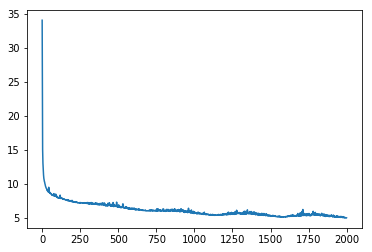

mean_absolute_error: 620.35%
Train on 16266 samples, validate on 1807 samples
Epoch 1/2000
14000/16266 [========================>.....] - ETA: 0s - loss: 34.5308 - mean_absolute_error: 34.5308

C:\Users\shaltaf\AppData\Local\conda\conda\envs\neural\lib\site-packages\keras\callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.108345). Check your callbacks.
  % delta_t_median)


16266/16266 [==============================] - 1s 54us/step - loss: 34.3699 - mean_absolute_error: 34.3699 - val_loss: 33.5587 - val_mean_absolute_error: 33.5587
Epoch 2/2000
16266/16266 [==============================] - 0s 7us/step - loss: 34.0066 - mean_absolute_error: 34.0066 - val_loss: 32.7547 - val_mean_absolute_error: 32.7547
Epoch 3/2000
16266/16266 [==============================] - 0s 7us/step - loss: 32.8075 - mean_absolute_error: 32.8075 - val_loss: 30.9576 - val_mean_absolute_error: 30.9576
Epoch 4/2000
16266/16266 [==============================] - 0s 8us/step - loss: 30.2751 - mean_absolute_error: 30.2751 - val_loss: 26.6613 - val_mean_absolute_error: 26.6613
Epoch 5/2000
16266/16266 [==============================] - 0s 7us/step - loss: 24.3101 - mean_absolute_error: 24.3101 - val_loss: 18.9747 - val_mean_absolute_error: 18.9747
Epoch 6/2000
16266/16266 [==============================] - 0s 7us/step - loss: 17.5816 - mean_absolute_error: 17.5816 - val_loss: 17.0909 - v

16266/16266 [==============================] - 0s 7us/step - loss: 9.7793 - mean_absolute_error: 9.7793 - val_loss: 9.9096 - val_mean_absolute_error: 9.9096
Epoch 49/2000
16266/16266 [==============================] - 0s 7us/step - loss: 9.7496 - mean_absolute_error: 9.7496 - val_loss: 9.8353 - val_mean_absolute_error: 9.8353
Epoch 50/2000
16266/16266 [==============================] - 0s 7us/step - loss: 9.7015 - mean_absolute_error: 9.7015 - val_loss: 9.7874 - val_mean_absolute_error: 9.7874
Epoch 51/2000
16266/16266 [==============================] - 0s 7us/step - loss: 9.6386 - mean_absolute_error: 9.6386 - val_loss: 9.8340 - val_mean_absolute_error: 9.8340
Epoch 52/2000
16266/16266 [==============================] - 0s 7us/step - loss: 9.6171 - mean_absolute_error: 9.6171 - val_loss: 9.7645 - val_mean_absolute_error: 9.7645
Epoch 53/2000
16266/16266 [==============================] - 0s 7us/step - loss: 9.5567 - mean_absolute_error: 9.5567 - val_loss: 9.7649 - val_mean_absolute_er

Epoch 96/2000
16266/16266 [==============================] - 0s 7us/step - loss: 8.3741 - mean_absolute_error: 8.3741 - val_loss: 8.5849 - val_mean_absolute_error: 8.5849
Epoch 97/2000
16266/16266 [==============================] - 0s 7us/step - loss: 8.3664 - mean_absolute_error: 8.3664 - val_loss: 8.6231 - val_mean_absolute_error: 8.6231
Epoch 98/2000
16266/16266 [==============================] - 0s 7us/step - loss: 8.3217 - mean_absolute_error: 8.3217 - val_loss: 8.7311 - val_mean_absolute_error: 8.7311
Epoch 99/2000
16266/16266 [==============================] - 0s 7us/step - loss: 8.3661 - mean_absolute_error: 8.3661 - val_loss: 8.8232 - val_mean_absolute_error: 8.8232
Epoch 100/2000
16266/16266 [==============================] - 0s 7us/step - loss: 8.4090 - mean_absolute_error: 8.4090 - val_loss: 8.5702 - val_mean_absolute_error: 8.5702
Epoch 101/2000
16266/16266 [==============================] - 0s 7us/step - loss: 8.3641 - mean_absolute_error: 8.3641 - val_loss: 8.5994 - val_

Epoch 191/2000
16266/16266 [==============================] - 0s 7us/step - loss: 7.4461 - mean_absolute_error: 7.4461 - val_loss: 8.0694 - val_mean_absolute_error: 8.0694
Epoch 192/2000
16266/16266 [==============================] - 0s 8us/step - loss: 7.6341 - mean_absolute_error: 7.6341 - val_loss: 8.0110 - val_mean_absolute_error: 8.0110
Epoch 193/2000
16266/16266 [==============================] - 0s 7us/step - loss: 7.4947 - mean_absolute_error: 7.4947 - val_loss: 7.8515 - val_mean_absolute_error: 7.8515
Epoch 194/2000
16266/16266 [==============================] - 0s 8us/step - loss: 7.4644 - mean_absolute_error: 7.4644 - val_loss: 7.9044 - val_mean_absolute_error: 7.9044
Epoch 195/2000
16266/16266 [==============================] - 0s 7us/step - loss: 7.3829 - mean_absolute_error: 7.3829 - val_loss: 8.1177 - val_mean_absolute_error: 8.1177
Epoch 196/2000
16266/16266 [==============================] - 0s 7us/step - loss: 7.6496 - mean_absolute_error: 7.6496 - val_loss: 7.5871 - 

Epoch 286/2000
16266/16266 [==============================] - 0s 7us/step - loss: 6.7767 - mean_absolute_error: 6.7767 - val_loss: 7.2803 - val_mean_absolute_error: 7.2803
Epoch 287/2000
16266/16266 [==============================] - 0s 7us/step - loss: 6.7706 - mean_absolute_error: 6.7706 - val_loss: 7.3366 - val_mean_absolute_error: 7.3366
Epoch 288/2000
16266/16266 [==============================] - 0s 7us/step - loss: 6.8840 - mean_absolute_error: 6.8840 - val_loss: 7.5917 - val_mean_absolute_error: 7.5917
Epoch 289/2000
16266/16266 [==============================] - 0s 7us/step - loss: 6.8523 - mean_absolute_error: 6.8523 - val_loss: 7.3309 - val_mean_absolute_error: 7.3309
Epoch 290/2000
16266/16266 [==============================] - 0s 7us/step - loss: 6.8799 - mean_absolute_error: 6.8799 - val_loss: 7.7089 - val_mean_absolute_error: 7.7089
Epoch 291/2000
16266/16266 [==============================] - 0s 7us/step - loss: 6.9193 - mean_absolute_error: 6.9193 - val_loss: 7.2369 - 

Epoch 381/2000
16266/16266 [==============================] - 0s 7us/step - loss: 6.3168 - mean_absolute_error: 6.3168 - val_loss: 7.0490 - val_mean_absolute_error: 7.0490
Epoch 382/2000
16266/16266 [==============================] - 0s 7us/step - loss: 6.3153 - mean_absolute_error: 6.3153 - val_loss: 7.1975 - val_mean_absolute_error: 7.1975
Epoch 383/2000
16266/16266 [==============================] - 0s 7us/step - loss: 6.4139 - mean_absolute_error: 6.4139 - val_loss: 7.0734 - val_mean_absolute_error: 7.0734
Epoch 384/2000
16266/16266 [==============================] - 0s 7us/step - loss: 6.3562 - mean_absolute_error: 6.3562 - val_loss: 7.1670 - val_mean_absolute_error: 7.1670
Epoch 385/2000
16266/16266 [==============================] - 0s 7us/step - loss: 6.3847 - mean_absolute_error: 6.3847 - val_loss: 7.2146 - val_mean_absolute_error: 7.2146
Epoch 386/2000
16266/16266 [==============================] - 0s 7us/step - loss: 6.3936 - mean_absolute_error: 6.3936 - val_loss: 7.0144 - 

Epoch 476/2000
16266/16266 [==============================] - 0s 7us/step - loss: 6.0711 - mean_absolute_error: 6.0711 - val_loss: 6.8819 - val_mean_absolute_error: 6.8819
Epoch 477/2000
16266/16266 [==============================] - 0s 7us/step - loss: 6.1019 - mean_absolute_error: 6.1019 - val_loss: 6.8993 - val_mean_absolute_error: 6.8993
Epoch 478/2000
16266/16266 [==============================] - 0s 7us/step - loss: 6.0599 - mean_absolute_error: 6.0599 - val_loss: 6.8736 - val_mean_absolute_error: 6.8736
Epoch 479/2000
16266/16266 [==============================] - 0s 7us/step - loss: 6.0673 - mean_absolute_error: 6.0673 - val_loss: 6.8865 - val_mean_absolute_error: 6.8865
Epoch 480/2000
16266/16266 [==============================] - 0s 7us/step - loss: 6.0612 - mean_absolute_error: 6.0612 - val_loss: 6.9099 - val_mean_absolute_error: 6.9099
Epoch 481/2000
16266/16266 [==============================] - 0s 7us/step - loss: 6.0678 - mean_absolute_error: 6.0678 - val_loss: 6.9069 - 

Epoch 571/2000
16266/16266 [==============================] - 0s 7us/step - loss: 6.1278 - mean_absolute_error: 6.1278 - val_loss: 7.0834 - val_mean_absolute_error: 7.0834
Epoch 572/2000
16266/16266 [==============================] - 0s 7us/step - loss: 6.1893 - mean_absolute_error: 6.1893 - val_loss: 6.9225 - val_mean_absolute_error: 6.9225
Epoch 573/2000
16266/16266 [==============================] - 0s 7us/step - loss: 6.1992 - mean_absolute_error: 6.1992 - val_loss: 6.8422 - val_mean_absolute_error: 6.8422
Epoch 574/2000
16266/16266 [==============================] - 0s 7us/step - loss: 6.0877 - mean_absolute_error: 6.0877 - val_loss: 7.0327 - val_mean_absolute_error: 7.0327
Epoch 575/2000
16266/16266 [==============================] - 0s 7us/step - loss: 6.1961 - mean_absolute_error: 6.1961 - val_loss: 7.0753 - val_mean_absolute_error: 7.0753
Epoch 576/2000
16266/16266 [==============================] - 0s 7us/step - loss: 6.1942 - mean_absolute_error: 6.1942 - val_loss: 6.8462 - 

Epoch 666/2000
16266/16266 [==============================] - 0s 7us/step - loss: 6.1254 - mean_absolute_error: 6.1254 - val_loss: 6.8934 - val_mean_absolute_error: 6.8934
Epoch 667/2000
16266/16266 [==============================] - 0s 7us/step - loss: 6.0807 - mean_absolute_error: 6.0807 - val_loss: 6.8793 - val_mean_absolute_error: 6.8793
Epoch 668/2000
16266/16266 [==============================] - 0s 7us/step - loss: 6.1259 - mean_absolute_error: 6.1259 - val_loss: 7.0567 - val_mean_absolute_error: 7.0567
Epoch 669/2000
16266/16266 [==============================] - 0s 7us/step - loss: 6.3796 - mean_absolute_error: 6.3796 - val_loss: 7.0745 - val_mean_absolute_error: 7.0745
Epoch 670/2000
16266/16266 [==============================] - 0s 7us/step - loss: 6.2538 - mean_absolute_error: 6.2538 - val_loss: 6.9968 - val_mean_absolute_error: 6.9968
Epoch 671/2000
16266/16266 [==============================] - 0s 7us/step - loss: 6.1919 - mean_absolute_error: 6.1919 - val_loss: 6.7765 - 

Epoch 761/2000
16266/16266 [==============================] - 0s 7us/step - loss: 5.8159 - mean_absolute_error: 5.8159 - val_loss: 6.8184 - val_mean_absolute_error: 6.8184
Epoch 762/2000
16266/16266 [==============================] - 0s 7us/step - loss: 5.8689 - mean_absolute_error: 5.8689 - val_loss: 6.7329 - val_mean_absolute_error: 6.7329
Epoch 763/2000
16266/16266 [==============================] - 0s 7us/step - loss: 5.8152 - mean_absolute_error: 5.8152 - val_loss: 6.8143 - val_mean_absolute_error: 6.8143
Epoch 764/2000
16266/16266 [==============================] - 0s 7us/step - loss: 5.8953 - mean_absolute_error: 5.8953 - val_loss: 6.6523 - val_mean_absolute_error: 6.6523
Epoch 765/2000
16266/16266 [==============================] - 0s 8us/step - loss: 5.8183 - mean_absolute_error: 5.8183 - val_loss: 6.7256 - val_mean_absolute_error: 6.7256
Epoch 766/2000
16266/16266 [==============================] - 0s 8us/step - loss: 5.8225 - mean_absolute_error: 5.8225 - val_loss: 6.8470 - 

Epoch 856/2000
16266/16266 [==============================] - 0s 7us/step - loss: 5.6126 - mean_absolute_error: 5.6126 - val_loss: 6.5947 - val_mean_absolute_error: 6.5947
Epoch 857/2000
16266/16266 [==============================] - 0s 7us/step - loss: 5.5500 - mean_absolute_error: 5.5500 - val_loss: 6.5775 - val_mean_absolute_error: 6.5775
Epoch 858/2000
16266/16266 [==============================] - 0s 7us/step - loss: 5.5646 - mean_absolute_error: 5.5646 - val_loss: 6.5228 - val_mean_absolute_error: 6.5228
Epoch 859/2000
16266/16266 [==============================] - 0s 7us/step - loss: 5.5684 - mean_absolute_error: 5.5684 - val_loss: 6.5840 - val_mean_absolute_error: 6.5840
Epoch 860/2000
16266/16266 [==============================] - 0s 7us/step - loss: 5.5810 - mean_absolute_error: 5.5810 - val_loss: 6.6434 - val_mean_absolute_error: 6.6434
Epoch 861/2000
16266/16266 [==============================] - 0s 7us/step - loss: 5.6559 - mean_absolute_error: 5.6559 - val_loss: 6.7402 - 

Epoch 951/2000
16266/16266 [==============================] - 0s 7us/step - loss: 5.5401 - mean_absolute_error: 5.5401 - val_loss: 6.6926 - val_mean_absolute_error: 6.6926
Epoch 952/2000
16266/16266 [==============================] - 0s 7us/step - loss: 5.5841 - mean_absolute_error: 5.5841 - val_loss: 6.6085 - val_mean_absolute_error: 6.6085
Epoch 953/2000
16266/16266 [==============================] - 0s 7us/step - loss: 5.5309 - mean_absolute_error: 5.5309 - val_loss: 6.6087 - val_mean_absolute_error: 6.6087
Epoch 954/2000
16266/16266 [==============================] - 0s 7us/step - loss: 5.5478 - mean_absolute_error: 5.5478 - val_loss: 6.5264 - val_mean_absolute_error: 6.5264
Epoch 955/2000
16266/16266 [==============================] - 0s 7us/step - loss: 5.4818 - mean_absolute_error: 5.4818 - val_loss: 6.6320 - val_mean_absolute_error: 6.6320
Epoch 956/2000
16266/16266 [==============================] - 0s 7us/step - loss: 5.5198 - mean_absolute_error: 5.5198 - val_loss: 6.4907 - 

16266/16266 [==============================] - 0s 7us/step - loss: 5.5951 - mean_absolute_error: 5.5951 - val_loss: 6.5420 - val_mean_absolute_error: 6.5420
Epoch 1046/2000
16266/16266 [==============================] - 0s 7us/step - loss: 5.7246 - mean_absolute_error: 5.7246 - val_loss: 6.7690 - val_mean_absolute_error: 6.7690
Epoch 1047/2000
16266/16266 [==============================] - 0s 7us/step - loss: 5.8134 - mean_absolute_error: 5.8134 - val_loss: 6.8588 - val_mean_absolute_error: 6.8588
Epoch 1048/2000
16266/16266 [==============================] - 0s 7us/step - loss: 5.7401 - mean_absolute_error: 5.7401 - val_loss: 6.9637 - val_mean_absolute_error: 6.9637
Epoch 1049/2000
16266/16266 [==============================] - 0s 7us/step - loss: 5.7099 - mean_absolute_error: 5.7099 - val_loss: 6.6812 - val_mean_absolute_error: 6.6812
Epoch 1050/2000
16266/16266 [==============================] - 0s 7us/step - loss: 5.7357 - mean_absolute_error: 5.7357 - val_loss: 6.6925 - val_mean_a

16266/16266 [==============================] - 0s 7us/step - loss: 5.7918 - mean_absolute_error: 5.7918 - val_loss: 6.7965 - val_mean_absolute_error: 6.7965
Epoch 1140/2000
16266/16266 [==============================] - 0s 7us/step - loss: 5.8357 - mean_absolute_error: 5.8357 - val_loss: 7.2173 - val_mean_absolute_error: 7.2173
Epoch 1141/2000
16266/16266 [==============================] - 0s 7us/step - loss: 5.9873 - mean_absolute_error: 5.9873 - val_loss: 6.6795 - val_mean_absolute_error: 6.6795
Epoch 1142/2000
16266/16266 [==============================] - 0s 7us/step - loss: 5.7643 - mean_absolute_error: 5.7643 - val_loss: 6.8345 - val_mean_absolute_error: 6.8345
Epoch 1143/2000
16266/16266 [==============================] - 0s 8us/step - loss: 5.7849 - mean_absolute_error: 5.7849 - val_loss: 6.6810 - val_mean_absolute_error: 6.6810
Epoch 1144/2000
16266/16266 [==============================] - 0s 7us/step - loss: 5.7610 - mean_absolute_error: 5.7610 - val_loss: 6.6451 - val_mean_a

16266/16266 [==============================] - 0s 7us/step - loss: 5.4922 - mean_absolute_error: 5.4922 - val_loss: 6.4704 - val_mean_absolute_error: 6.4704
Epoch 1234/2000
16266/16266 [==============================] - 0s 7us/step - loss: 5.4684 - mean_absolute_error: 5.4684 - val_loss: 6.4619 - val_mean_absolute_error: 6.4619
Epoch 1235/2000
16266/16266 [==============================] - 0s 7us/step - loss: 5.4793 - mean_absolute_error: 5.4793 - val_loss: 6.5242 - val_mean_absolute_error: 6.5242
Epoch 1236/2000
16266/16266 [==============================] - 0s 7us/step - loss: 5.4420 - mean_absolute_error: 5.4420 - val_loss: 6.5327 - val_mean_absolute_error: 6.5327
Epoch 1237/2000
16266/16266 [==============================] - 0s 7us/step - loss: 5.4368 - mean_absolute_error: 5.4368 - val_loss: 6.4796 - val_mean_absolute_error: 6.4796
Epoch 1238/2000
16266/16266 [==============================] - 0s 7us/step - loss: 5.4503 - mean_absolute_error: 5.4503 - val_loss: 6.5770 - val_mean_a

16266/16266 [==============================] - 0s 7us/step - loss: 5.2537 - mean_absolute_error: 5.2537 - val_loss: 6.4200 - val_mean_absolute_error: 6.4200
Epoch 1328/2000
16266/16266 [==============================] - 0s 7us/step - loss: 5.1902 - mean_absolute_error: 5.1902 - val_loss: 6.4241 - val_mean_absolute_error: 6.4241
Epoch 1329/2000
16266/16266 [==============================] - 0s 7us/step - loss: 5.1871 - mean_absolute_error: 5.1871 - val_loss: 6.4266 - val_mean_absolute_error: 6.4266
Epoch 1330/2000
16266/16266 [==============================] - 0s 7us/step - loss: 5.2388 - mean_absolute_error: 5.2388 - val_loss: 6.4014 - val_mean_absolute_error: 6.4014
Epoch 1331/2000
16266/16266 [==============================] - 0s 7us/step - loss: 5.1990 - mean_absolute_error: 5.1990 - val_loss: 6.4268 - val_mean_absolute_error: 6.4268
Epoch 1332/2000
16266/16266 [==============================] - 0s 7us/step - loss: 5.2137 - mean_absolute_error: 5.2137 - val_loss: 6.5251 - val_mean_a

16266/16266 [==============================] - 0s 7us/step - loss: 5.3009 - mean_absolute_error: 5.3009 - val_loss: 6.4626 - val_mean_absolute_error: 6.4626
Epoch 1422/2000
16266/16266 [==============================] - 0s 7us/step - loss: 5.2572 - mean_absolute_error: 5.2572 - val_loss: 6.5427 - val_mean_absolute_error: 6.5427
Epoch 1423/2000
16266/16266 [==============================] - 0s 7us/step - loss: 5.3029 - mean_absolute_error: 5.3029 - val_loss: 6.5293 - val_mean_absolute_error: 6.5293
Epoch 1424/2000
16266/16266 [==============================] - 0s 7us/step - loss: 5.3115 - mean_absolute_error: 5.3115 - val_loss: 6.5586 - val_mean_absolute_error: 6.5586
Epoch 1425/2000
16266/16266 [==============================] - 0s 7us/step - loss: 5.3019 - mean_absolute_error: 5.3019 - val_loss: 6.4169 - val_mean_absolute_error: 6.4169
Epoch 1426/2000
16266/16266 [==============================] - 0s 7us/step - loss: 5.2735 - mean_absolute_error: 5.2735 - val_loss: 6.4393 - val_mean_a

16266/16266 [==============================] - 0s 7us/step - loss: 5.4752 - mean_absolute_error: 5.4752 - val_loss: 6.5357 - val_mean_absolute_error: 6.5357
Epoch 1516/2000
16266/16266 [==============================] - 0s 7us/step - loss: 5.4628 - mean_absolute_error: 5.4628 - val_loss: 6.4680 - val_mean_absolute_error: 6.4680
Epoch 1517/2000
16266/16266 [==============================] - 0s 7us/step - loss: 5.4197 - mean_absolute_error: 5.4197 - val_loss: 6.6219 - val_mean_absolute_error: 6.6219
Epoch 1518/2000
16266/16266 [==============================] - 0s 7us/step - loss: 5.4307 - mean_absolute_error: 5.4307 - val_loss: 6.6956 - val_mean_absolute_error: 6.6956
Epoch 1519/2000
16266/16266 [==============================] - 0s 7us/step - loss: 5.4779 - mean_absolute_error: 5.4779 - val_loss: 6.4480 - val_mean_absolute_error: 6.4480
Epoch 1520/2000
16266/16266 [==============================] - 0s 7us/step - loss: 5.5640 - mean_absolute_error: 5.5640 - val_loss: 6.5223 - val_mean_a

16266/16266 [==============================] - 0s 7us/step - loss: 5.3962 - mean_absolute_error: 5.3962 - val_loss: 6.5416 - val_mean_absolute_error: 6.5416
Epoch 1610/2000
16266/16266 [==============================] - 0s 7us/step - loss: 5.5374 - mean_absolute_error: 5.5374 - val_loss: 6.6583 - val_mean_absolute_error: 6.6583
Epoch 1611/2000
16266/16266 [==============================] - 0s 7us/step - loss: 5.4804 - mean_absolute_error: 5.4804 - val_loss: 6.7387 - val_mean_absolute_error: 6.7387
Epoch 1612/2000
16266/16266 [==============================] - 0s 7us/step - loss: 5.5241 - mean_absolute_error: 5.5241 - val_loss: 6.5177 - val_mean_absolute_error: 6.5177
Epoch 1613/2000
16266/16266 [==============================] - 0s 7us/step - loss: 5.4748 - mean_absolute_error: 5.4748 - val_loss: 6.5724 - val_mean_absolute_error: 6.5724
Epoch 1614/2000
16266/16266 [==============================] - 0s 7us/step - loss: 5.5189 - mean_absolute_error: 5.5189 - val_loss: 6.6463 - val_mean_a

16266/16266 [==============================] - 0s 7us/step - loss: 5.1575 - mean_absolute_error: 5.1575 - val_loss: 6.3894 - val_mean_absolute_error: 6.3894
Epoch 1704/2000
16266/16266 [==============================] - 0s 7us/step - loss: 5.1420 - mean_absolute_error: 5.1420 - val_loss: 6.3427 - val_mean_absolute_error: 6.3427
Epoch 1705/2000
16266/16266 [==============================] - 0s 7us/step - loss: 5.1313 - mean_absolute_error: 5.1313 - val_loss: 6.3701 - val_mean_absolute_error: 6.3701
Epoch 1706/2000
16266/16266 [==============================] - 0s 7us/step - loss: 5.1669 - mean_absolute_error: 5.1669 - val_loss: 6.4485 - val_mean_absolute_error: 6.4485
Epoch 1707/2000
16266/16266 [==============================] - 0s 7us/step - loss: 5.2115 - mean_absolute_error: 5.2115 - val_loss: 6.3787 - val_mean_absolute_error: 6.3787
Epoch 1708/2000
16266/16266 [==============================] - 0s 7us/step - loss: 5.1793 - mean_absolute_error: 5.1793 - val_loss: 6.4312 - val_mean_a

16266/16266 [==============================] - 0s 7us/step - loss: 4.9561 - mean_absolute_error: 4.9561 - val_loss: 6.3248 - val_mean_absolute_error: 6.3248
Epoch 1798/2000
16266/16266 [==============================] - 0s 7us/step - loss: 4.9524 - mean_absolute_error: 4.9524 - val_loss: 6.3588 - val_mean_absolute_error: 6.3588
Epoch 1799/2000
16266/16266 [==============================] - 0s 7us/step - loss: 4.9588 - mean_absolute_error: 4.9588 - val_loss: 6.3131 - val_mean_absolute_error: 6.3131
Epoch 1800/2000
16266/16266 [==============================] - 0s 7us/step - loss: 4.9359 - mean_absolute_error: 4.9359 - val_loss: 6.3246 - val_mean_absolute_error: 6.3246
Epoch 1801/2000
16266/16266 [==============================] - 0s 7us/step - loss: 4.9492 - mean_absolute_error: 4.9492 - val_loss: 6.3817 - val_mean_absolute_error: 6.3817
Epoch 1802/2000
16266/16266 [==============================] - 0s 7us/step - loss: 4.9802 - mean_absolute_error: 4.9802 - val_loss: 6.3105 - val_mean_a

16266/16266 [==============================] - 0s 7us/step - loss: 5.1507 - mean_absolute_error: 5.1507 - val_loss: 6.4329 - val_mean_absolute_error: 6.4329
Epoch 1892/2000
16266/16266 [==============================] - 0s 7us/step - loss: 5.1609 - mean_absolute_error: 5.1609 - val_loss: 6.5791 - val_mean_absolute_error: 6.5791
Epoch 1893/2000
16266/16266 [==============================] - 0s 7us/step - loss: 5.2872 - mean_absolute_error: 5.2872 - val_loss: 6.4254 - val_mean_absolute_error: 6.4254
Epoch 1894/2000
16266/16266 [==============================] - 0s 7us/step - loss: 5.1477 - mean_absolute_error: 5.1477 - val_loss: 6.4060 - val_mean_absolute_error: 6.4060
Epoch 1895/2000
16266/16266 [==============================] - 0s 7us/step - loss: 5.1148 - mean_absolute_error: 5.1148 - val_loss: 6.4832 - val_mean_absolute_error: 6.4832
Epoch 1896/2000
16266/16266 [==============================] - 0s 7us/step - loss: 5.1433 - mean_absolute_error: 5.1433 - val_loss: 6.4557 - val_mean_a

16266/16266 [==============================] - 0s 7us/step - loss: 5.2819 - mean_absolute_error: 5.2819 - val_loss: 6.4027 - val_mean_absolute_error: 6.4027
Epoch 1986/2000
16266/16266 [==============================] - 0s 7us/step - loss: 5.2710 - mean_absolute_error: 5.2710 - val_loss: 6.7375 - val_mean_absolute_error: 6.7375
Epoch 1987/2000
16266/16266 [==============================] - 0s 7us/step - loss: 5.6258 - mean_absolute_error: 5.6258 - val_loss: 6.5588 - val_mean_absolute_error: 6.5588
Epoch 1988/2000
16266/16266 [==============================] - 0s 7us/step - loss: 5.2791 - mean_absolute_error: 5.2791 - val_loss: 6.6473 - val_mean_absolute_error: 6.6473
Epoch 1989/2000
16266/16266 [==============================] - 0s 7us/step - loss: 5.3147 - mean_absolute_error: 5.3147 - val_loss: 6.4013 - val_mean_absolute_error: 6.4013
Epoch 1990/2000
16266/16266 [==============================] - 0s 7us/step - loss: 5.3005 - mean_absolute_error: 5.3005 - val_loss: 6.6003 - val_mean_a

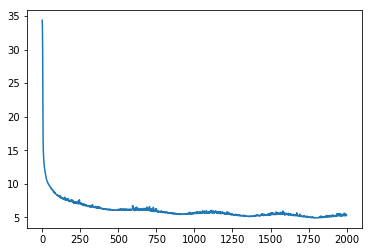

mean_absolute_error: 642.89%
Train on 16266 samples, validate on 1807 samples
Epoch 1/2000
12000/16266 [=====================>........] - ETA: 0s - loss: 34.1910 - mean_absolute_error: 34.1910

C:\Users\shaltaf\AppData\Local\conda\conda\envs\neural\lib\site-packages\keras\callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.112242). Check your callbacks.
  % delta_t_median)


16266/16266 [==============================] - 1s 55us/step - loss: 33.9216 - mean_absolute_error: 33.9216 - val_loss: 31.3510 - val_mean_absolute_error: 31.3510
Epoch 2/2000
16266/16266 [==============================] - 0s 7us/step - loss: 26.2281 - mean_absolute_error: 26.2281 - val_loss: 16.2378 - val_mean_absolute_error: 16.2378
Epoch 3/2000
16266/16266 [==============================] - 0s 7us/step - loss: 17.7338 - mean_absolute_error: 17.7338 - val_loss: 15.7078 - val_mean_absolute_error: 15.7078
Epoch 4/2000
16266/16266 [==============================] - 0s 7us/step - loss: 15.6522 - mean_absolute_error: 15.6522 - val_loss: 13.6263 - val_mean_absolute_error: 13.6263
Epoch 5/2000
16266/16266 [==============================] - 0s 7us/step - loss: 13.9610 - mean_absolute_error: 13.9610 - val_loss: 12.9089 - val_mean_absolute_error: 12.9089
Epoch 6/2000
16266/16266 [==============================] - 0s 7us/step - loss: 13.1107 - mean_absolute_error: 13.1107 - val_loss: 12.4321 - v

Epoch 96/2000
16266/16266 [==============================] - 0s 7us/step - loss: 8.0891 - mean_absolute_error: 8.0891 - val_loss: 8.2108 - val_mean_absolute_error: 8.2108
Epoch 97/2000
16266/16266 [==============================] - 0s 7us/step - loss: 7.9993 - mean_absolute_error: 7.9993 - val_loss: 7.9536 - val_mean_absolute_error: 7.9536
Epoch 98/2000
16266/16266 [==============================] - 0s 7us/step - loss: 7.9914 - mean_absolute_error: 7.9914 - val_loss: 7.9312 - val_mean_absolute_error: 7.9312
Epoch 99/2000
16266/16266 [==============================] - 0s 7us/step - loss: 8.0151 - mean_absolute_error: 8.0151 - val_loss: 7.9070 - val_mean_absolute_error: 7.9070
Epoch 100/2000
16266/16266 [==============================] - 0s 7us/step - loss: 7.8404 - mean_absolute_error: 7.8404 - val_loss: 7.9667 - val_mean_absolute_error: 7.9667
Epoch 101/2000
16266/16266 [==============================] - 0s 7us/step - loss: 7.8608 - mean_absolute_error: 7.8608 - val_loss: 7.8057 - val_

Epoch 191/2000
16266/16266 [==============================] - 0s 7us/step - loss: 7.3315 - mean_absolute_error: 7.3315 - val_loss: 7.4976 - val_mean_absolute_error: 7.4976
Epoch 192/2000
16266/16266 [==============================] - 0s 7us/step - loss: 7.2925 - mean_absolute_error: 7.2925 - val_loss: 7.4990 - val_mean_absolute_error: 7.4990
Epoch 193/2000
16266/16266 [==============================] - 0s 7us/step - loss: 7.2946 - mean_absolute_error: 7.2946 - val_loss: 7.5100 - val_mean_absolute_error: 7.5100
Epoch 194/2000
16266/16266 [==============================] - 0s 7us/step - loss: 7.3086 - mean_absolute_error: 7.3086 - val_loss: 7.5225 - val_mean_absolute_error: 7.5225
Epoch 195/2000
16266/16266 [==============================] - 0s 7us/step - loss: 7.2959 - mean_absolute_error: 7.2959 - val_loss: 7.5081 - val_mean_absolute_error: 7.5081
Epoch 196/2000
16266/16266 [==============================] - 0s 7us/step - loss: 7.2790 - mean_absolute_error: 7.2790 - val_loss: 7.5296 - 

Epoch 286/2000
16266/16266 [==============================] - 0s 7us/step - loss: 7.1217 - mean_absolute_error: 7.1217 - val_loss: 7.3669 - val_mean_absolute_error: 7.3669
Epoch 287/2000
16266/16266 [==============================] - 0s 7us/step - loss: 7.0993 - mean_absolute_error: 7.0993 - val_loss: 7.3849 - val_mean_absolute_error: 7.3849
Epoch 288/2000
16266/16266 [==============================] - 0s 7us/step - loss: 7.0989 - mean_absolute_error: 7.0989 - val_loss: 7.4361 - val_mean_absolute_error: 7.4361
Epoch 289/2000
16266/16266 [==============================] - 0s 7us/step - loss: 7.1214 - mean_absolute_error: 7.1214 - val_loss: 7.5052 - val_mean_absolute_error: 7.5052
Epoch 290/2000
16266/16266 [==============================] - 0s 8us/step - loss: 7.2237 - mean_absolute_error: 7.2237 - val_loss: 7.4320 - val_mean_absolute_error: 7.4320
Epoch 291/2000
16266/16266 [==============================] - 0s 7us/step - loss: 7.1237 - mean_absolute_error: 7.1237 - val_loss: 7.3917 - 

Epoch 381/2000
16266/16266 [==============================] - 0s 7us/step - loss: 6.8893 - mean_absolute_error: 6.8893 - val_loss: 7.2869 - val_mean_absolute_error: 7.2869
Epoch 382/2000
16266/16266 [==============================] - 0s 7us/step - loss: 6.8894 - mean_absolute_error: 6.8894 - val_loss: 7.3293 - val_mean_absolute_error: 7.3293
Epoch 383/2000
16266/16266 [==============================] - 0s 7us/step - loss: 6.9249 - mean_absolute_error: 6.9249 - val_loss: 7.2985 - val_mean_absolute_error: 7.2985
Epoch 384/2000
16266/16266 [==============================] - 0s 7us/step - loss: 7.0591 - mean_absolute_error: 7.0591 - val_loss: 7.3995 - val_mean_absolute_error: 7.3995
Epoch 385/2000
16266/16266 [==============================] - 0s 7us/step - loss: 6.9647 - mean_absolute_error: 6.9647 - val_loss: 7.3233 - val_mean_absolute_error: 7.3233
Epoch 386/2000
16266/16266 [==============================] - 0s 7us/step - loss: 6.9141 - mean_absolute_error: 6.9141 - val_loss: 7.3958 - 

Epoch 476/2000
16266/16266 [==============================] - 0s 7us/step - loss: 6.8243 - mean_absolute_error: 6.8243 - val_loss: 7.1442 - val_mean_absolute_error: 7.1442
Epoch 477/2000
16266/16266 [==============================] - 0s 7us/step - loss: 6.8391 - mean_absolute_error: 6.8391 - val_loss: 7.4581 - val_mean_absolute_error: 7.4581
Epoch 478/2000
16266/16266 [==============================] - 0s 7us/step - loss: 6.7500 - mean_absolute_error: 6.7500 - val_loss: 7.6148 - val_mean_absolute_error: 7.6148
Epoch 479/2000
16266/16266 [==============================] - 0s 7us/step - loss: 6.8637 - mean_absolute_error: 6.8637 - val_loss: 7.0849 - val_mean_absolute_error: 7.0849
Epoch 480/2000
16266/16266 [==============================] - 0s 8us/step - loss: 6.6270 - mean_absolute_error: 6.6270 - val_loss: 7.1227 - val_mean_absolute_error: 7.1227
Epoch 481/2000
16266/16266 [==============================] - 0s 8us/step - loss: 6.6258 - mean_absolute_error: 6.6258 - val_loss: 7.1225 - 

Epoch 571/2000
16266/16266 [==============================] - 0s 7us/step - loss: 6.3792 - mean_absolute_error: 6.3792 - val_loss: 6.9963 - val_mean_absolute_error: 6.9963
Epoch 572/2000
16266/16266 [==============================] - 0s 7us/step - loss: 6.3784 - mean_absolute_error: 6.3784 - val_loss: 6.9768 - val_mean_absolute_error: 6.9768
Epoch 573/2000
16266/16266 [==============================] - 0s 7us/step - loss: 6.3434 - mean_absolute_error: 6.3434 - val_loss: 7.0214 - val_mean_absolute_error: 7.0214
Epoch 574/2000
16266/16266 [==============================] - 0s 7us/step - loss: 6.4342 - mean_absolute_error: 6.4342 - val_loss: 6.9833 - val_mean_absolute_error: 6.9833
Epoch 575/2000
16266/16266 [==============================] - 0s 7us/step - loss: 6.4196 - mean_absolute_error: 6.4196 - val_loss: 6.8913 - val_mean_absolute_error: 6.8913
Epoch 576/2000
16266/16266 [==============================] - 0s 7us/step - loss: 6.6425 - mean_absolute_error: 6.6425 - val_loss: 7.9063 - 

Epoch 666/2000
16266/16266 [==============================] - 0s 7us/step - loss: 6.0516 - mean_absolute_error: 6.0516 - val_loss: 6.7175 - val_mean_absolute_error: 6.7175
Epoch 667/2000
16266/16266 [==============================] - 0s 7us/step - loss: 6.0509 - mean_absolute_error: 6.0509 - val_loss: 6.7233 - val_mean_absolute_error: 6.7233
Epoch 668/2000
16266/16266 [==============================] - 0s 7us/step - loss: 6.0278 - mean_absolute_error: 6.0278 - val_loss: 6.7596 - val_mean_absolute_error: 6.7596
Epoch 669/2000
16266/16266 [==============================] - 0s 8us/step - loss: 6.1126 - mean_absolute_error: 6.1126 - val_loss: 6.7886 - val_mean_absolute_error: 6.7886
Epoch 670/2000
16266/16266 [==============================] - 0s 7us/step - loss: 6.1740 - mean_absolute_error: 6.1740 - val_loss: 6.7790 - val_mean_absolute_error: 6.7790
Epoch 671/2000
16266/16266 [==============================] - 0s 7us/step - loss: 6.1038 - mean_absolute_error: 6.1038 - val_loss: 6.7112 - 

Epoch 761/2000
16266/16266 [==============================] - 0s 7us/step - loss: 6.0033 - mean_absolute_error: 6.0033 - val_loss: 6.9068 - val_mean_absolute_error: 6.9068
Epoch 762/2000
16266/16266 [==============================] - 0s 7us/step - loss: 6.1450 - mean_absolute_error: 6.1450 - val_loss: 6.8392 - val_mean_absolute_error: 6.8392
Epoch 763/2000
16266/16266 [==============================] - 0s 7us/step - loss: 6.1051 - mean_absolute_error: 6.1051 - val_loss: 6.7110 - val_mean_absolute_error: 6.7110
Epoch 764/2000
16266/16266 [==============================] - 0s 7us/step - loss: 6.0330 - mean_absolute_error: 6.0330 - val_loss: 6.7108 - val_mean_absolute_error: 6.7108
Epoch 765/2000
16266/16266 [==============================] - 0s 7us/step - loss: 6.0476 - mean_absolute_error: 6.0476 - val_loss: 6.7391 - val_mean_absolute_error: 6.7391
Epoch 766/2000
16266/16266 [==============================] - 0s 7us/step - loss: 6.0373 - mean_absolute_error: 6.0373 - val_loss: 6.7499 - 

Epoch 856/2000
16266/16266 [==============================] - 0s 7us/step - loss: 6.1034 - mean_absolute_error: 6.1034 - val_loss: 7.1006 - val_mean_absolute_error: 7.1006
Epoch 857/2000
16266/16266 [==============================] - 0s 7us/step - loss: 6.3431 - mean_absolute_error: 6.3431 - val_loss: 6.9648 - val_mean_absolute_error: 6.9648
Epoch 858/2000
16266/16266 [==============================] - 0s 7us/step - loss: 6.1504 - mean_absolute_error: 6.1504 - val_loss: 6.7977 - val_mean_absolute_error: 6.7977
Epoch 859/2000
16266/16266 [==============================] - 0s 7us/step - loss: 6.0350 - mean_absolute_error: 6.0350 - val_loss: 6.8902 - val_mean_absolute_error: 6.8902
Epoch 860/2000
16266/16266 [==============================] - 0s 7us/step - loss: 6.1624 - mean_absolute_error: 6.1624 - val_loss: 6.8730 - val_mean_absolute_error: 6.8730
Epoch 861/2000
16266/16266 [==============================] - 0s 7us/step - loss: 6.1307 - mean_absolute_error: 6.1307 - val_loss: 6.8031 - 

Epoch 951/2000
16266/16266 [==============================] - 0s 7us/step - loss: 6.0634 - mean_absolute_error: 6.0634 - val_loss: 6.6139 - val_mean_absolute_error: 6.6139
Epoch 952/2000
16266/16266 [==============================] - 0s 7us/step - loss: 5.9163 - mean_absolute_error: 5.9163 - val_loss: 6.9239 - val_mean_absolute_error: 6.9239
Epoch 953/2000
16266/16266 [==============================] - 0s 7us/step - loss: 6.0741 - mean_absolute_error: 6.0741 - val_loss: 6.6298 - val_mean_absolute_error: 6.6298
Epoch 954/2000
16266/16266 [==============================] - 0s 7us/step - loss: 5.9672 - mean_absolute_error: 5.9672 - val_loss: 6.5959 - val_mean_absolute_error: 6.5959
Epoch 955/2000
16266/16266 [==============================] - 0s 7us/step - loss: 5.9106 - mean_absolute_error: 5.9106 - val_loss: 6.6252 - val_mean_absolute_error: 6.6252
Epoch 956/2000
16266/16266 [==============================] - 0s 7us/step - loss: 5.9697 - mean_absolute_error: 5.9697 - val_loss: 6.6048 - 

16266/16266 [==============================] - 0s 7us/step - loss: 5.5752 - mean_absolute_error: 5.5752 - val_loss: 6.3037 - val_mean_absolute_error: 6.3037
Epoch 1046/2000
16266/16266 [==============================] - 0s 7us/step - loss: 5.5712 - mean_absolute_error: 5.5712 - val_loss: 6.3539 - val_mean_absolute_error: 6.3539
Epoch 1047/2000
16266/16266 [==============================] - 0s 7us/step - loss: 5.5618 - mean_absolute_error: 5.5618 - val_loss: 6.4396 - val_mean_absolute_error: 6.4396
Epoch 1048/2000
16266/16266 [==============================] - 0s 7us/step - loss: 5.6457 - mean_absolute_error: 5.6457 - val_loss: 6.6275 - val_mean_absolute_error: 6.6275
Epoch 1049/2000
16266/16266 [==============================] - 0s 7us/step - loss: 5.7752 - mean_absolute_error: 5.7752 - val_loss: 6.4112 - val_mean_absolute_error: 6.4112
Epoch 1050/2000
16266/16266 [==============================] - 0s 7us/step - loss: 5.6146 - mean_absolute_error: 5.6146 - val_loss: 6.4494 - val_mean_a

16266/16266 [==============================] - 0s 7us/step - loss: 5.4358 - mean_absolute_error: 5.4358 - val_loss: 6.2856 - val_mean_absolute_error: 6.2856
Epoch 1140/2000
16266/16266 [==============================] - 0s 7us/step - loss: 5.4159 - mean_absolute_error: 5.4159 - val_loss: 6.3112 - val_mean_absolute_error: 6.3112
Epoch 1141/2000
16266/16266 [==============================] - 0s 7us/step - loss: 5.4233 - mean_absolute_error: 5.4233 - val_loss: 6.3336 - val_mean_absolute_error: 6.3336
Epoch 1142/2000
16266/16266 [==============================] - 0s 7us/step - loss: 5.4138 - mean_absolute_error: 5.4138 - val_loss: 6.2518 - val_mean_absolute_error: 6.2518
Epoch 1143/2000
16266/16266 [==============================] - 0s 7us/step - loss: 5.4134 - mean_absolute_error: 5.4134 - val_loss: 6.2784 - val_mean_absolute_error: 6.2784
Epoch 1144/2000
16266/16266 [==============================] - 0s 7us/step - loss: 5.4182 - mean_absolute_error: 5.4182 - val_loss: 6.2400 - val_mean_a

16266/16266 [==============================] - 0s 7us/step - loss: 5.5145 - mean_absolute_error: 5.5145 - val_loss: 6.2422 - val_mean_absolute_error: 6.2422
Epoch 1234/2000
16266/16266 [==============================] - 0s 7us/step - loss: 5.4974 - mean_absolute_error: 5.4974 - val_loss: 6.3834 - val_mean_absolute_error: 6.3834
Epoch 1235/2000
16266/16266 [==============================] - 0s 7us/step - loss: 5.5472 - mean_absolute_error: 5.5472 - val_loss: 6.3090 - val_mean_absolute_error: 6.3090
Epoch 1236/2000
16266/16266 [==============================] - 0s 7us/step - loss: 5.5697 - mean_absolute_error: 5.5697 - val_loss: 6.6185 - val_mean_absolute_error: 6.6185
Epoch 1237/2000
16266/16266 [==============================] - 0s 7us/step - loss: 5.7122 - mean_absolute_error: 5.7122 - val_loss: 6.5347 - val_mean_absolute_error: 6.5347
Epoch 1238/2000
16266/16266 [==============================] - 0s 7us/step - loss: 5.6268 - mean_absolute_error: 5.6268 - val_loss: 6.4170 - val_mean_a

16266/16266 [==============================] - 0s 7us/step - loss: 5.6826 - mean_absolute_error: 5.6826 - val_loss: 6.4162 - val_mean_absolute_error: 6.4162
Epoch 1328/2000
16266/16266 [==============================] - 0s 7us/step - loss: 5.5287 - mean_absolute_error: 5.5287 - val_loss: 6.2560 - val_mean_absolute_error: 6.2560
Epoch 1329/2000
16266/16266 [==============================] - 0s 7us/step - loss: 5.5614 - mean_absolute_error: 5.5614 - val_loss: 6.4042 - val_mean_absolute_error: 6.4042
Epoch 1330/2000
16266/16266 [==============================] - 0s 7us/step - loss: 5.6832 - mean_absolute_error: 5.6832 - val_loss: 6.6225 - val_mean_absolute_error: 6.6225
Epoch 1331/2000
16266/16266 [==============================] - 0s 7us/step - loss: 5.7260 - mean_absolute_error: 5.7260 - val_loss: 6.3834 - val_mean_absolute_error: 6.3834
Epoch 1332/2000
16266/16266 [==============================] - 0s 7us/step - loss: 5.5649 - mean_absolute_error: 5.5649 - val_loss: 6.6266 - val_mean_a

16266/16266 [==============================] - 0s 7us/step - loss: 5.7659 - mean_absolute_error: 5.7659 - val_loss: 6.2424 - val_mean_absolute_error: 6.2424
Epoch 1422/2000
16266/16266 [==============================] - 0s 7us/step - loss: 5.6379 - mean_absolute_error: 5.6379 - val_loss: 6.3025 - val_mean_absolute_error: 6.3025
Epoch 1423/2000
16266/16266 [==============================] - 0s 8us/step - loss: 5.5675 - mean_absolute_error: 5.5675 - val_loss: 6.2945 - val_mean_absolute_error: 6.2945
Epoch 1424/2000
16266/16266 [==============================] - 0s 8us/step - loss: 5.4664 - mean_absolute_error: 5.4664 - val_loss: 6.3460 - val_mean_absolute_error: 6.3460
Epoch 1425/2000
16266/16266 [==============================] - 0s 7us/step - loss: 5.5234 - mean_absolute_error: 5.5234 - val_loss: 6.1679 - val_mean_absolute_error: 6.1679
Epoch 1426/2000
16266/16266 [==============================] - 0s 7us/step - loss: 5.4121 - mean_absolute_error: 5.4121 - val_loss: 6.3277 - val_mean_a

16266/16266 [==============================] - 0s 7us/step - loss: 5.2360 - mean_absolute_error: 5.2360 - val_loss: 6.1338 - val_mean_absolute_error: 6.1338
Epoch 1516/2000
16266/16266 [==============================] - 0s 7us/step - loss: 5.2273 - mean_absolute_error: 5.2273 - val_loss: 6.1184 - val_mean_absolute_error: 6.1184
Epoch 1517/2000
16266/16266 [==============================] - 0s 7us/step - loss: 5.2610 - mean_absolute_error: 5.2610 - val_loss: 6.2860 - val_mean_absolute_error: 6.2860
Epoch 1518/2000
16266/16266 [==============================] - 0s 7us/step - loss: 5.2704 - mean_absolute_error: 5.2704 - val_loss: 6.1189 - val_mean_absolute_error: 6.1189
Epoch 1519/2000
16266/16266 [==============================] - 0s 7us/step - loss: 5.2279 - mean_absolute_error: 5.2279 - val_loss: 6.1350 - val_mean_absolute_error: 6.1350
Epoch 1520/2000
16266/16266 [==============================] - 0s 8us/step - loss: 5.2081 - mean_absolute_error: 5.2081 - val_loss: 6.2479 - val_mean_a

16266/16266 [==============================] - 0s 7us/step - loss: 5.1297 - mean_absolute_error: 5.1297 - val_loss: 6.1387 - val_mean_absolute_error: 6.1387
Epoch 1610/2000
16266/16266 [==============================] - 0s 7us/step - loss: 5.1439 - mean_absolute_error: 5.1439 - val_loss: 6.1501 - val_mean_absolute_error: 6.1501
Epoch 1611/2000
16266/16266 [==============================] - 0s 7us/step - loss: 5.1752 - mean_absolute_error: 5.1752 - val_loss: 6.2749 - val_mean_absolute_error: 6.2749
Epoch 1612/2000
16266/16266 [==============================] - 0s 7us/step - loss: 5.1958 - mean_absolute_error: 5.1958 - val_loss: 6.1377 - val_mean_absolute_error: 6.1377
Epoch 1613/2000
16266/16266 [==============================] - 0s 7us/step - loss: 5.1375 - mean_absolute_error: 5.1375 - val_loss: 6.1302 - val_mean_absolute_error: 6.1302
Epoch 1614/2000
16266/16266 [==============================] - 0s 7us/step - loss: 5.1378 - mean_absolute_error: 5.1378 - val_loss: 6.0909 - val_mean_a

16266/16266 [==============================] - 0s 7us/step - loss: 5.3289 - mean_absolute_error: 5.3289 - val_loss: 6.1335 - val_mean_absolute_error: 6.1335
Epoch 1704/2000
16266/16266 [==============================] - 0s 7us/step - loss: 5.2168 - mean_absolute_error: 5.2168 - val_loss: 6.1330 - val_mean_absolute_error: 6.1330
Epoch 1705/2000
16266/16266 [==============================] - 0s 7us/step - loss: 5.2151 - mean_absolute_error: 5.2151 - val_loss: 6.2121 - val_mean_absolute_error: 6.2121
Epoch 1706/2000
16266/16266 [==============================] - 0s 8us/step - loss: 5.2901 - mean_absolute_error: 5.2901 - val_loss: 6.2073 - val_mean_absolute_error: 6.2073
Epoch 1707/2000
16266/16266 [==============================] - 0s 7us/step - loss: 5.3887 - mean_absolute_error: 5.3887 - val_loss: 6.4675 - val_mean_absolute_error: 6.4675
Epoch 1708/2000
16266/16266 [==============================] - 0s 7us/step - loss: 5.4872 - mean_absolute_error: 5.4872 - val_loss: 6.2880 - val_mean_a

16266/16266 [==============================] - 0s 7us/step - loss: 5.3244 - mean_absolute_error: 5.3244 - val_loss: 6.5197 - val_mean_absolute_error: 6.5197
Epoch 1798/2000
16266/16266 [==============================] - 0s 7us/step - loss: 5.4790 - mean_absolute_error: 5.4790 - val_loss: 6.4033 - val_mean_absolute_error: 6.4033
Epoch 1799/2000
16266/16266 [==============================] - 0s 7us/step - loss: 5.5276 - mean_absolute_error: 5.5276 - val_loss: 6.6010 - val_mean_absolute_error: 6.6010
Epoch 1800/2000
16266/16266 [==============================] - 0s 8us/step - loss: 5.5515 - mean_absolute_error: 5.5515 - val_loss: 6.8917 - val_mean_absolute_error: 6.8917
Epoch 1801/2000
16266/16266 [==============================] - 0s 7us/step - loss: 5.7538 - mean_absolute_error: 5.7538 - val_loss: 6.3779 - val_mean_absolute_error: 6.3779
Epoch 1802/2000
16266/16266 [==============================] - 0s 7us/step - loss: 5.4712 - mean_absolute_error: 5.4712 - val_loss: 6.2186 - val_mean_a

16266/16266 [==============================] - 0s 8us/step - loss: 5.1627 - mean_absolute_error: 5.1627 - val_loss: 6.1373 - val_mean_absolute_error: 6.1373
Epoch 1892/2000
16266/16266 [==============================] - 0s 7us/step - loss: 5.1425 - mean_absolute_error: 5.1425 - val_loss: 5.9937 - val_mean_absolute_error: 5.9937
Epoch 1893/2000
16266/16266 [==============================] - 0s 7us/step - loss: 5.1383 - mean_absolute_error: 5.1383 - val_loss: 6.1935 - val_mean_absolute_error: 6.1935
Epoch 1894/2000
16266/16266 [==============================] - 0s 7us/step - loss: 5.2293 - mean_absolute_error: 5.2293 - val_loss: 6.1443 - val_mean_absolute_error: 6.1443
Epoch 1895/2000
16266/16266 [==============================] - 0s 7us/step - loss: 5.2747 - mean_absolute_error: 5.2747 - val_loss: 6.1125 - val_mean_absolute_error: 6.1125
Epoch 1896/2000
16266/16266 [==============================] - 0s 8us/step - loss: 5.2250 - mean_absolute_error: 5.2250 - val_loss: 6.1304 - val_mean_a

16266/16266 [==============================] - 0s 7us/step - loss: 4.9801 - mean_absolute_error: 4.9801 - val_loss: 6.0087 - val_mean_absolute_error: 6.0087
Epoch 1986/2000
16266/16266 [==============================] - 0s 7us/step - loss: 4.9889 - mean_absolute_error: 4.9889 - val_loss: 5.9864 - val_mean_absolute_error: 5.9864
Epoch 1987/2000
16266/16266 [==============================] - 0s 7us/step - loss: 4.9646 - mean_absolute_error: 4.9646 - val_loss: 5.9981 - val_mean_absolute_error: 5.9981
Epoch 1988/2000
16266/16266 [==============================] - 0s 7us/step - loss: 4.9476 - mean_absolute_error: 4.9476 - val_loss: 6.1397 - val_mean_absolute_error: 6.1397
Epoch 1989/2000
16266/16266 [==============================] - 0s 7us/step - loss: 5.0465 - mean_absolute_error: 5.0465 - val_loss: 6.1172 - val_mean_absolute_error: 6.1172
Epoch 1990/2000
16266/16266 [==============================] - 0s 7us/step - loss: 4.9758 - mean_absolute_error: 4.9758 - val_loss: 6.0320 - val_mean_a

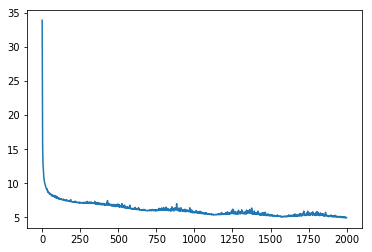

mean_absolute_error: 600.30%
Train on 16266 samples, validate on 1807 samples
Epoch 1/2000
12000/16266 [=====================>........] - ETA: 0s - loss: 34.3232 - mean_absolute_error: 34.3232

C:\Users\shaltaf\AppData\Local\conda\conda\envs\neural\lib\site-packages\keras\callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.127570). Check your callbacks.
  % delta_t_median)


16266/16266 [==============================] - 1s 63us/step - loss: 34.3935 - mean_absolute_error: 34.3935 - val_loss: 33.5194 - val_mean_absolute_error: 33.5194
Epoch 2/2000
16266/16266 [==============================] - 0s 7us/step - loss: 34.0945 - mean_absolute_error: 34.0945 - val_loss: 32.8233 - val_mean_absolute_error: 32.8233
Epoch 3/2000
16266/16266 [==============================] - 0s 7us/step - loss: 32.9177 - mean_absolute_error: 32.9177 - val_loss: 30.9553 - val_mean_absolute_error: 30.9553
Epoch 4/2000
16266/16266 [==============================] - 0s 7us/step - loss: 30.2079 - mean_absolute_error: 30.2079 - val_loss: 26.5933 - val_mean_absolute_error: 26.5933
Epoch 5/2000
16266/16266 [==============================] - 0s 7us/step - loss: 23.8490 - mean_absolute_error: 23.8490 - val_loss: 18.5201 - val_mean_absolute_error: 18.5201
Epoch 6/2000
16266/16266 [==============================] - 0s 7us/step - loss: 17.2087 - mean_absolute_error: 17.2087 - val_loss: 16.6494 - v

Epoch 48/2000
16266/16266 [==============================] - 0s 8us/step - loss: 10.0216 - mean_absolute_error: 10.0216 - val_loss: 10.0005 - val_mean_absolute_error: 10.0005
Epoch 49/2000
16266/16266 [==============================] - 0s 8us/step - loss: 9.9872 - mean_absolute_error: 9.9872 - val_loss: 9.9281 - val_mean_absolute_error: 9.9281
Epoch 50/2000
16266/16266 [==============================] - 0s 7us/step - loss: 9.9036 - mean_absolute_error: 9.9036 - val_loss: 9.8594 - val_mean_absolute_error: 9.8594
Epoch 51/2000
16266/16266 [==============================] - 0s 8us/step - loss: 9.8684 - mean_absolute_error: 9.8684 - val_loss: 9.8589 - val_mean_absolute_error: 9.8589
Epoch 52/2000
16266/16266 [==============================] - 0s 8us/step - loss: 9.8410 - mean_absolute_error: 9.8410 - val_loss: 9.7812 - val_mean_absolute_error: 9.7812
Epoch 53/2000
16266/16266 [==============================] - 0s 8us/step - loss: 9.7887 - mean_absolute_error: 9.7887 - val_loss: 9.7778 - va

Epoch 96/2000
16266/16266 [==============================] - 0s 7us/step - loss: 8.7220 - mean_absolute_error: 8.7220 - val_loss: 9.1054 - val_mean_absolute_error: 9.1054
Epoch 97/2000
16266/16266 [==============================] - 0s 7us/step - loss: 8.7875 - mean_absolute_error: 8.7875 - val_loss: 8.8275 - val_mean_absolute_error: 8.8275
Epoch 98/2000
16266/16266 [==============================] - 0s 7us/step - loss: 8.6601 - mean_absolute_error: 8.6601 - val_loss: 8.7902 - val_mean_absolute_error: 8.7902
Epoch 99/2000
16266/16266 [==============================] - 0s 7us/step - loss: 8.5840 - mean_absolute_error: 8.5840 - val_loss: 8.5598 - val_mean_absolute_error: 8.5598
Epoch 100/2000
16266/16266 [==============================] - 0s 7us/step - loss: 8.5194 - mean_absolute_error: 8.5194 - val_loss: 8.5667 - val_mean_absolute_error: 8.5667
Epoch 101/2000
16266/16266 [==============================] - 0s 7us/step - loss: 8.5411 - mean_absolute_error: 8.5411 - val_loss: 8.6175 - val_

Epoch 191/2000
16266/16266 [==============================] - 0s 7us/step - loss: 7.7240 - mean_absolute_error: 7.7240 - val_loss: 7.7047 - val_mean_absolute_error: 7.7047
Epoch 192/2000
16266/16266 [==============================] - 0s 10us/step - loss: 7.5679 - mean_absolute_error: 7.5679 - val_loss: 7.7101 - val_mean_absolute_error: 7.7101
Epoch 193/2000
16266/16266 [==============================] - 0s 8us/step - loss: 7.5583 - mean_absolute_error: 7.5583 - val_loss: 7.9443 - val_mean_absolute_error: 7.9443
Epoch 194/2000
16266/16266 [==============================] - 0s 8us/step - loss: 7.5877 - mean_absolute_error: 7.5877 - val_loss: 7.7442 - val_mean_absolute_error: 7.7442
Epoch 195/2000
16266/16266 [==============================] - 0s 8us/step - loss: 7.5509 - mean_absolute_error: 7.5509 - val_loss: 7.9896 - val_mean_absolute_error: 7.9896
Epoch 196/2000
16266/16266 [==============================] - 0s 8us/step - loss: 7.7224 - mean_absolute_error: 7.7224 - val_loss: 7.9764 -

Epoch 286/2000
16266/16266 [==============================] - 0s 7us/step - loss: 7.0573 - mean_absolute_error: 7.0573 - val_loss: 7.3689 - val_mean_absolute_error: 7.3689
Epoch 287/2000
16266/16266 [==============================] - 0s 7us/step - loss: 7.0419 - mean_absolute_error: 7.0419 - val_loss: 7.3699 - val_mean_absolute_error: 7.3699
Epoch 288/2000
16266/16266 [==============================] - 0s 7us/step - loss: 7.1276 - mean_absolute_error: 7.1276 - val_loss: 7.3593 - val_mean_absolute_error: 7.3593
Epoch 289/2000
16266/16266 [==============================] - 0s 7us/step - loss: 7.0205 - mean_absolute_error: 7.0205 - val_loss: 7.4524 - val_mean_absolute_error: 7.4524
Epoch 290/2000
16266/16266 [==============================] - 0s 7us/step - loss: 7.0918 - mean_absolute_error: 7.0918 - val_loss: 7.5161 - val_mean_absolute_error: 7.5161
Epoch 291/2000
16266/16266 [==============================] - 0s 7us/step - loss: 7.2294 - mean_absolute_error: 7.2294 - val_loss: 7.2716 - 

Epoch 381/2000
16266/16266 [==============================] - 0s 7us/step - loss: 6.7024 - mean_absolute_error: 6.7024 - val_loss: 7.0495 - val_mean_absolute_error: 7.0495
Epoch 382/2000
16266/16266 [==============================] - 0s 7us/step - loss: 6.6748 - mean_absolute_error: 6.6748 - val_loss: 6.9943 - val_mean_absolute_error: 6.9943
Epoch 383/2000
16266/16266 [==============================] - 0s 7us/step - loss: 6.6195 - mean_absolute_error: 6.6195 - val_loss: 6.9183 - val_mean_absolute_error: 6.9183
Epoch 384/2000
16266/16266 [==============================] - 0s 7us/step - loss: 6.5986 - mean_absolute_error: 6.5986 - val_loss: 6.9976 - val_mean_absolute_error: 6.9976
Epoch 385/2000
16266/16266 [==============================] - 0s 7us/step - loss: 6.6169 - mean_absolute_error: 6.6169 - val_loss: 6.8644 - val_mean_absolute_error: 6.8644
Epoch 386/2000
16266/16266 [==============================] - 0s 7us/step - loss: 6.5911 - mean_absolute_error: 6.5911 - val_loss: 7.0713 - 

Epoch 476/2000
16266/16266 [==============================] - 0s 6us/step - loss: 6.3626 - mean_absolute_error: 6.3626 - val_loss: 6.7003 - val_mean_absolute_error: 6.7003
Epoch 477/2000
16266/16266 [==============================] - 0s 6us/step - loss: 6.3439 - mean_absolute_error: 6.3439 - val_loss: 6.7325 - val_mean_absolute_error: 6.7325
Epoch 478/2000
16266/16266 [==============================] - 0s 7us/step - loss: 6.3613 - mean_absolute_error: 6.3613 - val_loss: 6.6585 - val_mean_absolute_error: 6.6585
Epoch 479/2000
16266/16266 [==============================] - 0s 7us/step - loss: 6.3244 - mean_absolute_error: 6.3244 - val_loss: 6.6922 - val_mean_absolute_error: 6.6922
Epoch 480/2000
16266/16266 [==============================] - 0s 7us/step - loss: 6.3416 - mean_absolute_error: 6.3416 - val_loss: 6.7588 - val_mean_absolute_error: 6.7588
Epoch 481/2000
16266/16266 [==============================] - 0s 7us/step - loss: 6.3636 - mean_absolute_error: 6.3636 - val_loss: 6.6928 - 

Epoch 571/2000
16266/16266 [==============================] - 0s 7us/step - loss: 6.4014 - mean_absolute_error: 6.4014 - val_loss: 6.6078 - val_mean_absolute_error: 6.6078
Epoch 572/2000
16266/16266 [==============================] - 0s 7us/step - loss: 6.3061 - mean_absolute_error: 6.3061 - val_loss: 6.7173 - val_mean_absolute_error: 6.7173
Epoch 573/2000
16266/16266 [==============================] - 0s 7us/step - loss: 6.4167 - mean_absolute_error: 6.4167 - val_loss: 6.6544 - val_mean_absolute_error: 6.6544
Epoch 574/2000
16266/16266 [==============================] - 0s 6us/step - loss: 6.3289 - mean_absolute_error: 6.3289 - val_loss: 6.6262 - val_mean_absolute_error: 6.6262
Epoch 575/2000
16266/16266 [==============================] - 0s 6us/step - loss: 6.3357 - mean_absolute_error: 6.3357 - val_loss: 6.8213 - val_mean_absolute_error: 6.8213
Epoch 576/2000
16266/16266 [==============================] - 0s 7us/step - loss: 6.3435 - mean_absolute_error: 6.3435 - val_loss: 6.8299 - 

Epoch 666/2000
16266/16266 [==============================] - 0s 8us/step - loss: 6.3498 - mean_absolute_error: 6.3498 - val_loss: 6.7554 - val_mean_absolute_error: 6.7554
Epoch 667/2000
16266/16266 [==============================] - 0s 7us/step - loss: 6.3182 - mean_absolute_error: 6.3182 - val_loss: 6.7915 - val_mean_absolute_error: 6.7915
Epoch 668/2000
16266/16266 [==============================] - 0s 7us/step - loss: 6.7380 - mean_absolute_error: 6.7380 - val_loss: 7.2541 - val_mean_absolute_error: 7.2541
Epoch 669/2000
16266/16266 [==============================] - 0s 7us/step - loss: 6.6532 - mean_absolute_error: 6.6532 - val_loss: 6.7216 - val_mean_absolute_error: 6.7216
Epoch 670/2000
16266/16266 [==============================] - 0s 7us/step - loss: 6.6188 - mean_absolute_error: 6.6188 - val_loss: 7.0280 - val_mean_absolute_error: 7.0280
Epoch 671/2000
16266/16266 [==============================] - 0s 7us/step - loss: 6.5265 - mean_absolute_error: 6.5265 - val_loss: 6.7697 - 

Epoch 761/2000
16266/16266 [==============================] - 0s 7us/step - loss: 6.4583 - mean_absolute_error: 6.4583 - val_loss: 6.9430 - val_mean_absolute_error: 6.9430
Epoch 762/2000
16266/16266 [==============================] - 0s 7us/step - loss: 6.4642 - mean_absolute_error: 6.4642 - val_loss: 6.9984 - val_mean_absolute_error: 6.9984
Epoch 763/2000
16266/16266 [==============================] - 0s 7us/step - loss: 6.3230 - mean_absolute_error: 6.3230 - val_loss: 6.6877 - val_mean_absolute_error: 6.6877
Epoch 764/2000
16266/16266 [==============================] - 0s 7us/step - loss: 6.1975 - mean_absolute_error: 6.1975 - val_loss: 6.5344 - val_mean_absolute_error: 6.5344
Epoch 765/2000
16266/16266 [==============================] - 0s 7us/step - loss: 6.1047 - mean_absolute_error: 6.1047 - val_loss: 6.7803 - val_mean_absolute_error: 6.7803
Epoch 766/2000
16266/16266 [==============================] - 0s 7us/step - loss: 6.3654 - mean_absolute_error: 6.3654 - val_loss: 6.4560 - 

Epoch 856/2000
16266/16266 [==============================] - 0s 7us/step - loss: 5.7018 - mean_absolute_error: 5.7018 - val_loss: 6.0347 - val_mean_absolute_error: 6.0347
Epoch 857/2000
16266/16266 [==============================] - 0s 7us/step - loss: 5.7367 - mean_absolute_error: 5.7367 - val_loss: 6.0004 - val_mean_absolute_error: 6.0004
Epoch 858/2000
16266/16266 [==============================] - 0s 7us/step - loss: 5.6631 - mean_absolute_error: 5.6631 - val_loss: 6.0245 - val_mean_absolute_error: 6.0245
Epoch 859/2000
16266/16266 [==============================] - 0s 7us/step - loss: 5.6901 - mean_absolute_error: 5.6901 - val_loss: 6.0892 - val_mean_absolute_error: 6.0892
Epoch 860/2000
16266/16266 [==============================] - 0s 7us/step - loss: 5.7154 - mean_absolute_error: 5.7154 - val_loss: 6.0506 - val_mean_absolute_error: 6.0506
Epoch 861/2000
16266/16266 [==============================] - 0s 7us/step - loss: 5.7152 - mean_absolute_error: 5.7152 - val_loss: 5.9896 - 

Epoch 951/2000
16266/16266 [==============================] - 0s 7us/step - loss: 5.7293 - mean_absolute_error: 5.7293 - val_loss: 5.9723 - val_mean_absolute_error: 5.9723
Epoch 952/2000
16266/16266 [==============================] - 0s 7us/step - loss: 5.5641 - mean_absolute_error: 5.5641 - val_loss: 5.9699 - val_mean_absolute_error: 5.9699
Epoch 953/2000
16266/16266 [==============================] - 0s 7us/step - loss: 5.6510 - mean_absolute_error: 5.6510 - val_loss: 6.2361 - val_mean_absolute_error: 6.2361
Epoch 954/2000
16266/16266 [==============================] - 0s 7us/step - loss: 5.8720 - mean_absolute_error: 5.8720 - val_loss: 6.4919 - val_mean_absolute_error: 6.4919
Epoch 955/2000
16266/16266 [==============================] - 0s 7us/step - loss: 5.7628 - mean_absolute_error: 5.7628 - val_loss: 5.9690 - val_mean_absolute_error: 5.9690
Epoch 956/2000
16266/16266 [==============================] - 0s 7us/step - loss: 5.6403 - mean_absolute_error: 5.6403 - val_loss: 6.2602 - 

16266/16266 [==============================] - 0s 7us/step - loss: 5.9071 - mean_absolute_error: 5.9071 - val_loss: 6.1993 - val_mean_absolute_error: 6.1993
Epoch 1046/2000
16266/16266 [==============================] - 0s 7us/step - loss: 5.8288 - mean_absolute_error: 5.8288 - val_loss: 5.9958 - val_mean_absolute_error: 5.9958
Epoch 1047/2000
16266/16266 [==============================] - 0s 7us/step - loss: 5.7107 - mean_absolute_error: 5.7107 - val_loss: 6.0405 - val_mean_absolute_error: 6.0405
Epoch 1048/2000
16266/16266 [==============================] - 0s 7us/step - loss: 5.6688 - mean_absolute_error: 5.6688 - val_loss: 5.9209 - val_mean_absolute_error: 5.9209
Epoch 1049/2000
16266/16266 [==============================] - 0s 7us/step - loss: 5.5834 - mean_absolute_error: 5.5834 - val_loss: 6.1770 - val_mean_absolute_error: 6.1770
Epoch 1050/2000
16266/16266 [==============================] - 0s 7us/step - loss: 5.7370 - mean_absolute_error: 5.7370 - val_loss: 6.2953 - val_mean_a

16266/16266 [==============================] - 0s 7us/step - loss: 5.7054 - mean_absolute_error: 5.7054 - val_loss: 5.9105 - val_mean_absolute_error: 5.9105
Epoch 1140/2000
16266/16266 [==============================] - 0s 7us/step - loss: 5.6745 - mean_absolute_error: 5.6745 - val_loss: 6.7899 - val_mean_absolute_error: 6.7899
Epoch 1141/2000
16266/16266 [==============================] - 0s 7us/step - loss: 5.9697 - mean_absolute_error: 5.9697 - val_loss: 6.3960 - val_mean_absolute_error: 6.3960
Epoch 1142/2000
16266/16266 [==============================] - 0s 7us/step - loss: 5.8582 - mean_absolute_error: 5.8582 - val_loss: 6.0961 - val_mean_absolute_error: 6.0961
Epoch 1143/2000
16266/16266 [==============================] - 0s 7us/step - loss: 5.7921 - mean_absolute_error: 5.7921 - val_loss: 6.5183 - val_mean_absolute_error: 6.5183
Epoch 1144/2000
16266/16266 [==============================] - 0s 7us/step - loss: 5.9195 - mean_absolute_error: 5.9195 - val_loss: 6.2665 - val_mean_a

16266/16266 [==============================] - 0s 7us/step - loss: 5.4841 - mean_absolute_error: 5.4841 - val_loss: 5.9377 - val_mean_absolute_error: 5.9377
Epoch 1234/2000
16266/16266 [==============================] - 0s 7us/step - loss: 5.5229 - mean_absolute_error: 5.5229 - val_loss: 5.8467 - val_mean_absolute_error: 5.8467
Epoch 1235/2000
16266/16266 [==============================] - 0s 7us/step - loss: 5.4567 - mean_absolute_error: 5.4567 - val_loss: 5.8716 - val_mean_absolute_error: 5.8716
Epoch 1236/2000
16266/16266 [==============================] - 0s 7us/step - loss: 5.4440 - mean_absolute_error: 5.4440 - val_loss: 5.9298 - val_mean_absolute_error: 5.9298
Epoch 1237/2000
16266/16266 [==============================] - 0s 7us/step - loss: 5.4112 - mean_absolute_error: 5.4112 - val_loss: 5.8493 - val_mean_absolute_error: 5.8493
Epoch 1238/2000
16266/16266 [==============================] - 0s 7us/step - loss: 5.4349 - mean_absolute_error: 5.4349 - val_loss: 5.8373 - val_mean_a

16266/16266 [==============================] - 0s 8us/step - loss: 5.3221 - mean_absolute_error: 5.3221 - val_loss: 5.8089 - val_mean_absolute_error: 5.8089
Epoch 1328/2000
16266/16266 [==============================] - 0s 7us/step - loss: 5.2990 - mean_absolute_error: 5.2990 - val_loss: 5.7945 - val_mean_absolute_error: 5.7945
Epoch 1329/2000
16266/16266 [==============================] - 0s 7us/step - loss: 5.2941 - mean_absolute_error: 5.2941 - val_loss: 5.8316 - val_mean_absolute_error: 5.8316
Epoch 1330/2000
16266/16266 [==============================] - 0s 6us/step - loss: 5.2712 - mean_absolute_error: 5.2712 - val_loss: 5.7621 - val_mean_absolute_error: 5.7621
Epoch 1331/2000
16266/16266 [==============================] - 0s 7us/step - loss: 5.2738 - mean_absolute_error: 5.2738 - val_loss: 5.7707 - val_mean_absolute_error: 5.7707
Epoch 1332/2000
16266/16266 [==============================] - 0s 7us/step - loss: 5.3186 - mean_absolute_error: 5.3186 - val_loss: 5.8712 - val_mean_a

16266/16266 [==============================] - 0s 7us/step - loss: 5.2893 - mean_absolute_error: 5.2893 - val_loss: 5.9475 - val_mean_absolute_error: 5.9475
Epoch 1422/2000
16266/16266 [==============================] - 0s 7us/step - loss: 5.3670 - mean_absolute_error: 5.3670 - val_loss: 5.9545 - val_mean_absolute_error: 5.9545
Epoch 1423/2000
16266/16266 [==============================] - 0s 7us/step - loss: 5.4033 - mean_absolute_error: 5.4033 - val_loss: 5.7913 - val_mean_absolute_error: 5.7913
Epoch 1424/2000
16266/16266 [==============================] - 0s 7us/step - loss: 5.3872 - mean_absolute_error: 5.3872 - val_loss: 5.8108 - val_mean_absolute_error: 5.8108
Epoch 1425/2000
16266/16266 [==============================] - 0s 7us/step - loss: 5.3296 - mean_absolute_error: 5.3296 - val_loss: 5.9405 - val_mean_absolute_error: 5.9405
Epoch 1426/2000
16266/16266 [==============================] - 0s 7us/step - loss: 5.4188 - mean_absolute_error: 5.4188 - val_loss: 5.8319 - val_mean_a

16266/16266 [==============================] - 0s 7us/step - loss: 5.5461 - mean_absolute_error: 5.5461 - val_loss: 6.4020 - val_mean_absolute_error: 6.4020
Epoch 1516/2000
16266/16266 [==============================] - 0s 6us/step - loss: 5.6906 - mean_absolute_error: 5.6906 - val_loss: 5.8848 - val_mean_absolute_error: 5.8848
Epoch 1517/2000
16266/16266 [==============================] - 0s 6us/step - loss: 5.4170 - mean_absolute_error: 5.4170 - val_loss: 6.4308 - val_mean_absolute_error: 6.4308
Epoch 1518/2000
16266/16266 [==============================] - 0s 6us/step - loss: 5.7573 - mean_absolute_error: 5.7573 - val_loss: 6.7278 - val_mean_absolute_error: 6.7278
Epoch 1519/2000
16266/16266 [==============================] - 0s 7us/step - loss: 5.8235 - mean_absolute_error: 5.8235 - val_loss: 6.2222 - val_mean_absolute_error: 6.2222
Epoch 1520/2000
16266/16266 [==============================] - 0s 7us/step - loss: 5.7327 - mean_absolute_error: 5.7327 - val_loss: 5.9789 - val_mean_a

16266/16266 [==============================] - 0s 7us/step - loss: 5.4121 - mean_absolute_error: 5.4121 - val_loss: 5.9114 - val_mean_absolute_error: 5.9114
Epoch 1610/2000
16266/16266 [==============================] - 0s 7us/step - loss: 5.3992 - mean_absolute_error: 5.3992 - val_loss: 6.0288 - val_mean_absolute_error: 6.0288
Epoch 1611/2000
16266/16266 [==============================] - 0s 7us/step - loss: 5.4510 - mean_absolute_error: 5.4510 - val_loss: 6.4061 - val_mean_absolute_error: 6.4061
Epoch 1612/2000
16266/16266 [==============================] - 0s 7us/step - loss: 5.7840 - mean_absolute_error: 5.7840 - val_loss: 6.1556 - val_mean_absolute_error: 6.1556
Epoch 1613/2000
16266/16266 [==============================] - 0s 7us/step - loss: 5.7530 - mean_absolute_error: 5.7530 - val_loss: 6.2025 - val_mean_absolute_error: 6.2025
Epoch 1614/2000
16266/16266 [==============================] - 0s 7us/step - loss: 5.7824 - mean_absolute_error: 5.7824 - val_loss: 6.0007 - val_mean_a

16266/16266 [==============================] - 0s 8us/step - loss: 5.3367 - mean_absolute_error: 5.3367 - val_loss: 5.9002 - val_mean_absolute_error: 5.9002
Epoch 1704/2000
16266/16266 [==============================] - 0s 7us/step - loss: 5.2938 - mean_absolute_error: 5.2938 - val_loss: 5.8480 - val_mean_absolute_error: 5.8480
Epoch 1705/2000
16266/16266 [==============================] - 0s 7us/step - loss: 5.1544 - mean_absolute_error: 5.1544 - val_loss: 5.8902 - val_mean_absolute_error: 5.8902
Epoch 1706/2000
16266/16266 [==============================] - 0s 6us/step - loss: 5.1910 - mean_absolute_error: 5.1910 - val_loss: 5.8029 - val_mean_absolute_error: 5.8029
Epoch 1707/2000
16266/16266 [==============================] - 0s 6us/step - loss: 5.2228 - mean_absolute_error: 5.2228 - val_loss: 5.7938 - val_mean_absolute_error: 5.7938
Epoch 1708/2000
16266/16266 [==============================] - 0s 7us/step - loss: 5.1494 - mean_absolute_error: 5.1494 - val_loss: 6.0722 - val_mean_a

16266/16266 [==============================] - 0s 7us/step - loss: 4.9854 - mean_absolute_error: 4.9854 - val_loss: 5.7452 - val_mean_absolute_error: 5.7452
Epoch 1798/2000
16266/16266 [==============================] - 0s 7us/step - loss: 5.0151 - mean_absolute_error: 5.0151 - val_loss: 5.8846 - val_mean_absolute_error: 5.8846
Epoch 1799/2000
16266/16266 [==============================] - 0s 7us/step - loss: 5.0012 - mean_absolute_error: 5.0012 - val_loss: 5.7297 - val_mean_absolute_error: 5.7297
Epoch 1800/2000
16266/16266 [==============================] - 0s 6us/step - loss: 4.9732 - mean_absolute_error: 4.9732 - val_loss: 5.7349 - val_mean_absolute_error: 5.7349
Epoch 1801/2000
16266/16266 [==============================] - 0s 7us/step - loss: 4.9694 - mean_absolute_error: 4.9694 - val_loss: 5.7593 - val_mean_absolute_error: 5.7593
Epoch 1802/2000
16266/16266 [==============================] - 0s 7us/step - loss: 4.9780 - mean_absolute_error: 4.9780 - val_loss: 5.7364 - val_mean_a

16266/16266 [==============================] - 0s 7us/step - loss: 5.1814 - mean_absolute_error: 5.1814 - val_loss: 5.8952 - val_mean_absolute_error: 5.8952
Epoch 1892/2000
16266/16266 [==============================] - 0s 7us/step - loss: 5.1310 - mean_absolute_error: 5.1310 - val_loss: 6.1698 - val_mean_absolute_error: 6.1698
Epoch 1893/2000
16266/16266 [==============================] - 0s 7us/step - loss: 5.2105 - mean_absolute_error: 5.2105 - val_loss: 5.8927 - val_mean_absolute_error: 5.8927
Epoch 1894/2000
16266/16266 [==============================] - 0s 7us/step - loss: 5.2532 - mean_absolute_error: 5.2532 - val_loss: 5.8585 - val_mean_absolute_error: 5.8585
Epoch 1895/2000
16266/16266 [==============================] - 0s 6us/step - loss: 5.1469 - mean_absolute_error: 5.1469 - val_loss: 5.8381 - val_mean_absolute_error: 5.8381
Epoch 1896/2000
16266/16266 [==============================] - 0s 7us/step - loss: 5.2256 - mean_absolute_error: 5.2256 - val_loss: 6.4277 - val_mean_a

16266/16266 [==============================] - 0s 7us/step - loss: 5.2760 - mean_absolute_error: 5.2760 - val_loss: 5.9171 - val_mean_absolute_error: 5.9171
Epoch 1986/2000
16266/16266 [==============================] - 0s 7us/step - loss: 5.2489 - mean_absolute_error: 5.2489 - val_loss: 5.9811 - val_mean_absolute_error: 5.9811
Epoch 1987/2000
16266/16266 [==============================] - 0s 7us/step - loss: 5.1899 - mean_absolute_error: 5.1899 - val_loss: 6.5954 - val_mean_absolute_error: 6.5954
Epoch 1988/2000
16266/16266 [==============================] - 0s 7us/step - loss: 5.4627 - mean_absolute_error: 5.4627 - val_loss: 5.9666 - val_mean_absolute_error: 5.9666
Epoch 1989/2000
16266/16266 [==============================] - 0s 7us/step - loss: 5.2124 - mean_absolute_error: 5.2124 - val_loss: 6.1473 - val_mean_absolute_error: 6.1473
Epoch 1990/2000
16266/16266 [==============================] - 0s 7us/step - loss: 5.3331 - mean_absolute_error: 5.3331 - val_loss: 6.5661 - val_mean_a

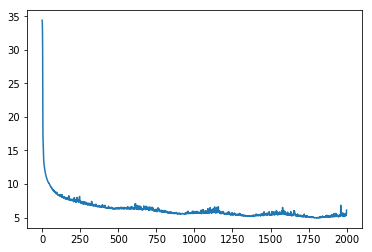

mean_absolute_error: 622.35%
Train on 16266 samples, validate on 1807 samples
Epoch 1/2000
12000/16266 [=====================>........] - ETA: 0s - loss: 34.1872 - mean_absolute_error: 34.1872

C:\Users\shaltaf\AppData\Local\conda\conda\envs\neural\lib\site-packages\keras\callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.118583). Check your callbacks.
  % delta_t_median)


16266/16266 [==============================] - 1s 57us/step - loss: 33.7502 - mean_absolute_error: 33.7502 - val_loss: 30.8675 - val_mean_absolute_error: 30.8675
Epoch 2/2000
16266/16266 [==============================] - 0s 7us/step - loss: 23.8914 - mean_absolute_error: 23.8914 - val_loss: 18.2810 - val_mean_absolute_error: 18.2810
Epoch 3/2000
16266/16266 [==============================] - 0s 7us/step - loss: 17.1763 - mean_absolute_error: 17.1763 - val_loss: 15.8175 - val_mean_absolute_error: 15.8175
Epoch 4/2000
16266/16266 [==============================] - 0s 7us/step - loss: 14.9503 - mean_absolute_error: 14.9503 - val_loss: 13.8139 - val_mean_absolute_error: 13.8139
Epoch 5/2000
16266/16266 [==============================] - 0s 7us/step - loss: 13.7048 - mean_absolute_error: 13.7048 - val_loss: 13.1379 - val_mean_absolute_error: 13.1379
Epoch 6/2000
16266/16266 [==============================] - 0s 7us/step - loss: 12.9620 - mean_absolute_error: 12.9620 - val_loss: 12.2698 - v

Epoch 96/2000
16266/16266 [==============================] - 0s 7us/step - loss: 8.0676 - mean_absolute_error: 8.0676 - val_loss: 8.0501 - val_mean_absolute_error: 8.0501
Epoch 97/2000
16266/16266 [==============================] - 0s 7us/step - loss: 8.0692 - mean_absolute_error: 8.0692 - val_loss: 8.1515 - val_mean_absolute_error: 8.1515
Epoch 98/2000
16266/16266 [==============================] - 0s 7us/step - loss: 8.0532 - mean_absolute_error: 8.0532 - val_loss: 8.2838 - val_mean_absolute_error: 8.2838
Epoch 99/2000
16266/16266 [==============================] - 0s 7us/step - loss: 8.1279 - mean_absolute_error: 8.1279 - val_loss: 8.0870 - val_mean_absolute_error: 8.0870
Epoch 100/2000
16266/16266 [==============================] - 0s 7us/step - loss: 8.1511 - mean_absolute_error: 8.1511 - val_loss: 8.6570 - val_mean_absolute_error: 8.6570
Epoch 101/2000
16266/16266 [==============================] - 0s 6us/step - loss: 8.4607 - mean_absolute_error: 8.4607 - val_loss: 8.1298 - val_

Epoch 191/2000
16266/16266 [==============================] - 0s 7us/step - loss: 7.4087 - mean_absolute_error: 7.4087 - val_loss: 7.6181 - val_mean_absolute_error: 7.6181
Epoch 192/2000
16266/16266 [==============================] - 0s 7us/step - loss: 7.3963 - mean_absolute_error: 7.3963 - val_loss: 7.6959 - val_mean_absolute_error: 7.6959
Epoch 193/2000
16266/16266 [==============================] - 0s 7us/step - loss: 7.4448 - mean_absolute_error: 7.4448 - val_loss: 7.5872 - val_mean_absolute_error: 7.5872
Epoch 194/2000
16266/16266 [==============================] - 0s 7us/step - loss: 7.3570 - mean_absolute_error: 7.3570 - val_loss: 7.6234 - val_mean_absolute_error: 7.6234
Epoch 195/2000
16266/16266 [==============================] - 0s 8us/step - loss: 7.3430 - mean_absolute_error: 7.3430 - val_loss: 7.5946 - val_mean_absolute_error: 7.5946
Epoch 196/2000
16266/16266 [==============================] - 0s 7us/step - loss: 7.3598 - mean_absolute_error: 7.3598 - val_loss: 7.5785 - 

Epoch 286/2000
16266/16266 [==============================] - 0s 7us/step - loss: 7.1112 - mean_absolute_error: 7.1112 - val_loss: 7.5352 - val_mean_absolute_error: 7.5352
Epoch 287/2000
16266/16266 [==============================] - 0s 7us/step - loss: 7.1212 - mean_absolute_error: 7.1212 - val_loss: 7.4588 - val_mean_absolute_error: 7.4588
Epoch 288/2000
16266/16266 [==============================] - 0s 7us/step - loss: 7.1372 - mean_absolute_error: 7.1372 - val_loss: 7.4333 - val_mean_absolute_error: 7.4333
Epoch 289/2000
16266/16266 [==============================] - 0s 8us/step - loss: 7.1313 - mean_absolute_error: 7.1313 - val_loss: 7.4738 - val_mean_absolute_error: 7.4738
Epoch 290/2000
16266/16266 [==============================] - 0s 7us/step - loss: 7.1345 - mean_absolute_error: 7.1345 - val_loss: 7.6837 - val_mean_absolute_error: 7.6837
Epoch 291/2000
16266/16266 [==============================] - 0s 8us/step - loss: 7.1744 - mean_absolute_error: 7.1744 - val_loss: 7.4823 - 

Epoch 381/2000
16266/16266 [==============================] - 0s 6us/step - loss: 7.2835 - mean_absolute_error: 7.2835 - val_loss: 7.4712 - val_mean_absolute_error: 7.4712
Epoch 382/2000
16266/16266 [==============================] - 0s 7us/step - loss: 7.0069 - mean_absolute_error: 7.0069 - val_loss: 7.7680 - val_mean_absolute_error: 7.7680
Epoch 383/2000
16266/16266 [==============================] - 0s 7us/step - loss: 7.3422 - mean_absolute_error: 7.3422 - val_loss: 8.1925 - val_mean_absolute_error: 8.1925
Epoch 384/2000
16266/16266 [==============================] - 0s 7us/step - loss: 7.4600 - mean_absolute_error: 7.4600 - val_loss: 7.6710 - val_mean_absolute_error: 7.6710
Epoch 385/2000
16266/16266 [==============================] - 0s 7us/step - loss: 7.2316 - mean_absolute_error: 7.2316 - val_loss: 7.2717 - val_mean_absolute_error: 7.2717
Epoch 386/2000
16266/16266 [==============================] - 0s 7us/step - loss: 7.1230 - mean_absolute_error: 7.1230 - val_loss: 8.5214 - 

Epoch 476/2000
16266/16266 [==============================] - 0s 7us/step - loss: 6.9719 - mean_absolute_error: 6.9719 - val_loss: 7.4191 - val_mean_absolute_error: 7.4191
Epoch 477/2000
16266/16266 [==============================] - 0s 7us/step - loss: 7.0522 - mean_absolute_error: 7.0522 - val_loss: 7.8309 - val_mean_absolute_error: 7.8309
Epoch 478/2000
16266/16266 [==============================] - 0s 6us/step - loss: 7.0117 - mean_absolute_error: 7.0117 - val_loss: 7.1588 - val_mean_absolute_error: 7.1588
Epoch 479/2000
16266/16266 [==============================] - 0s 7us/step - loss: 6.9427 - mean_absolute_error: 6.9427 - val_loss: 7.3370 - val_mean_absolute_error: 7.3370
Epoch 480/2000
16266/16266 [==============================] - 0s 7us/step - loss: 6.8365 - mean_absolute_error: 6.8365 - val_loss: 7.6022 - val_mean_absolute_error: 7.6022
Epoch 481/2000
16266/16266 [==============================] - 0s 7us/step - loss: 6.8725 - mean_absolute_error: 6.8725 - val_loss: 7.1383 - 

Epoch 571/2000
16266/16266 [==============================] - 0s 7us/step - loss: 6.5485 - mean_absolute_error: 6.5485 - val_loss: 7.2689 - val_mean_absolute_error: 7.2689
Epoch 572/2000
16266/16266 [==============================] - 0s 7us/step - loss: 6.5527 - mean_absolute_error: 6.5527 - val_loss: 6.9659 - val_mean_absolute_error: 6.9659
Epoch 573/2000
16266/16266 [==============================] - 0s 7us/step - loss: 6.4355 - mean_absolute_error: 6.4355 - val_loss: 7.1915 - val_mean_absolute_error: 7.1915
Epoch 574/2000
16266/16266 [==============================] - 0s 7us/step - loss: 6.5695 - mean_absolute_error: 6.5695 - val_loss: 7.1233 - val_mean_absolute_error: 7.1233
Epoch 575/2000
16266/16266 [==============================] - 0s 7us/step - loss: 6.5638 - mean_absolute_error: 6.5638 - val_loss: 7.2356 - val_mean_absolute_error: 7.2356
Epoch 576/2000
16266/16266 [==============================] - 0s 7us/step - loss: 6.5202 - mean_absolute_error: 6.5202 - val_loss: 6.9159 - 

Epoch 666/2000
16266/16266 [==============================] - 0s 7us/step - loss: 6.3032 - mean_absolute_error: 6.3032 - val_loss: 6.8283 - val_mean_absolute_error: 6.8283
Epoch 667/2000
16266/16266 [==============================] - 0s 7us/step - loss: 6.1611 - mean_absolute_error: 6.1611 - val_loss: 6.8005 - val_mean_absolute_error: 6.8005
Epoch 668/2000
16266/16266 [==============================] - 0s 7us/step - loss: 6.1992 - mean_absolute_error: 6.1992 - val_loss: 6.8703 - val_mean_absolute_error: 6.8703
Epoch 669/2000
16266/16266 [==============================] - 0s 7us/step - loss: 6.2482 - mean_absolute_error: 6.2482 - val_loss: 6.8513 - val_mean_absolute_error: 6.8513
Epoch 670/2000
16266/16266 [==============================] - 0s 7us/step - loss: 6.1760 - mean_absolute_error: 6.1760 - val_loss: 6.8486 - val_mean_absolute_error: 6.8486
Epoch 671/2000
16266/16266 [==============================] - 0s 7us/step - loss: 6.1815 - mean_absolute_error: 6.1815 - val_loss: 6.8222 - 

Epoch 761/2000
16266/16266 [==============================] - 0s 7us/step - loss: 6.1881 - mean_absolute_error: 6.1881 - val_loss: 6.9075 - val_mean_absolute_error: 6.9075
Epoch 762/2000
16266/16266 [==============================] - 0s 9us/step - loss: 6.1804 - mean_absolute_error: 6.1804 - val_loss: 7.1030 - val_mean_absolute_error: 7.1030
Epoch 763/2000
16266/16266 [==============================] - 0s 11us/step - loss: 6.3640 - mean_absolute_error: 6.3640 - val_loss: 6.8522 - val_mean_absolute_error: 6.8522
Epoch 764/2000
16266/16266 [==============================] - 0s 10us/step - loss: 6.2290 - mean_absolute_error: 6.2290 - val_loss: 6.8456 - val_mean_absolute_error: 6.8456
Epoch 765/2000
16266/16266 [==============================] - 0s 10us/step - loss: 6.2067 - mean_absolute_error: 6.2067 - val_loss: 6.7823 - val_mean_absolute_error: 6.7823
Epoch 766/2000
16266/16266 [==============================] - 0s 8us/step - loss: 6.2956 - mean_absolute_error: 6.2956 - val_loss: 6.9516

Epoch 856/2000
16266/16266 [==============================] - 0s 7us/step - loss: 6.4276 - mean_absolute_error: 6.4276 - val_loss: 6.8087 - val_mean_absolute_error: 6.8087
Epoch 857/2000
16266/16266 [==============================] - 0s 8us/step - loss: 6.2752 - mean_absolute_error: 6.2752 - val_loss: 7.3483 - val_mean_absolute_error: 7.3483
Epoch 858/2000
16266/16266 [==============================] - 0s 8us/step - loss: 6.3786 - mean_absolute_error: 6.3786 - val_loss: 6.8034 - val_mean_absolute_error: 6.8034
Epoch 859/2000
16266/16266 [==============================] - 0s 7us/step - loss: 6.2330 - mean_absolute_error: 6.2330 - val_loss: 6.7648 - val_mean_absolute_error: 6.7648
Epoch 860/2000
16266/16266 [==============================] - 0s 7us/step - loss: 6.2356 - mean_absolute_error: 6.2356 - val_loss: 6.8471 - val_mean_absolute_error: 6.8471
Epoch 861/2000
16266/16266 [==============================] - 0s 7us/step - loss: 6.3046 - mean_absolute_error: 6.3046 - val_loss: 7.4858 - 

16266/16266 [==============================] - 0s 10us/step - loss: 6.1879 - mean_absolute_error: 6.1879 - val_loss: 6.7786 - val_mean_absolute_error: 6.7786
Epoch 951/2000
16266/16266 [==============================] - 0s 9us/step - loss: 6.1008 - mean_absolute_error: 6.1008 - val_loss: 6.7952 - val_mean_absolute_error: 6.7952
Epoch 952/2000
16266/16266 [==============================] - 0s 10us/step - loss: 6.1186 - mean_absolute_error: 6.1186 - val_loss: 6.7554 - val_mean_absolute_error: 6.7554
Epoch 953/2000
16266/16266 [==============================] - 0s 9us/step - loss: 6.1130 - mean_absolute_error: 6.1130 - val_loss: 6.8627 - val_mean_absolute_error: 6.8627
Epoch 954/2000
16266/16266 [==============================] - 0s 10us/step - loss: 6.1048 - mean_absolute_error: 6.1048 - val_loss: 6.8405 - val_mean_absolute_error: 6.8405
Epoch 955/2000
16266/16266 [==============================] - 0s 9us/step - loss: 6.1050 - mean_absolute_error: 6.1050 - val_loss: 6.8375 - val_mean_abs

Epoch 1044/2000
16266/16266 [==============================] - 0s 10us/step - loss: 6.0150 - mean_absolute_error: 6.0150 - val_loss: 6.8303 - val_mean_absolute_error: 6.8303
Epoch 1045/2000
16266/16266 [==============================] - 0s 9us/step - loss: 5.9597 - mean_absolute_error: 5.9597 - val_loss: 6.6164 - val_mean_absolute_error: 6.6164
Epoch 1046/2000
16266/16266 [==============================] - 0s 9us/step - loss: 5.9690 - mean_absolute_error: 5.9690 - val_loss: 6.7564 - val_mean_absolute_error: 6.7564
Epoch 1047/2000
16266/16266 [==============================] - 0s 9us/step - loss: 5.8820 - mean_absolute_error: 5.8820 - val_loss: 6.5989 - val_mean_absolute_error: 6.5989
Epoch 1048/2000
16266/16266 [==============================] - 0s 10us/step - loss: 5.8547 - mean_absolute_error: 5.8547 - val_loss: 6.7506 - val_mean_absolute_error: 6.7506
Epoch 1049/2000
16266/16266 [==============================] - 0s 10us/step - loss: 5.8673 - mean_absolute_error: 5.8673 - val_loss: 

16266/16266 [==============================] - 0s 9us/step - loss: 5.6477 - mean_absolute_error: 5.6477 - val_loss: 6.5927 - val_mean_absolute_error: 6.5927
Epoch 1139/2000
16266/16266 [==============================] - 0s 8us/step - loss: 5.6670 - mean_absolute_error: 5.6670 - val_loss: 6.6085 - val_mean_absolute_error: 6.6085
Epoch 1140/2000
16266/16266 [==============================] - 0s 8us/step - loss: 5.6415 - mean_absolute_error: 5.6415 - val_loss: 6.5879 - val_mean_absolute_error: 6.5879
Epoch 1141/2000
16266/16266 [==============================] - 0s 8us/step - loss: 5.6614 - mean_absolute_error: 5.6614 - val_loss: 6.6084 - val_mean_absolute_error: 6.6084
Epoch 1142/2000
16266/16266 [==============================] - 0s 8us/step - loss: 5.6472 - mean_absolute_error: 5.6472 - val_loss: 6.6767 - val_mean_absolute_error: 6.6767
Epoch 1143/2000
16266/16266 [==============================] - 0s 8us/step - loss: 5.6958 - mean_absolute_error: 5.6958 - val_loss: 6.5466 - val_mean_a

16266/16266 [==============================] - 0s 8us/step - loss: 6.0507 - mean_absolute_error: 6.0507 - val_loss: 7.1525 - val_mean_absolute_error: 7.1525
Epoch 1233/2000
16266/16266 [==============================] - 0s 8us/step - loss: 6.1604 - mean_absolute_error: 6.1604 - val_loss: 6.7678 - val_mean_absolute_error: 6.7678
Epoch 1234/2000
16266/16266 [==============================] - 0s 8us/step - loss: 5.8830 - mean_absolute_error: 5.8830 - val_loss: 6.8221 - val_mean_absolute_error: 6.8221
Epoch 1235/2000
16266/16266 [==============================] - 0s 8us/step - loss: 5.8761 - mean_absolute_error: 5.8761 - val_loss: 6.9796 - val_mean_absolute_error: 6.9796
Epoch 1236/2000
16266/16266 [==============================] - 0s 8us/step - loss: 5.9738 - mean_absolute_error: 5.9738 - val_loss: 7.2555 - val_mean_absolute_error: 7.2555
Epoch 1237/2000
16266/16266 [==============================] - 0s 8us/step - loss: 6.0674 - mean_absolute_error: 6.0674 - val_loss: 6.7888 - val_mean_a

16266/16266 [==============================] - 0s 10us/step - loss: 5.9411 - mean_absolute_error: 5.9411 - val_loss: 6.8274 - val_mean_absolute_error: 6.8274
Epoch 1327/2000
16266/16266 [==============================] - 0s 9us/step - loss: 5.9932 - mean_absolute_error: 5.9932 - val_loss: 6.7038 - val_mean_absolute_error: 6.7038
Epoch 1328/2000
16266/16266 [==============================] - 0s 9us/step - loss: 5.8924 - mean_absolute_error: 5.8924 - val_loss: 6.7916 - val_mean_absolute_error: 6.7916
Epoch 1329/2000
16266/16266 [==============================] - 0s 9us/step - loss: 5.9767 - mean_absolute_error: 5.9767 - val_loss: 6.8831 - val_mean_absolute_error: 6.8831
Epoch 1330/2000
16266/16266 [==============================] - 0s 9us/step - loss: 5.9991 - mean_absolute_error: 5.9991 - val_loss: 6.7487 - val_mean_absolute_error: 6.7487
Epoch 1331/2000
16266/16266 [==============================] - 0s 10us/step - loss: 6.1128 - mean_absolute_error: 6.1128 - val_loss: 6.8692 - val_mean

16266/16266 [==============================] - 0s 11us/step - loss: 5.8248 - mean_absolute_error: 5.8248 - val_loss: 6.8417 - val_mean_absolute_error: 6.8417
Epoch 1421/2000
16266/16266 [==============================] - 0s 8us/step - loss: 5.8260 - mean_absolute_error: 5.8260 - val_loss: 6.6611 - val_mean_absolute_error: 6.6611
Epoch 1422/2000
16266/16266 [==============================] - 0s 8us/step - loss: 5.7609 - mean_absolute_error: 5.7609 - val_loss: 6.9381 - val_mean_absolute_error: 6.9381
Epoch 1423/2000
16266/16266 [==============================] - 0s 9us/step - loss: 5.8350 - mean_absolute_error: 5.8350 - val_loss: 6.7536 - val_mean_absolute_error: 6.7536
Epoch 1424/2000
16266/16266 [==============================] - 0s 8us/step - loss: 5.8148 - mean_absolute_error: 5.8148 - val_loss: 6.6648 - val_mean_absolute_error: 6.6648
Epoch 1425/2000
16266/16266 [==============================] - 0s 9us/step - loss: 5.7561 - mean_absolute_error: 5.7561 - val_loss: 6.6194 - val_mean_

16266/16266 [==============================] - 0s 8us/step - loss: 5.4532 - mean_absolute_error: 5.4532 - val_loss: 6.5270 - val_mean_absolute_error: 6.5270
Epoch 1515/2000
16266/16266 [==============================] - 0s 8us/step - loss: 5.4629 - mean_absolute_error: 5.4629 - val_loss: 6.5799 - val_mean_absolute_error: 6.5799
Epoch 1516/2000
16266/16266 [==============================] - 0s 8us/step - loss: 5.4361 - mean_absolute_error: 5.4361 - val_loss: 6.5491 - val_mean_absolute_error: 6.5491
Epoch 1517/2000
16266/16266 [==============================] - 0s 9us/step - loss: 5.4544 - mean_absolute_error: 5.4544 - val_loss: 6.5262 - val_mean_absolute_error: 6.5262
Epoch 1518/2000
16266/16266 [==============================] - 0s 8us/step - loss: 5.4293 - mean_absolute_error: 5.4293 - val_loss: 6.4760 - val_mean_absolute_error: 6.4760
Epoch 1519/2000
16266/16266 [==============================] - 0s 8us/step - loss: 5.4494 - mean_absolute_error: 5.4494 - val_loss: 6.5104 - val_mean_a

16266/16266 [==============================] - 0s 10us/step - loss: 5.2931 - mean_absolute_error: 5.2931 - val_loss: 6.4801 - val_mean_absolute_error: 6.4801
Epoch 1609/2000
16266/16266 [==============================] - 0s 10us/step - loss: 5.4239 - mean_absolute_error: 5.4239 - val_loss: 6.5398 - val_mean_absolute_error: 6.5398
Epoch 1610/2000
16266/16266 [==============================] - 0s 9us/step - loss: 5.3756 - mean_absolute_error: 5.3756 - val_loss: 6.4721 - val_mean_absolute_error: 6.4721
Epoch 1611/2000
16266/16266 [==============================] - 0s 10us/step - loss: 5.3637 - mean_absolute_error: 5.3637 - val_loss: 6.5764 - val_mean_absolute_error: 6.5764
Epoch 1612/2000
16266/16266 [==============================] - 0s 9us/step - loss: 5.3958 - mean_absolute_error: 5.3958 - val_loss: 6.7276 - val_mean_absolute_error: 6.7276
Epoch 1613/2000
16266/16266 [==============================] - 0s 10us/step - loss: 5.4097 - mean_absolute_error: 5.4097 - val_loss: 6.7086 - val_me

16266/16266 [==============================] - 0s 10us/step - loss: 5.5358 - mean_absolute_error: 5.5358 - val_loss: 6.5598 - val_mean_absolute_error: 6.5598
Epoch 1703/2000
16266/16266 [==============================] - 0s 9us/step - loss: 5.5162 - mean_absolute_error: 5.5162 - val_loss: 6.6422 - val_mean_absolute_error: 6.6422
Epoch 1704/2000
16266/16266 [==============================] - 0s 9us/step - loss: 5.4784 - mean_absolute_error: 5.4784 - val_loss: 6.5377 - val_mean_absolute_error: 6.5377
Epoch 1705/2000
16266/16266 [==============================] - 0s 11us/step - loss: 5.5550 - mean_absolute_error: 5.5550 - val_loss: 6.6466 - val_mean_absolute_error: 6.6466
Epoch 1706/2000
16266/16266 [==============================] - 0s 9us/step - loss: 5.5350 - mean_absolute_error: 5.5350 - val_loss: 6.7909 - val_mean_absolute_error: 6.7909
Epoch 1707/2000
16266/16266 [==============================] - 0s 9us/step - loss: 5.7733 - mean_absolute_error: 5.7733 - val_loss: 7.1220 - val_mean

16266/16266 [==============================] - 0s 9us/step - loss: 5.6411 - mean_absolute_error: 5.6411 - val_loss: 6.7567 - val_mean_absolute_error: 6.7567
Epoch 1750/2000
16266/16266 [==============================] - 0s 10us/step - loss: 5.6450 - mean_absolute_error: 5.6450 - val_loss: 7.1990 - val_mean_absolute_error: 7.1990
Epoch 1751/2000
16266/16266 [==============================] - 0s 9us/step - loss: 5.9066 - mean_absolute_error: 5.9066 - val_loss: 7.3034 - val_mean_absolute_error: 7.3034
Epoch 1752/2000
16266/16266 [==============================] - 0s 9us/step - loss: 5.9880 - mean_absolute_error: 5.9880 - val_loss: 6.8541 - val_mean_absolute_error: 6.8541
Epoch 1753/2000
16266/16266 [==============================] - 0s 9us/step - loss: 5.8207 - mean_absolute_error: 5.8207 - val_loss: 6.7203 - val_mean_absolute_error: 6.7203
Epoch 1754/2000
16266/16266 [==============================] - 0s 9us/step - loss: 5.6354 - mean_absolute_error: 5.6354 - val_loss: 6.5923 - val_mean_

Epoch 1843/2000
16266/16266 [==============================] - 0s 10us/step - loss: 5.4833 - mean_absolute_error: 5.4833 - val_loss: 6.6853 - val_mean_absolute_error: 6.6853
Epoch 1844/2000
16266/16266 [==============================] - 0s 10us/step - loss: 5.5963 - mean_absolute_error: 5.5963 - val_loss: 6.5320 - val_mean_absolute_error: 6.5320
Epoch 1845/2000
16266/16266 [==============================] - 0s 9us/step - loss: 5.5790 - mean_absolute_error: 5.5790 - val_loss: 6.7132 - val_mean_absolute_error: 6.7132
Epoch 1846/2000
16266/16266 [==============================] - 0s 9us/step - loss: 5.5007 - mean_absolute_error: 5.5007 - val_loss: 6.5091 - val_mean_absolute_error: 6.5091
Epoch 1847/2000
16266/16266 [==============================] - 0s 9us/step - loss: 5.5618 - mean_absolute_error: 5.5618 - val_loss: 7.3447 - val_mean_absolute_error: 7.3447
Epoch 1848/2000
16266/16266 [==============================] - 0s 10us/step - loss: 5.7807 - mean_absolute_error: 5.7807 - val_loss: 

16266/16266 [==============================] - 0s 9us/step - loss: 5.4064 - mean_absolute_error: 5.4064 - val_loss: 6.7075 - val_mean_absolute_error: 6.7075
Epoch 1938/2000
16266/16266 [==============================] - 0s 10us/step - loss: 5.4457 - mean_absolute_error: 5.4457 - val_loss: 6.6180 - val_mean_absolute_error: 6.6180
Epoch 1939/2000
16266/16266 [==============================] - 0s 9us/step - loss: 5.3298 - mean_absolute_error: 5.3298 - val_loss: 6.5091 - val_mean_absolute_error: 6.5091
Epoch 1940/2000
16266/16266 [==============================] - 0s 9us/step - loss: 5.2921 - mean_absolute_error: 5.2921 - val_loss: 6.5558 - val_mean_absolute_error: 6.5558
Epoch 1941/2000
16266/16266 [==============================] - 0s 9us/step - loss: 5.2890 - mean_absolute_error: 5.2890 - val_loss: 6.6960 - val_mean_absolute_error: 6.6960
Epoch 1942/2000
16266/16266 [==============================] - 0s 9us/step - loss: 5.3420 - mean_absolute_error: 5.3420 - val_loss: 6.7011 - val_mean_

Epoch 1984/2000
16266/16266 [==============================] - 0s 11us/step - loss: 5.2639 - mean_absolute_error: 5.2639 - val_loss: 6.4360 - val_mean_absolute_error: 6.4360
Epoch 1985/2000
16266/16266 [==============================] - 0s 10us/step - loss: 5.1526 - mean_absolute_error: 5.1526 - val_loss: 6.3992 - val_mean_absolute_error: 6.3992
Epoch 1986/2000
16266/16266 [==============================] - 0s 9us/step - loss: 5.1180 - mean_absolute_error: 5.1180 - val_loss: 6.3690 - val_mean_absolute_error: 6.3690
Epoch 1987/2000
16266/16266 [==============================] - 0s 10us/step - loss: 5.1379 - mean_absolute_error: 5.1379 - val_loss: 6.3945 - val_mean_absolute_error: 6.3945
Epoch 1988/2000
16266/16266 [==============================] - 0s 9us/step - loss: 5.1233 - mean_absolute_error: 5.1233 - val_loss: 6.4111 - val_mean_absolute_error: 6.4111
Epoch 1989/2000
16266/16266 [==============================] - 0s 9us/step - loss: 5.1606 - mean_absolute_error: 5.1606 - val_loss: 

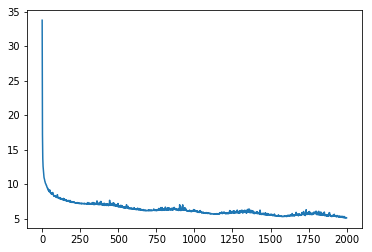

mean_absolute_error: 651.30%
Train on 16266 samples, validate on 1807 samples
Epoch 1/2000
12000/16266 [=====================>........] - ETA: 0s - loss: 34.3031 - mean_absolute_error: 34.3031

C:\Users\shaltaf\AppData\Local\conda\conda\envs\neural\lib\site-packages\keras\callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.142964). Check your callbacks.
  % delta_t_median)


16266/16266 [==============================] - 1s 64us/step - loss: 34.2026 - mean_absolute_error: 34.2026 - val_loss: 35.3797 - val_mean_absolute_error: 35.3797
Epoch 2/2000
16266/16266 [==============================] - 0s 10us/step - loss: 33.9621 - mean_absolute_error: 33.9621 - val_loss: 34.8180 - val_mean_absolute_error: 34.8180
Epoch 3/2000
16266/16266 [==============================] - 0s 9us/step - loss: 32.9919 - mean_absolute_error: 32.9919 - val_loss: 33.1085 - val_mean_absolute_error: 33.1085
Epoch 4/2000
16266/16266 [==============================] - 0s 10us/step - loss: 30.7876 - mean_absolute_error: 30.7876 - val_loss: 29.3286 - val_mean_absolute_error: 29.3286
Epoch 5/2000
16266/16266 [==============================] - 0s 9us/step - loss: 25.6190 - mean_absolute_error: 25.6190 - val_loss: 21.5126 - val_mean_absolute_error: 21.5126
Epoch 6/2000
16266/16266 [==============================] - 0s 9us/step - loss: 18.1523 - mean_absolute_error: 18.1523 - val_loss: 17.2552 -

Epoch 48/2000
16266/16266 [==============================] - 0s 9us/step - loss: 9.5680 - mean_absolute_error: 9.5680 - val_loss: 9.9896 - val_mean_absolute_error: 9.9896
Epoch 49/2000
16266/16266 [==============================] - 0s 9us/step - loss: 9.5370 - mean_absolute_error: 9.5370 - val_loss: 10.0076 - val_mean_absolute_error: 10.0076
Epoch 50/2000
16266/16266 [==============================] - 0s 8us/step - loss: 9.5060 - mean_absolute_error: 9.5060 - val_loss: 9.9798 - val_mean_absolute_error: 9.9798
Epoch 51/2000
16266/16266 [==============================] - 0s 8us/step - loss: 9.4775 - mean_absolute_error: 9.4775 - val_loss: 9.9047 - val_mean_absolute_error: 9.9047
Epoch 52/2000
16266/16266 [==============================] - 0s 9us/step - loss: 9.4481 - mean_absolute_error: 9.4481 - val_loss: 9.8906 - val_mean_absolute_error: 9.8906
Epoch 53/2000
16266/16266 [==============================] - 0s 10us/step - loss: 9.4191 - mean_absolute_error: 9.4191 - val_loss: 9.9990 - val

Epoch 96/2000
16266/16266 [==============================] - 0s 9us/step - loss: 8.3475 - mean_absolute_error: 8.3475 - val_loss: 8.9029 - val_mean_absolute_error: 8.9029
Epoch 97/2000
16266/16266 [==============================] - 0s 8us/step - loss: 8.3442 - mean_absolute_error: 8.3442 - val_loss: 8.9360 - val_mean_absolute_error: 8.9360
Epoch 98/2000
16266/16266 [==============================] - 0s 8us/step - loss: 8.3732 - mean_absolute_error: 8.3732 - val_loss: 9.0992 - val_mean_absolute_error: 9.0992
Epoch 99/2000
16266/16266 [==============================] - 0s 8us/step - loss: 8.3856 - mean_absolute_error: 8.3856 - val_loss: 8.9755 - val_mean_absolute_error: 8.9755
Epoch 100/2000
16266/16266 [==============================] - 0s 8us/step - loss: 8.4005 - mean_absolute_error: 8.4005 - val_loss: 9.2791 - val_mean_absolute_error: 9.2791
Epoch 101/2000
16266/16266 [==============================] - 0s 8us/step - loss: 8.5177 - mean_absolute_error: 8.5177 - val_loss: 9.0656 - val_

Epoch 190/2000
16266/16266 [==============================] - 0s 8us/step - loss: 7.3326 - mean_absolute_error: 7.3326 - val_loss: 8.5358 - val_mean_absolute_error: 8.5358
Epoch 191/2000
16266/16266 [==============================] - 0s 8us/step - loss: 7.4773 - mean_absolute_error: 7.4773 - val_loss: 8.4952 - val_mean_absolute_error: 8.4952
Epoch 192/2000
16266/16266 [==============================] - 0s 8us/step - loss: 7.4080 - mean_absolute_error: 7.4080 - val_loss: 8.3286 - val_mean_absolute_error: 8.3286
Epoch 193/2000
16266/16266 [==============================] - 0s 9us/step - loss: 7.3088 - mean_absolute_error: 7.3088 - val_loss: 8.6934 - val_mean_absolute_error: 8.6934
Epoch 194/2000
16266/16266 [==============================] - 0s 9us/step - loss: 7.3691 - mean_absolute_error: 7.3691 - val_loss: 8.3144 - val_mean_absolute_error: 8.3144
Epoch 195/2000
16266/16266 [==============================] - 0s 9us/step - loss: 7.2823 - mean_absolute_error: 7.2823 - val_loss: 8.2585 - 

Epoch 285/2000
16266/16266 [==============================] - 0s 9us/step - loss: 6.6950 - mean_absolute_error: 6.6950 - val_loss: 8.4380 - val_mean_absolute_error: 8.4380
Epoch 286/2000
16266/16266 [==============================] - 0s 8us/step - loss: 6.9398 - mean_absolute_error: 6.9398 - val_loss: 7.9923 - val_mean_absolute_error: 7.9923
Epoch 287/2000
16266/16266 [==============================] - 0s 9us/step - loss: 6.8351 - mean_absolute_error: 6.8351 - val_loss: 8.2186 - val_mean_absolute_error: 8.2186
Epoch 288/2000
16266/16266 [==============================] - 0s 9us/step - loss: 6.7633 - mean_absolute_error: 6.7633 - val_loss: 7.9393 - val_mean_absolute_error: 7.9393
Epoch 289/2000
16266/16266 [==============================] - 0s 9us/step - loss: 6.6869 - mean_absolute_error: 6.6869 - val_loss: 8.6907 - val_mean_absolute_error: 8.6907
Epoch 290/2000
16266/16266 [==============================] - 0s 8us/step - loss: 6.9856 - mean_absolute_error: 6.9856 - val_loss: 7.9681 - 

16266/16266 [==============================] - 0s 8us/step - loss: 6.5995 - mean_absolute_error: 6.5995 - val_loss: 7.8355 - val_mean_absolute_error: 7.8355
Epoch 333/2000
16266/16266 [==============================] - 0s 8us/step - loss: 6.6367 - mean_absolute_error: 6.6367 - val_loss: 7.7988 - val_mean_absolute_error: 7.7988
Epoch 334/2000
16266/16266 [==============================] - 0s 8us/step - loss: 6.4560 - mean_absolute_error: 6.4560 - val_loss: 7.7903 - val_mean_absolute_error: 7.7903
Epoch 335/2000
16266/16266 [==============================] - 0s 8us/step - loss: 6.4780 - mean_absolute_error: 6.4780 - val_loss: 7.7810 - val_mean_absolute_error: 7.7810
Epoch 336/2000
16266/16266 [==============================] - 0s 8us/step - loss: 6.5303 - mean_absolute_error: 6.5303 - val_loss: 7.7582 - val_mean_absolute_error: 7.7582
Epoch 337/2000
16266/16266 [==============================] - 0s 8us/step - loss: 6.5347 - mean_absolute_error: 6.5347 - val_loss: 8.0272 - val_mean_absolu

16266/16266 [==============================] - 0s 8us/step - loss: 6.1022 - mean_absolute_error: 6.1022 - val_loss: 7.6417 - val_mean_absolute_error: 7.6417
Epoch 427/2000
16266/16266 [==============================] - 0s 8us/step - loss: 6.1421 - mean_absolute_error: 6.1421 - val_loss: 7.5911 - val_mean_absolute_error: 7.5911
Epoch 428/2000
16266/16266 [==============================] - 0s 8us/step - loss: 6.1197 - mean_absolute_error: 6.1197 - val_loss: 7.5600 - val_mean_absolute_error: 7.5600
Epoch 429/2000
16266/16266 [==============================] - 0s 9us/step - loss: 6.1117 - mean_absolute_error: 6.1117 - val_loss: 7.5715 - val_mean_absolute_error: 7.5715
Epoch 430/2000
16266/16266 [==============================] - 0s 9us/step - loss: 6.1095 - mean_absolute_error: 6.1095 - val_loss: 7.6284 - val_mean_absolute_error: 7.6284
Epoch 431/2000
16266/16266 [==============================] - 0s 9us/step - loss: 6.2046 - mean_absolute_error: 6.2046 - val_loss: 7.5267 - val_mean_absolu

Epoch 474/2000
16266/16266 [==============================] - 0s 9us/step - loss: 6.0501 - mean_absolute_error: 6.0501 - val_loss: 7.5582 - val_mean_absolute_error: 7.5582
Epoch 475/2000
16266/16266 [==============================] - 0s 11us/step - loss: 6.0251 - mean_absolute_error: 6.0251 - val_loss: 7.5426 - val_mean_absolute_error: 7.5426
Epoch 476/2000
16266/16266 [==============================] - 0s 13us/step - loss: 6.0104 - mean_absolute_error: 6.0104 - val_loss: 7.5184 - val_mean_absolute_error: 7.5184
Epoch 477/2000
16266/16266 [==============================] - 0s 10us/step - loss: 6.0545 - mean_absolute_error: 6.0545 - val_loss: 7.5167 - val_mean_absolute_error: 7.5167
Epoch 478/2000
16266/16266 [==============================] - 0s 8us/step - loss: 6.0054 - mean_absolute_error: 6.0054 - val_loss: 7.5879 - val_mean_absolute_error: 7.5879
Epoch 479/2000
16266/16266 [==============================] - 0s 8us/step - loss: 6.0094 - mean_absolute_error: 6.0094 - val_loss: 7.5000

Epoch 569/2000
16266/16266 [==============================] - 0s 8us/step - loss: 6.2397 - mean_absolute_error: 6.2397 - val_loss: 7.5215 - val_mean_absolute_error: 7.5215
Epoch 570/2000
16266/16266 [==============================] - 0s 8us/step - loss: 6.0227 - mean_absolute_error: 6.0227 - val_loss: 7.6042 - val_mean_absolute_error: 7.6042
Epoch 571/2000
16266/16266 [==============================] - 0s 10us/step - loss: 5.9713 - mean_absolute_error: 5.9713 - val_loss: 7.5396 - val_mean_absolute_error: 7.5396
Epoch 572/2000
16266/16266 [==============================] - 0s 11us/step - loss: 6.0314 - mean_absolute_error: 6.0314 - val_loss: 7.5117 - val_mean_absolute_error: 7.5117
Epoch 573/2000
16266/16266 [==============================] - 0s 9us/step - loss: 6.0475 - mean_absolute_error: 6.0475 - val_loss: 7.5779 - val_mean_absolute_error: 7.5779
Epoch 574/2000
16266/16266 [==============================] - 0s 9us/step - loss: 6.1248 - mean_absolute_error: 6.1248 - val_loss: 7.5779 

16266/16266 [==============================] - 0s 9us/step - loss: 6.0754 - mean_absolute_error: 6.0754 - val_loss: 7.7540 - val_mean_absolute_error: 7.7540
Epoch 664/2000
16266/16266 [==============================] - 0s 9us/step - loss: 6.2772 - mean_absolute_error: 6.2772 - val_loss: 7.3699 - val_mean_absolute_error: 7.3699
Epoch 665/2000
16266/16266 [==============================] - 0s 8us/step - loss: 6.1280 - mean_absolute_error: 6.1280 - val_loss: 7.6205 - val_mean_absolute_error: 7.6205
Epoch 666/2000
16266/16266 [==============================] - 0s 11us/step - loss: 6.0615 - mean_absolute_error: 6.0615 - val_loss: 7.6289 - val_mean_absolute_error: 7.6289
Epoch 667/2000
16266/16266 [==============================] - 0s 18us/step - loss: 6.0553 - mean_absolute_error: 6.0553 - val_loss: 7.4965 - val_mean_absolute_error: 7.4965
Epoch 668/2000
16266/16266 [==============================] - 0s 16us/step - loss: 6.0449 - mean_absolute_error: 6.0449 - val_loss: 7.5046 - val_mean_abs

Epoch 710/2000
16266/16266 [==============================] - 0s 8us/step - loss: 5.8031 - mean_absolute_error: 5.8031 - val_loss: 7.8833 - val_mean_absolute_error: 7.8833
Epoch 711/2000
16266/16266 [==============================] - 0s 8us/step - loss: 6.1210 - mean_absolute_error: 6.1210 - val_loss: 7.5452 - val_mean_absolute_error: 7.5452
Epoch 712/2000
16266/16266 [==============================] - 0s 8us/step - loss: 5.9057 - mean_absolute_error: 5.9057 - val_loss: 7.3920 - val_mean_absolute_error: 7.3920
Epoch 713/2000
16266/16266 [==============================] - 0s 9us/step - loss: 5.9862 - mean_absolute_error: 5.9862 - val_loss: 7.3900 - val_mean_absolute_error: 7.3900
Epoch 714/2000
16266/16266 [==============================] - 0s 8us/step - loss: 5.9154 - mean_absolute_error: 5.9154 - val_loss: 7.4641 - val_mean_absolute_error: 7.4641
Epoch 715/2000
16266/16266 [==============================] - 0s 8us/step - loss: 5.8940 - mean_absolute_error: 5.8940 - val_loss: 7.6898 - 

Epoch 805/2000
16266/16266 [==============================] - 0s 8us/step - loss: 5.4132 - mean_absolute_error: 5.4132 - val_loss: 7.1108 - val_mean_absolute_error: 7.1108
Epoch 806/2000
16266/16266 [==============================] - 0s 8us/step - loss: 5.4356 - mean_absolute_error: 5.4356 - val_loss: 7.0965 - val_mean_absolute_error: 7.0965
Epoch 807/2000
16266/16266 [==============================] - 0s 8us/step - loss: 5.4167 - mean_absolute_error: 5.4167 - val_loss: 7.1233 - val_mean_absolute_error: 7.1233
Epoch 808/2000
16266/16266 [==============================] - 0s 8us/step - loss: 5.4220 - mean_absolute_error: 5.4220 - val_loss: 7.0579 - val_mean_absolute_error: 7.0579
Epoch 809/2000
16266/16266 [==============================] - 0s 8us/step - loss: 5.3514 - mean_absolute_error: 5.3514 - val_loss: 7.0727 - val_mean_absolute_error: 7.0727
Epoch 810/2000
16266/16266 [==============================] - 0s 8us/step - loss: 5.3244 - mean_absolute_error: 5.3244 - val_loss: 6.9711 - 

Epoch 900/2000
16266/16266 [==============================] - 0s 8us/step - loss: 5.0689 - mean_absolute_error: 5.0689 - val_loss: 6.8117 - val_mean_absolute_error: 6.8117
Epoch 901/2000
16266/16266 [==============================] - 0s 8us/step - loss: 5.1072 - mean_absolute_error: 5.1072 - val_loss: 6.8325 - val_mean_absolute_error: 6.8325
Epoch 902/2000
16266/16266 [==============================] - 0s 8us/step - loss: 5.0806 - mean_absolute_error: 5.0806 - val_loss: 6.8057 - val_mean_absolute_error: 6.8057
Epoch 903/2000
16266/16266 [==============================] - 0s 8us/step - loss: 5.0817 - mean_absolute_error: 5.0817 - val_loss: 6.8550 - val_mean_absolute_error: 6.8550
Epoch 904/2000
16266/16266 [==============================] - 0s 8us/step - loss: 5.0874 - mean_absolute_error: 5.0874 - val_loss: 6.9551 - val_mean_absolute_error: 6.9551
Epoch 905/2000
16266/16266 [==============================] - 0s 8us/step - loss: 5.1147 - mean_absolute_error: 5.1147 - val_loss: 6.8892 - 

Epoch 947/2000
16266/16266 [==============================] - 0s 8us/step - loss: 5.1045 - mean_absolute_error: 5.1045 - val_loss: 6.8810 - val_mean_absolute_error: 6.8810
Epoch 948/2000
16266/16266 [==============================] - 0s 8us/step - loss: 5.0996 - mean_absolute_error: 5.0996 - val_loss: 6.8207 - val_mean_absolute_error: 6.8207
Epoch 949/2000
16266/16266 [==============================] - 0s 8us/step - loss: 5.0686 - mean_absolute_error: 5.0686 - val_loss: 6.7874 - val_mean_absolute_error: 6.7874
Epoch 950/2000
16266/16266 [==============================] - 0s 11us/step - loss: 5.0810 - mean_absolute_error: 5.0810 - val_loss: 6.9573 - val_mean_absolute_error: 6.9573
Epoch 951/2000
16266/16266 [==============================] - 0s 8us/step - loss: 5.0585 - mean_absolute_error: 5.0585 - val_loss: 6.8243 - val_mean_absolute_error: 6.8243
Epoch 952/2000
16266/16266 [==============================] - 0s 8us/step - loss: 5.0698 - mean_absolute_error: 5.0698 - val_loss: 6.8157 -

16266/16266 [==============================] - 0s 8us/step - loss: 5.2987 - mean_absolute_error: 5.2987 - val_loss: 7.2171 - val_mean_absolute_error: 7.2171
Epoch 1042/2000
16266/16266 [==============================] - 0s 8us/step - loss: 5.6205 - mean_absolute_error: 5.6205 - val_loss: 6.9525 - val_mean_absolute_error: 6.9525
Epoch 1043/2000
16266/16266 [==============================] - 0s 8us/step - loss: 5.2821 - mean_absolute_error: 5.2821 - val_loss: 6.9248 - val_mean_absolute_error: 6.9248
Epoch 1044/2000
16266/16266 [==============================] - 0s 8us/step - loss: 5.2549 - mean_absolute_error: 5.2549 - val_loss: 6.8265 - val_mean_absolute_error: 6.8265
Epoch 1045/2000
16266/16266 [==============================] - 0s 8us/step - loss: 5.2836 - mean_absolute_error: 5.2836 - val_loss: 6.9052 - val_mean_absolute_error: 6.9052
Epoch 1046/2000
16266/16266 [==============================] - 0s 8us/step - loss: 5.2720 - mean_absolute_error: 5.2720 - val_loss: 6.9484 - val_mean_a

16266/16266 [==============================] - 0s 15us/step - loss: 5.5281 - mean_absolute_error: 5.5281 - val_loss: 7.2474 - val_mean_absolute_error: 7.2474
Epoch 1136/2000
16266/16266 [==============================] - 0s 11us/step - loss: 5.3913 - mean_absolute_error: 5.3913 - val_loss: 7.0115 - val_mean_absolute_error: 7.0115
Epoch 1137/2000
16266/16266 [==============================] - ETA: 0s - loss: 5.2914 - mean_absolute_error: 5.291 - 0s 11us/step - loss: 5.2837 - mean_absolute_error: 5.2837 - val_loss: 7.5905 - val_mean_absolute_error: 7.5905
Epoch 1138/2000
16266/16266 [==============================] - 0s 10us/step - loss: 5.5319 - mean_absolute_error: 5.5319 - val_loss: 6.9683 - val_mean_absolute_error: 6.9683
Epoch 1139/2000
16266/16266 [==============================] - 0s 8us/step - loss: 5.2775 - mean_absolute_error: 5.2775 - val_loss: 6.8975 - val_mean_absolute_error: 6.8975
Epoch 1140/2000
16266/16266 [==============================] - 0s 8us/step - loss: 5.1932 - m

16266/16266 [==============================] - 0s 8us/step - loss: 5.0502 - mean_absolute_error: 5.0502 - val_loss: 6.7900 - val_mean_absolute_error: 6.7900
Epoch 1229/2000
16266/16266 [==============================] - 0s 9us/step - loss: 5.0519 - mean_absolute_error: 5.0519 - val_loss: 6.7871 - val_mean_absolute_error: 6.7871
Epoch 1230/2000
16266/16266 [==============================] - 0s 9us/step - loss: 4.9484 - mean_absolute_error: 4.9484 - val_loss: 6.7932 - val_mean_absolute_error: 6.7932
Epoch 1231/2000
16266/16266 [==============================] - 0s 9us/step - loss: 4.9299 - mean_absolute_error: 4.9299 - val_loss: 6.7030 - val_mean_absolute_error: 6.7030
Epoch 1232/2000
16266/16266 [==============================] - 0s 8us/step - loss: 4.9175 - mean_absolute_error: 4.9175 - val_loss: 6.8476 - val_mean_absolute_error: 6.8476
Epoch 1233/2000
16266/16266 [==============================] - 0s 8us/step - loss: 4.9595 - mean_absolute_error: 4.9595 - val_loss: 6.6512 - val_mean_a

16266/16266 [==============================] - 0s 9us/step - loss: 4.7949 - mean_absolute_error: 4.7949 - val_loss: 6.6937 - val_mean_absolute_error: 6.6937
Epoch 1323/2000
16266/16266 [==============================] - 0s 8us/step - loss: 4.7402 - mean_absolute_error: 4.7402 - val_loss: 6.6313 - val_mean_absolute_error: 6.6313
Epoch 1324/2000
16266/16266 [==============================] - 0s 8us/step - loss: 4.8206 - mean_absolute_error: 4.8206 - val_loss: 6.7070 - val_mean_absolute_error: 6.7070
Epoch 1325/2000
16266/16266 [==============================] - 0s 8us/step - loss: 4.7759 - mean_absolute_error: 4.7759 - val_loss: 6.5880 - val_mean_absolute_error: 6.5880
Epoch 1326/2000
16266/16266 [==============================] - 0s 8us/step - loss: 4.7617 - mean_absolute_error: 4.7617 - val_loss: 6.6446 - val_mean_absolute_error: 6.6446
Epoch 1327/2000
16266/16266 [==============================] - ETA: 0s - loss: 4.6815 - mean_absolute_error: 4.681 - 0s 8us/step - loss: 4.7313 - mean_

16266/16266 [==============================] - 0s 8us/step - loss: 4.8279 - mean_absolute_error: 4.8279 - val_loss: 6.6271 - val_mean_absolute_error: 6.6271
Epoch 1370/2000
16266/16266 [==============================] - 0s 8us/step - loss: 4.7256 - mean_absolute_error: 4.7256 - val_loss: 6.6142 - val_mean_absolute_error: 6.6142
Epoch 1371/2000
16266/16266 [==============================] - 0s 9us/step - loss: 4.7064 - mean_absolute_error: 4.7064 - val_loss: 6.6784 - val_mean_absolute_error: 6.6784
Epoch 1372/2000
16266/16266 [==============================] - 0s 9us/step - loss: 4.6894 - mean_absolute_error: 4.6894 - val_loss: 6.6582 - val_mean_absolute_error: 6.6582
Epoch 1373/2000
16266/16266 [==============================] - 0s 8us/step - loss: 4.7499 - mean_absolute_error: 4.7499 - val_loss: 6.6807 - val_mean_absolute_error: 6.6807
Epoch 1374/2000
16266/16266 [==============================] - 0s 8us/step - loss: 4.7156 - mean_absolute_error: 4.7156 - val_loss: 6.6101 - val_mean_a

16266/16266 [==============================] - 0s 8us/step - loss: 5.0030 - mean_absolute_error: 5.0030 - val_loss: 6.9486 - val_mean_absolute_error: 6.9486
Epoch 1463/2000
16266/16266 [==============================] - 0s 8us/step - loss: 4.9614 - mean_absolute_error: 4.9614 - val_loss: 6.7643 - val_mean_absolute_error: 6.7643
Epoch 1464/2000
16266/16266 [==============================] - 0s 8us/step - loss: 4.9557 - mean_absolute_error: 4.9557 - val_loss: 6.8274 - val_mean_absolute_error: 6.8274
Epoch 1465/2000
16266/16266 [==============================] - 0s 10us/step - loss: 4.9175 - mean_absolute_error: 4.9175 - val_loss: 6.6797 - val_mean_absolute_error: 6.6797
Epoch 1466/2000
16266/16266 [==============================] - 0s 8us/step - loss: 4.8560 - mean_absolute_error: 4.8560 - val_loss: 6.8926 - val_mean_absolute_error: 6.8926
Epoch 1467/2000
16266/16266 [==============================] - 0s 8us/step - loss: 4.9712 - mean_absolute_error: 4.9712 - val_loss: 6.7068 - val_mean_

16266/16266 [==============================] - 0s 8us/step - loss: 5.0915 - mean_absolute_error: 5.0915 - val_loss: 6.8614 - val_mean_absolute_error: 6.8614
Epoch 1557/2000
16266/16266 [==============================] - 0s 8us/step - loss: 5.1152 - mean_absolute_error: 5.1152 - val_loss: 6.8005 - val_mean_absolute_error: 6.8005
Epoch 1558/2000
16266/16266 [==============================] - 0s 8us/step - loss: 5.0978 - mean_absolute_error: 5.0978 - val_loss: 6.9599 - val_mean_absolute_error: 6.9599
Epoch 1559/2000
16266/16266 [==============================] - 0s 8us/step - loss: 5.1800 - mean_absolute_error: 5.1800 - val_loss: 6.8542 - val_mean_absolute_error: 6.8542
Epoch 1560/2000
16266/16266 [==============================] - 0s 8us/step - loss: 5.1495 - mean_absolute_error: 5.1495 - val_loss: 6.7441 - val_mean_absolute_error: 6.7441
Epoch 1561/2000
16266/16266 [==============================] - 0s 8us/step - loss: 5.0097 - mean_absolute_error: 5.0097 - val_loss: 7.6781 - val_mean_a

16266/16266 [==============================] - 0s 8us/step - loss: 4.7777 - mean_absolute_error: 4.7777 - val_loss: 6.7016 - val_mean_absolute_error: 6.7016
Epoch 1651/2000
16266/16266 [==============================] - 0s 8us/step - loss: 4.8015 - mean_absolute_error: 4.8015 - val_loss: 6.5781 - val_mean_absolute_error: 6.5781
Epoch 1652/2000
16266/16266 [==============================] - 0s 8us/step - loss: 4.7777 - mean_absolute_error: 4.7777 - val_loss: 6.6652 - val_mean_absolute_error: 6.6652
Epoch 1653/2000
16266/16266 [==============================] - 0s 8us/step - loss: 4.8158 - mean_absolute_error: 4.8158 - val_loss: 6.6626 - val_mean_absolute_error: 6.6626
Epoch 1654/2000
16266/16266 [==============================] - 0s 8us/step - loss: 4.8455 - mean_absolute_error: 4.8455 - val_loss: 6.9006 - val_mean_absolute_error: 6.9006
Epoch 1655/2000
16266/16266 [==============================] - 0s 8us/step - loss: 4.8617 - mean_absolute_error: 4.8617 - val_loss: 7.0073 - val_mean_a

16266/16266 [==============================] - 0s 8us/step - loss: 4.7129 - mean_absolute_error: 4.7129 - val_loss: 6.5189 - val_mean_absolute_error: 6.5189
Epoch 1745/2000
16266/16266 [==============================] - 0s 8us/step - loss: 4.6792 - mean_absolute_error: 4.6792 - val_loss: 6.6834 - val_mean_absolute_error: 6.6834
Epoch 1746/2000
16266/16266 [==============================] - 0s 8us/step - loss: 4.7607 - mean_absolute_error: 4.7607 - val_loss: 6.6137 - val_mean_absolute_error: 6.6137
Epoch 1747/2000
16266/16266 [==============================] - 0s 8us/step - loss: 4.7031 - mean_absolute_error: 4.7031 - val_loss: 6.6806 - val_mean_absolute_error: 6.6806
Epoch 1748/2000
16266/16266 [==============================] - 0s 8us/step - loss: 4.7651 - mean_absolute_error: 4.7651 - val_loss: 6.6460 - val_mean_absolute_error: 6.6460
Epoch 1749/2000
16266/16266 [==============================] - 0s 8us/step - loss: 4.7094 - mean_absolute_error: 4.7094 - val_loss: 6.5439 - val_mean_a

16266/16266 [==============================] - 0s 14us/step - loss: 4.5590 - mean_absolute_error: 4.5590 - val_loss: 6.5579 - val_mean_absolute_error: 6.5579
Epoch 1839/2000
16266/16266 [==============================] - 0s 9us/step - loss: 4.6039 - mean_absolute_error: 4.6039 - val_loss: 6.6437 - val_mean_absolute_error: 6.6437
Epoch 1840/2000
16266/16266 [==============================] - 0s 9us/step - loss: 4.5811 - mean_absolute_error: 4.5811 - val_loss: 6.5825 - val_mean_absolute_error: 6.5825
Epoch 1841/2000
16266/16266 [==============================] - 0s 9us/step - loss: 4.5863 - mean_absolute_error: 4.5863 - val_loss: 6.5883 - val_mean_absolute_error: 6.5883
Epoch 1842/2000
16266/16266 [==============================] - 0s 10us/step - loss: 4.6067 - mean_absolute_error: 4.6067 - val_loss: 6.5955 - val_mean_absolute_error: 6.5955
Epoch 1843/2000
16266/16266 [==============================] - 0s 9us/step - loss: 4.5993 - mean_absolute_error: 4.5993 - val_loss: 6.6562 - val_mean

16266/16266 [==============================] - 0s 11us/step - loss: 4.7836 - mean_absolute_error: 4.7836 - val_loss: 6.8273 - val_mean_absolute_error: 6.8273
Epoch 1933/2000
16266/16266 [==============================] - 0s 10us/step - loss: 5.0057 - mean_absolute_error: 5.0057 - val_loss: 6.6530 - val_mean_absolute_error: 6.6530
Epoch 1934/2000
16266/16266 [==============================] - 0s 10us/step - loss: 4.8554 - mean_absolute_error: 4.8554 - val_loss: 7.1344 - val_mean_absolute_error: 7.1344
Epoch 1935/2000
16266/16266 [==============================] - 0s 10us/step - loss: 5.0252 - mean_absolute_error: 5.0252 - val_loss: 6.8446 - val_mean_absolute_error: 6.8446
Epoch 1936/2000
16266/16266 [==============================] - 0s 10us/step - loss: 4.8572 - mean_absolute_error: 4.8572 - val_loss: 6.7010 - val_mean_absolute_error: 6.7010
Epoch 1937/2000
16266/16266 [==============================] - 0s 10us/step - loss: 4.9381 - mean_absolute_error: 4.9381 - val_loss: 6.8551 - val_

Epoch 1979/2000
16266/16266 [==============================] - 0s 11us/step - loss: 5.3157 - mean_absolute_error: 5.3157 - val_loss: 6.8680 - val_mean_absolute_error: 6.8680
Epoch 1980/2000
16266/16266 [==============================] - 0s 15us/step - loss: 5.2844 - mean_absolute_error: 5.2844 - val_loss: 7.2048 - val_mean_absolute_error: 7.2048
Epoch 1981/2000
16266/16266 [==============================] - 0s 11us/step - loss: 5.2121 - mean_absolute_error: 5.2121 - val_loss: 6.7027 - val_mean_absolute_error: 6.7027
Epoch 1982/2000
16266/16266 [==============================] - 0s 9us/step - loss: 4.8670 - mean_absolute_error: 4.8670 - val_loss: 6.8053 - val_mean_absolute_error: 6.8053
Epoch 1983/2000
16266/16266 [==============================] - 0s 9us/step - loss: 4.8695 - mean_absolute_error: 4.8695 - val_loss: 7.0822 - val_mean_absolute_error: 7.0822
Epoch 1984/2000
16266/16266 [==============================] - 0s 8us/step - loss: 5.0633 - mean_absolute_error: 5.0633 - val_loss: 

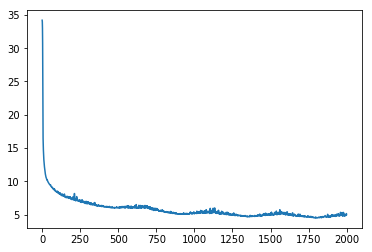

mean_absolute_error: 694.66%
642.50% (+/- 35.27%)


In [78]:
model=Modelcycle(2000,clr,X_train,y_train)

In [79]:
 model.evaluate(X_test, y_test, verbose=2)

[6.518817440618916, 6.518817440618916]